# ООО «Так закаляем сталь». Оптимизировать производство предсказанием температуру стали.

**Промышленность — задача проекта**  

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Нам предстоит построить модель, которая предскажет температуру стали.  

**Описание этапа обработки**  

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.   

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).  

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.  

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).  

**Описание данных**  

Данные состоят из файлов, полученных из разных источников:  

- `data_arc.csv` — данные об электродах;  
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);  
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);  
- `data_gas.csv` — данные о продувке сплава газом;  
- `data_temp.csv` — результаты измерения температуры;  
- `data_wire.csv` — данные о проволочных материалах (объём);  
- `data_wire_time.csv` — данные о проволочных материалах (время).  

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

## Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import matplotlib.patches as patches

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV 

from sklearn.metrics import mean_absolute_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor

In [2]:
# константы
RANDOM_STATE = 70423
# определим метрику расчитываемую при кросс-валидации
SCORER = 'neg_mean_absolute_error'

In [3]:
try:
    data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
    data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
    data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
    data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
    data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
    data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
    data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')
except:
    data_arc = pd.read_csv('C:\\Users\\Константин\\Desktop\\Файлы\\Финальный проект\\Данные\\data_arc.csv')
    data_bulk = pd.read_csv('C:\\Users\\Константин\\Desktop\\Файлы\\Финальный проект\\Данные\\data_bulk.csv')
    data_bulk_time = pd.read_csv('C:\\Users\\Константин\\Desktop\\Файлы\\Финальный проект\\Данные\\data_bulk_time.csv')
    data_gas = pd.read_csv('C:\\Users\\Константин\\Desktop\\Файлы\\Финальный проект\\Данные\\data_gas.csv')
    data_temp = pd.read_csv('C:\\Users\\Константин\\Desktop\\Файлы\\Финальный проект\\Данные\\data_temp.csv')
    data_wire = pd.read_csv('C:\\Users\\Константин\\Desktop\\Файлы\\Финальный проект\\Данные\\data_wire.csv')
    data_wire_time = pd.read_csv('C:\\Users\\Константин\\Desktop\\Файлы\\Финальный проект\\Данные\\data_wire_time.csv')

In [4]:
#присвоение имен df
data_arc.name = 'data_arc - данные об электродах'
data_bulk.name = 'data_bulk - данные о подаче сыпучих материалов (объём)'
data_bulk_time.name = 'data_bulk_time - данные о подаче сыпучих материалов (время)'
data_gas.name = 'data_gas - данные о продувке сплава газом'
data_temp.name = 'data_temp - результаты измерения температуры'
data_wire.name = 'data_wire - данные о проволочных материалах (объём)'
data_wire_time.name = 'data_wire_time - данные о проволочных материалах (время)'

In [5]:
#список всех df
data = [data_arc, data_bulk, data_bulk_time, data_gas,
        data_temp, data_wire, data_wire_time]

In [6]:
# функция для вывода основной информации о данных
def data_research(data):
    
    print('--------------------',data.name,'--------------------')
    display(data.head())
    print()
    data.info()
    print()
    print('Пропуски:', data.isna().sum().sum(), 'это {:.2%} от всех данных.'
          .format(data.isna().sum().sum() / (data.shape[0] * data.shape[1])))
    print()
    print('Процент (%) пропусков в каждой категории данных.')
    display((data.isna().sum() / data.shape[0]) * 100)
    print()
    print('Явные дубликаты:', data.duplicated().sum(), 'это {:.2%} от всех данных.'
          .format(data.duplicated().sum() / data.shape[0]))
    print()


In [7]:
for d in data:
    data_research(d)

-------------------- data_arc - данные об электродах --------------------


key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.976059   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.805607   
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.744363   
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19           1.659363   
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.692755   

   Реактивная мощность  
0             0.687084  
1             0.520285  
2             0.498805  
3             1.062669  
4             0.414397


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB

Пропуски: 0 это 0.00% от всех данных.

Процент (%) пропусков в каждой категории данных.


key                     0.0
Начало нагрева дугой    0.0
Конец нагрева дугой     0.0
Активная мощность       0.0
Реактивная мощность     0.0
dtype: float64


Явные дубликаты: 0 это 0.00% от всех данных.

-------------------- data_bulk - данные о подаче сыпучих материалов (объём) --------------------


key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3    4     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN   
4    5     NaN     NaN     NaN    78.0     NaN     NaN     NaN     NaN   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0     NaN      NaN      NaN    206.0      NaN    150.0    154.0  
1     NaN      NaN      NaN    206.0      NaN    149.0    154.0  
2     NaN      NaN      NaN    205.0      NaN    152.0    153.0  
3     NaN      NaN      NaN    207.0      NaN    153.0    154.0  
4     NaN      NaN      NaN    203.0      NaN    151.0    152.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB

Пропуски: 35776 это 71.46% от всех данных.

Процент (%) пропусков в каждой категории данных.


key         0.000000
Bulk 1     91.946309
Bulk 2     99.296900
Bulk 3     58.517098
Bulk 4     67.593480
Bulk 5     97.539150
Bulk 6     81.591563
Bulk 7     99.201023
Bulk 8     99.968041
Bulk 9     99.392777
Bulk 10    94.375200
Bulk 11    94.343241
Bulk 12    21.700224
Bulk 13    99.424736
Bulk 14    10.322787
Bulk 15    28.155960
dtype: float64


Явные дубликаты: 0 это 0.00% от всех данных.

-------------------- data_bulk_time - данные о подаче сыпучих материалов (время) --------------------


key Bulk 1 Bulk 2 Bulk 3               Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8  \
0    1    NaN    NaN    NaN  2019-05-03 11:21:30    NaN    NaN    NaN    NaN   
1    2    NaN    NaN    NaN  2019-05-03 11:46:38    NaN    NaN    NaN    NaN   
2    3    NaN    NaN    NaN  2019-05-03 12:31:06    NaN    NaN    NaN    NaN   
3    4    NaN    NaN    NaN  2019-05-03 12:48:43    NaN    NaN    NaN    NaN   
4    5    NaN    NaN    NaN  2019-05-03 13:18:50    NaN    NaN    NaN    NaN   

  Bulk 9 Bulk 10 Bulk 11              Bulk 12 Bulk 13              Bulk 14  \
0    NaN     NaN     NaN  2019-05-03 11:03:52     NaN  2019-05-03 11:03:52   
1    NaN     NaN     NaN  2019-05-03 11:40:20     NaN  2019-05-03 11:40:20   
2    NaN     NaN     NaN  2019-05-03 12:09:40     NaN  2019-05-03 12:09:40   
3    NaN     NaN     NaN  2019-05-03 12:41:24     NaN  2019-05-03 12:41:24   
4    NaN     NaN     NaN  2019-05-03 13:12:56     NaN  2019-05-03 13:12:56   

               Bulk 15  
0  2019-05-03 11:03:52  
1  2019-05-03 11:40:20  
2  2019-05-03 12:09:40  
3  2019-05-03 12:41:24  
4  2019-05-03 13:12:56


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB

Пропуски: 35776 это 71.46% от всех данных.

Процент (%) пропусков в каждой категории данных.


key         0.000000
Bulk 1     91.946309
Bulk 2     99.296900
Bulk 3     58.517098
Bulk 4     67.593480
Bulk 5     97.539150
Bulk 6     81.591563
Bulk 7     99.201023
Bulk 8     99.968041
Bulk 9     99.392777
Bulk 10    94.375200
Bulk 11    94.343241
Bulk 12    21.700224
Bulk 13    99.424736
Bulk 14    10.322787
Bulk 15    28.155960
dtype: float64


Явные дубликаты: 0 это 0.00% от всех данных.

-------------------- data_gas - данные о продувке сплава газом --------------------


key      Газ 1
0    1  29.749986
1    2  12.555561
2    3  28.554793
3    4  18.841219
4    5   5.413692


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB

Пропуски: 0 это 0.00% от всех данных.

Процент (%) пропусков в каждой категории данных.


key      0.0
Газ 1    0.0
dtype: float64


Явные дубликаты: 0 это 0.00% от всех данных.

-------------------- data_temp - результаты измерения температуры --------------------


key         Время замера  Температура
0    1  2019-05-03 11:16:18       1571.0
1    1  2019-05-03 11:25:53       1604.0
2    1  2019-05-03 11:29:11       1618.0
3    1  2019-05-03 11:30:01       1601.0
4    1  2019-05-03 11:30:39       1613.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB

Пропуски: 2901 это 6.08% от всех данных.

Процент (%) пропусков в каждой категории данных.


key              0.000000
Время замера     0.000000
Температура     18.237254
dtype: float64


Явные дубликаты: 0 это 0.00% от всех данных.

-------------------- data_wire - данные о проволочных материалах (объём) --------------------


key     Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1  60.059998      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2  96.052315      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    3  91.160157      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3    4  89.063515      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4    5  89.238236  9.11456     NaN     NaN     NaN     NaN     NaN     NaN   

   Wire 9  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB

Пропуски: 23385 это 75.90% от всех данных.

Процент (%) пропусков в каждой категории данных.


key        0.000000
Wire 1     0.843882
Wire 2    64.978903
Wire 3    97.955209
Wire 4    99.545602
Wire 5    99.967543
Wire 6    97.630639
Wire 7    99.642973
Wire 8    99.383317
Wire 9    99.058747
dtype: float64


Явные дубликаты: 0 это 0.00% от всех данных.

-------------------- data_wire_time - данные о проволочных материалах (время) --------------------


key               Wire 1               Wire 2 Wire 3 Wire 4 Wire 5 Wire 6  \
0    1  2019-05-03 11:11:41                  NaN    NaN    NaN    NaN    NaN   
1    2  2019-05-03 11:46:10                  NaN    NaN    NaN    NaN    NaN   
2    3  2019-05-03 12:13:47                  NaN    NaN    NaN    NaN    NaN   
3    4  2019-05-03 12:48:05                  NaN    NaN    NaN    NaN    NaN   
4    5  2019-05-03 13:18:15  2019-05-03 13:32:06    NaN    NaN    NaN    NaN   

  Wire 7 Wire 8 Wire 9  
0    NaN    NaN    NaN  
1    NaN    NaN    NaN  
2    NaN    NaN    NaN  
3    NaN    NaN    NaN  
4    NaN    NaN    NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB

Пропуски: 23385 это 75.90% от всех данных.

Процент (%) пропусков в каждой категории данных.


key        0.000000
Wire 1     0.843882
Wire 2    64.978903
Wire 3    97.955209
Wire 4    99.545602
Wire 5    99.967543
Wire 6    97.630639
Wire 7    99.642973
Wire 8    99.383317
Wire 9    99.058747
dtype: float64


Явные дубликаты: 0 это 0.00% от всех данных.



**Вывод**  
- Названия столбцов не корректны. Не верный синтаксис, используются два языка.  
- Не верно указан тип данных. Все данные с временем указаны в 'object'.    
Исправим.  

In [8]:
#перевод названий на английский язык
data_arc.rename(columns = {'Начало нагрева дугой':'Start of arc heating',
                           'Конец нагрева дугой':'End of arc heating',
                           'Активная мощность':'Active power',
                           'Реактивная мощность':'Reactive power',}, inplace = True )
data_temp.rename(columns = {'Время замера':'Measurement time',
                            'Температура':'Temperature'}, inplace = True )
data_gas.rename(columns = {'Газ 1':'Gas 1'}, inplace = True )

In [9]:
# функция для преобразования строки в змеиный регистр
def registre1(data):
    for d in data.columns:
        s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', d)
        s2 = re.sub(r"\s+", '_', s1)
        s3 = re.sub('([a-z0-9])([A-Z])', r'\1_\2', s2).lower()
        data.rename(columns={d:s3}, inplace = True)

In [10]:
for d in data:
    registre1(d)

In [11]:
#функция преобразования типа данных в datetime64
def time1(data):
    for d in data.columns:
        column1 = data[d].dtype
        if column1 == 'object':
            data[d] = pd.to_datetime(data[d])

In [12]:
for d in data:
    time1(d)

## Анализ данных

Изучим соотношение данных в основной массе и распределение по времени.

In [13]:
for d in data:
    data_research(d)

-------------------- data_arc - данные об электродах --------------------


key start_of_arc_heating  end_of_arc_heating  active_power  reactive_power
0    1  2019-05-03 11:02:14 2019-05-03 11:06:02      0.976059        0.687084
1    1  2019-05-03 11:07:28 2019-05-03 11:10:33      0.805607        0.520285
2    1  2019-05-03 11:11:44 2019-05-03 11:14:36      0.744363        0.498805
3    1  2019-05-03 11:18:14 2019-05-03 11:24:19      1.659363        1.062669
4    1  2019-05-03 11:26:09 2019-05-03 11:28:37      0.692755        0.414397


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   start_of_arc_heating  14876 non-null  datetime64[ns]
 2   end_of_arc_heating    14876 non-null  datetime64[ns]
 3   active_power          14876 non-null  float64       
 4   reactive_power        14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB

Пропуски: 0 это 0.00% от всех данных.

Процент (%) пропусков в каждой категории данных.


key                     0.0
start_of_arc_heating    0.0
end_of_arc_heating      0.0
active_power            0.0
reactive_power          0.0
dtype: float64


Явные дубликаты: 0 это 0.00% от всех данных.

-------------------- data_bulk - данные о подаче сыпучих материалов (объём) --------------------


key  bulk_1  bulk_2  bulk_3  bulk_4  bulk_5  bulk_6  bulk_7  bulk_8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3    4     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN   
4    5     NaN     NaN     NaN    78.0     NaN     NaN     NaN     NaN   

   bulk_9  bulk_10  bulk_11  bulk_12  bulk_13  bulk_14  bulk_15  
0     NaN      NaN      NaN    206.0      NaN    150.0    154.0  
1     NaN      NaN      NaN    206.0      NaN    149.0    154.0  
2     NaN      NaN      NaN    205.0      NaN    152.0    153.0  
3     NaN      NaN      NaN    207.0      NaN    153.0    154.0  
4     NaN      NaN      NaN    203.0      NaN    151.0    152.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_8   1 non-null      float64
 9   bulk_9   19 non-null     float64
 10  bulk_10  176 non-null    float64
 11  bulk_11  177 non-null    float64
 12  bulk_12  2450 non-null   float64
 13  bulk_13  18 non-null     float64
 14  bulk_14  2806 non-null   float64
 15  bulk_15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB

Пропуски: 35776 это 71.46% от всех данных.

Процент (%) пропусков в каждой категории данных.


key         0.000000
bulk_1     91.946309
bulk_2     99.296900
bulk_3     58.517098
bulk_4     67.593480
bulk_5     97.539150
bulk_6     81.591563
bulk_7     99.201023
bulk_8     99.968041
bulk_9     99.392777
bulk_10    94.375200
bulk_11    94.343241
bulk_12    21.700224
bulk_13    99.424736
bulk_14    10.322787
bulk_15    28.155960
dtype: float64


Явные дубликаты: 0 это 0.00% от всех данных.

-------------------- data_bulk_time - данные о подаче сыпучих материалов (время) --------------------


key bulk_1 bulk_2 bulk_3              bulk_4 bulk_5 bulk_6 bulk_7 bulk_8  \
0    1    NaT    NaT    NaT 2019-05-03 11:21:30    NaT    NaT    NaT    NaT   
1    2    NaT    NaT    NaT 2019-05-03 11:46:38    NaT    NaT    NaT    NaT   
2    3    NaT    NaT    NaT 2019-05-03 12:31:06    NaT    NaT    NaT    NaT   
3    4    NaT    NaT    NaT 2019-05-03 12:48:43    NaT    NaT    NaT    NaT   
4    5    NaT    NaT    NaT 2019-05-03 13:18:50    NaT    NaT    NaT    NaT   

  bulk_9 bulk_10 bulk_11             bulk_12 bulk_13             bulk_14  \
0    NaT     NaT     NaT 2019-05-03 11:03:52     NaT 2019-05-03 11:03:52   
1    NaT     NaT     NaT 2019-05-03 11:40:20     NaT 2019-05-03 11:40:20   
2    NaT     NaT     NaT 2019-05-03 12:09:40     NaT 2019-05-03 12:09:40   
3    NaT     NaT     NaT 2019-05-03 12:41:24     NaT 2019-05-03 12:41:24   
4    NaT     NaT     NaT 2019-05-03 13:12:56     NaT 2019-05-03 13:12:56   

              bulk_15  
0 2019-05-03 11:03:52  
1 2019-05-03 11:40:20  
2 2019-05-03 12:09:40  
3 2019-05-03 12:41:24  
4 2019-05-03 13:12:56


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   bulk_1   252 non-null    datetime64[ns]
 2   bulk_2   22 non-null     datetime64[ns]
 3   bulk_3   1298 non-null   datetime64[ns]
 4   bulk_4   1014 non-null   datetime64[ns]
 5   bulk_5   77 non-null     datetime64[ns]
 6   bulk_6   576 non-null    datetime64[ns]
 7   bulk_7   25 non-null     datetime64[ns]
 8   bulk_8   1 non-null      datetime64[ns]
 9   bulk_9   19 non-null     datetime64[ns]
 10  bulk_10  176 non-null    datetime64[ns]
 11  bulk_11  177 non-null    datetime64[ns]
 12  bulk_12  2450 non-null   datetime64[ns]
 13  bulk_13  18 non-null     datetime64[ns]
 14  bulk_14  2806 non-null   datetime64[ns]
 15  bulk_15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB

Пропуски: 35776 это 7

key         0.000000
bulk_1     91.946309
bulk_2     99.296900
bulk_3     58.517098
bulk_4     67.593480
bulk_5     97.539150
bulk_6     81.591563
bulk_7     99.201023
bulk_8     99.968041
bulk_9     99.392777
bulk_10    94.375200
bulk_11    94.343241
bulk_12    21.700224
bulk_13    99.424736
bulk_14    10.322787
bulk_15    28.155960
dtype: float64


Явные дубликаты: 0 это 0.00% от всех данных.

-------------------- data_gas - данные о продувке сплава газом --------------------


key      gas_1
0    1  29.749986
1    2  12.555561
2    3  28.554793
3    4  18.841219
4    5   5.413692


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas_1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB

Пропуски: 0 это 0.00% от всех данных.

Процент (%) пропусков в каждой категории данных.


key      0.0
gas_1    0.0
dtype: float64


Явные дубликаты: 0 это 0.00% от всех данных.

-------------------- data_temp - результаты измерения температуры --------------------


key    measurement_time  temperature
0    1 2019-05-03 11:16:18       1571.0
1    1 2019-05-03 11:25:53       1604.0
2    1 2019-05-03 11:29:11       1618.0
3    1 2019-05-03 11:30:01       1601.0
4    1 2019-05-03 11:30:39       1613.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   key               15907 non-null  int64         
 1   measurement_time  15907 non-null  datetime64[ns]
 2   temperature       13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB

Пропуски: 2901 это 6.08% от всех данных.

Процент (%) пропусков в каждой категории данных.


key                  0.000000
measurement_time     0.000000
temperature         18.237254
dtype: float64


Явные дубликаты: 0 это 0.00% от всех данных.

-------------------- data_wire - данные о проволочных материалах (объём) --------------------


key     wire_1   wire_2  wire_3  wire_4  wire_5  wire_6  wire_7  wire_8  \
0    1  60.059998      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2  96.052315      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    3  91.160157      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3    4  89.063515      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4    5  89.238236  9.11456     NaN     NaN     NaN     NaN     NaN     NaN   

   wire_9  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3055 non-null   float64
 2   wire_2  1079 non-null   float64
 3   wire_3  63 non-null     float64
 4   wire_4  14 non-null     float64
 5   wire_5  1 non-null      float64
 6   wire_6  73 non-null     float64
 7   wire_7  11 non-null     float64
 8   wire_8  19 non-null     float64
 9   wire_9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB

Пропуски: 23385 это 75.90% от всех данных.

Процент (%) пропусков в каждой категории данных.


key        0.000000
wire_1     0.843882
wire_2    64.978903
wire_3    97.955209
wire_4    99.545602
wire_5    99.967543
wire_6    97.630639
wire_7    99.642973
wire_8    99.383317
wire_9    99.058747
dtype: float64


Явные дубликаты: 0 это 0.00% от всех данных.

-------------------- data_wire_time - данные о проволочных материалах (время) --------------------


key              wire_1              wire_2 wire_3 wire_4 wire_5 wire_6  \
0    1 2019-05-03 11:11:41                 NaT    NaT    NaT    NaT    NaT   
1    2 2019-05-03 11:46:10                 NaT    NaT    NaT    NaT    NaT   
2    3 2019-05-03 12:13:47                 NaT    NaT    NaT    NaT    NaT   
3    4 2019-05-03 12:48:05                 NaT    NaT    NaT    NaT    NaT   
4    5 2019-05-03 13:18:15 2019-05-03 13:32:06    NaT    NaT    NaT    NaT   

  wire_7 wire_8 wire_9  
0    NaT    NaT    NaT  
1    NaT    NaT    NaT  
2    NaT    NaT    NaT  
3    NaT    NaT    NaT  
4    NaT    NaT    NaT


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   wire_1  3055 non-null   datetime64[ns]
 2   wire_2  1079 non-null   datetime64[ns]
 3   wire_3  63 non-null     datetime64[ns]
 4   wire_4  14 non-null     datetime64[ns]
 5   wire_5  1 non-null      datetime64[ns]
 6   wire_6  73 non-null     datetime64[ns]
 7   wire_7  11 non-null     datetime64[ns]
 8   wire_8  19 non-null     datetime64[ns]
 9   wire_9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB

Пропуски: 23385 это 75.90% от всех данных.

Процент (%) пропусков в каждой категории данных.


key        0.000000
wire_1     0.843882
wire_2    64.978903
wire_3    97.955209
wire_4    99.545602
wire_5    99.967543
wire_6    97.630639
wire_7    99.642973
wire_8    99.383317
wire_9    99.058747
dtype: float64


Явные дубликаты: 0 это 0.00% от всех данных.



C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning

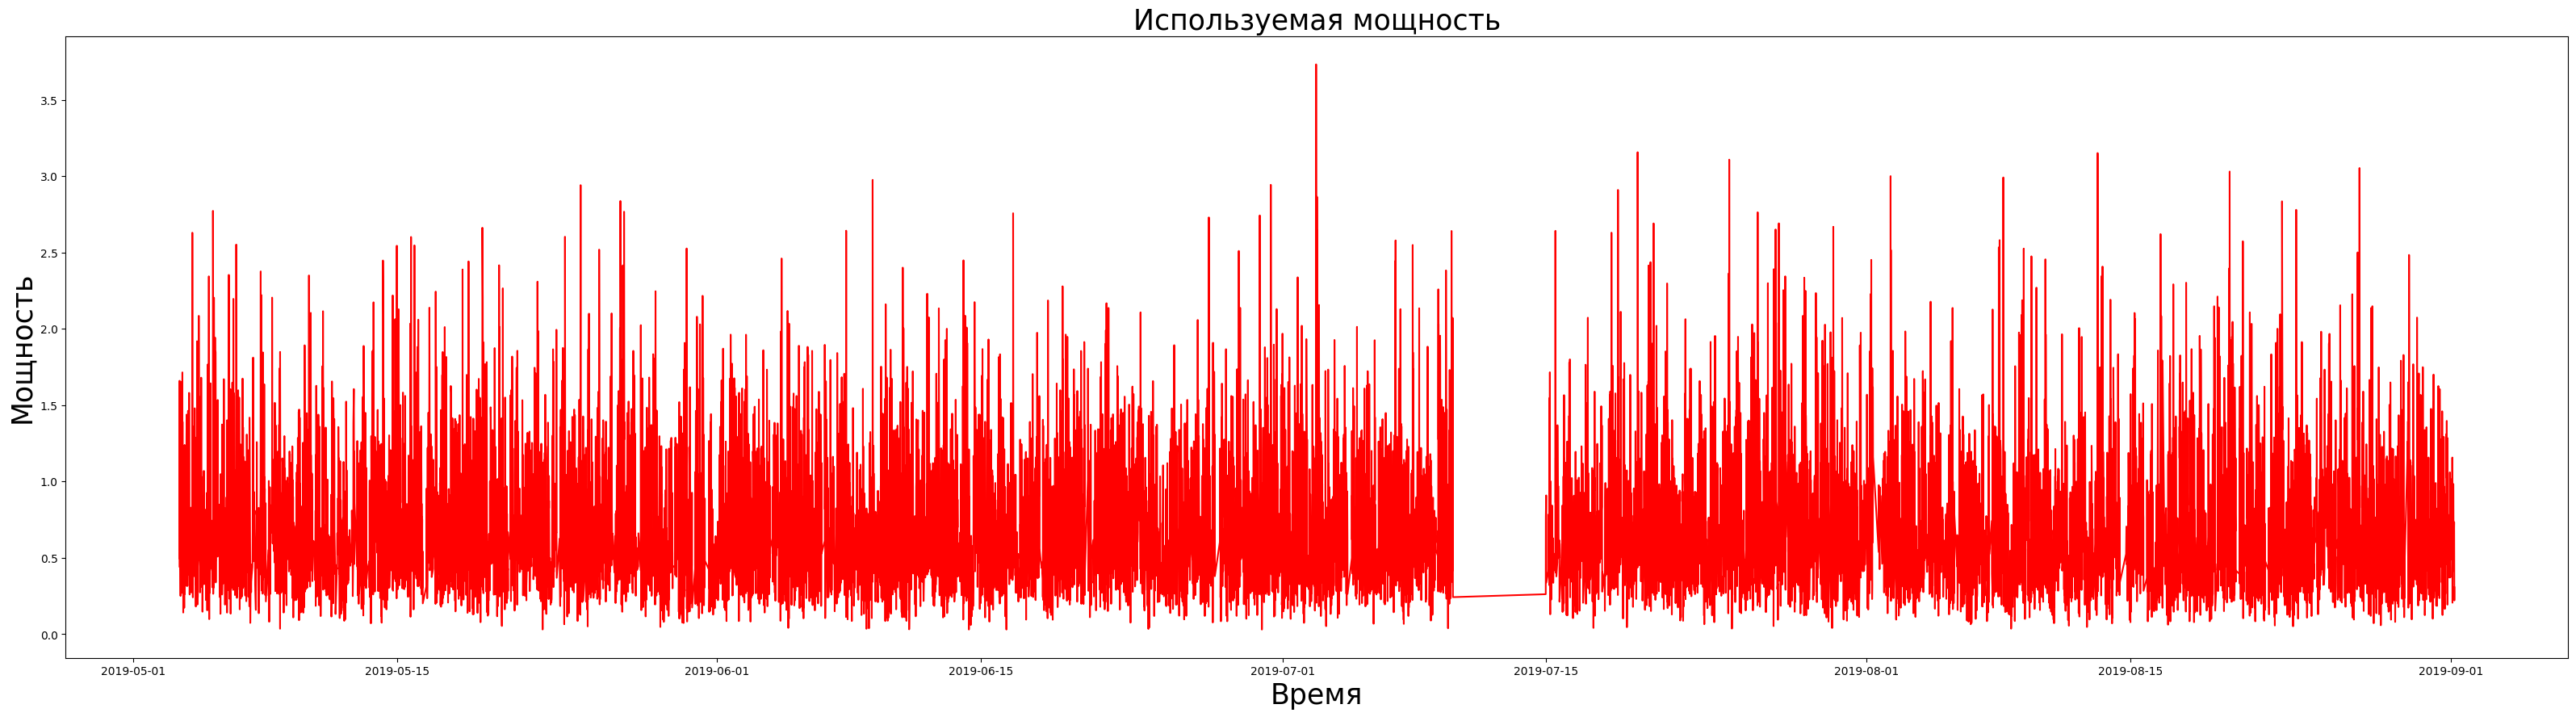

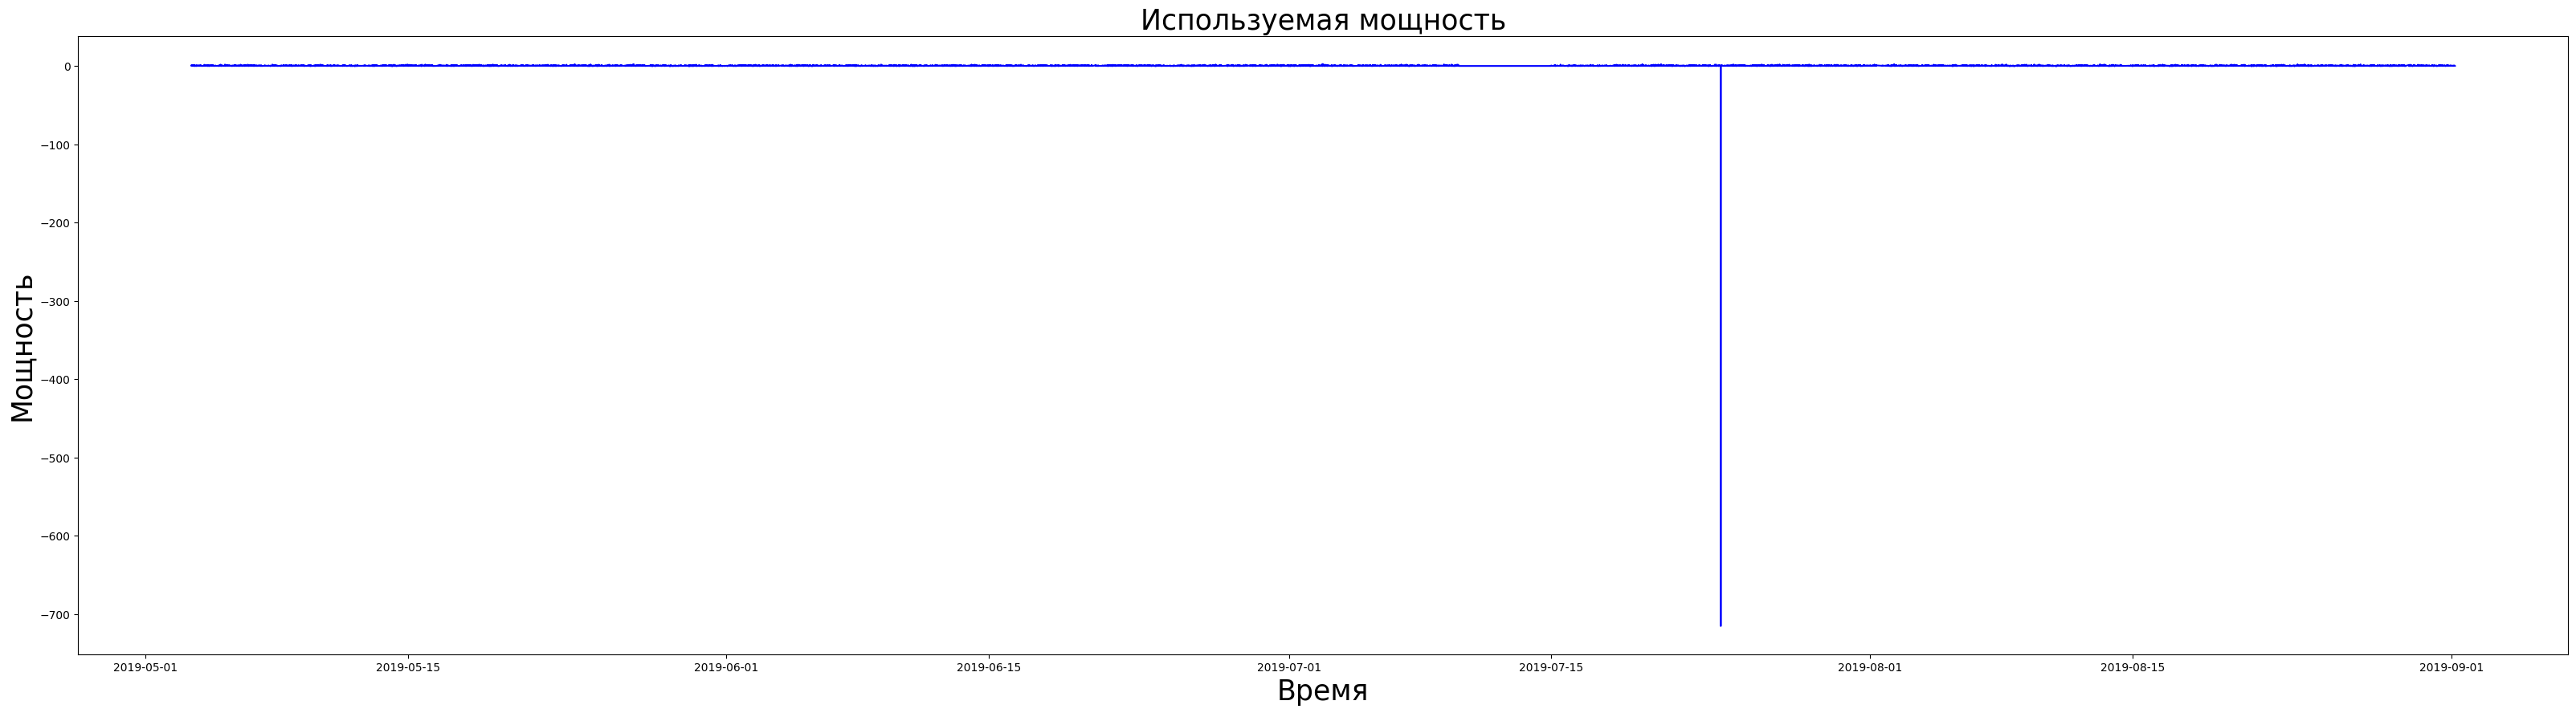

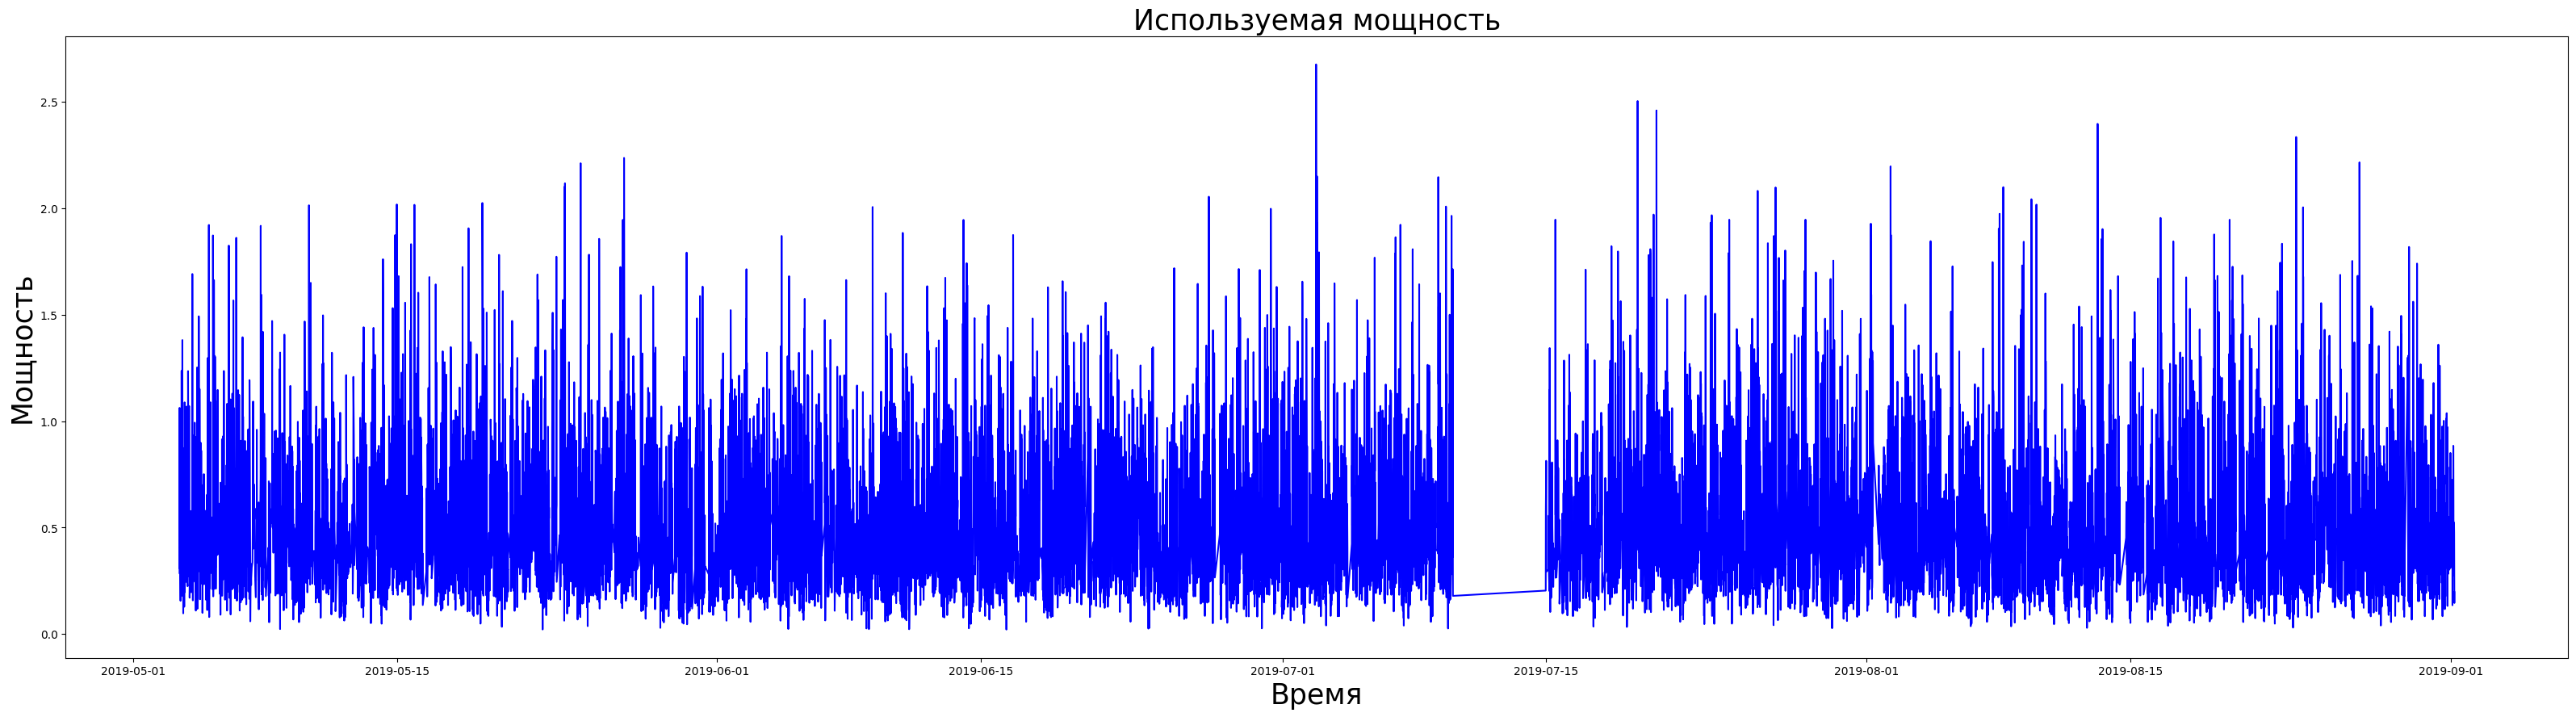

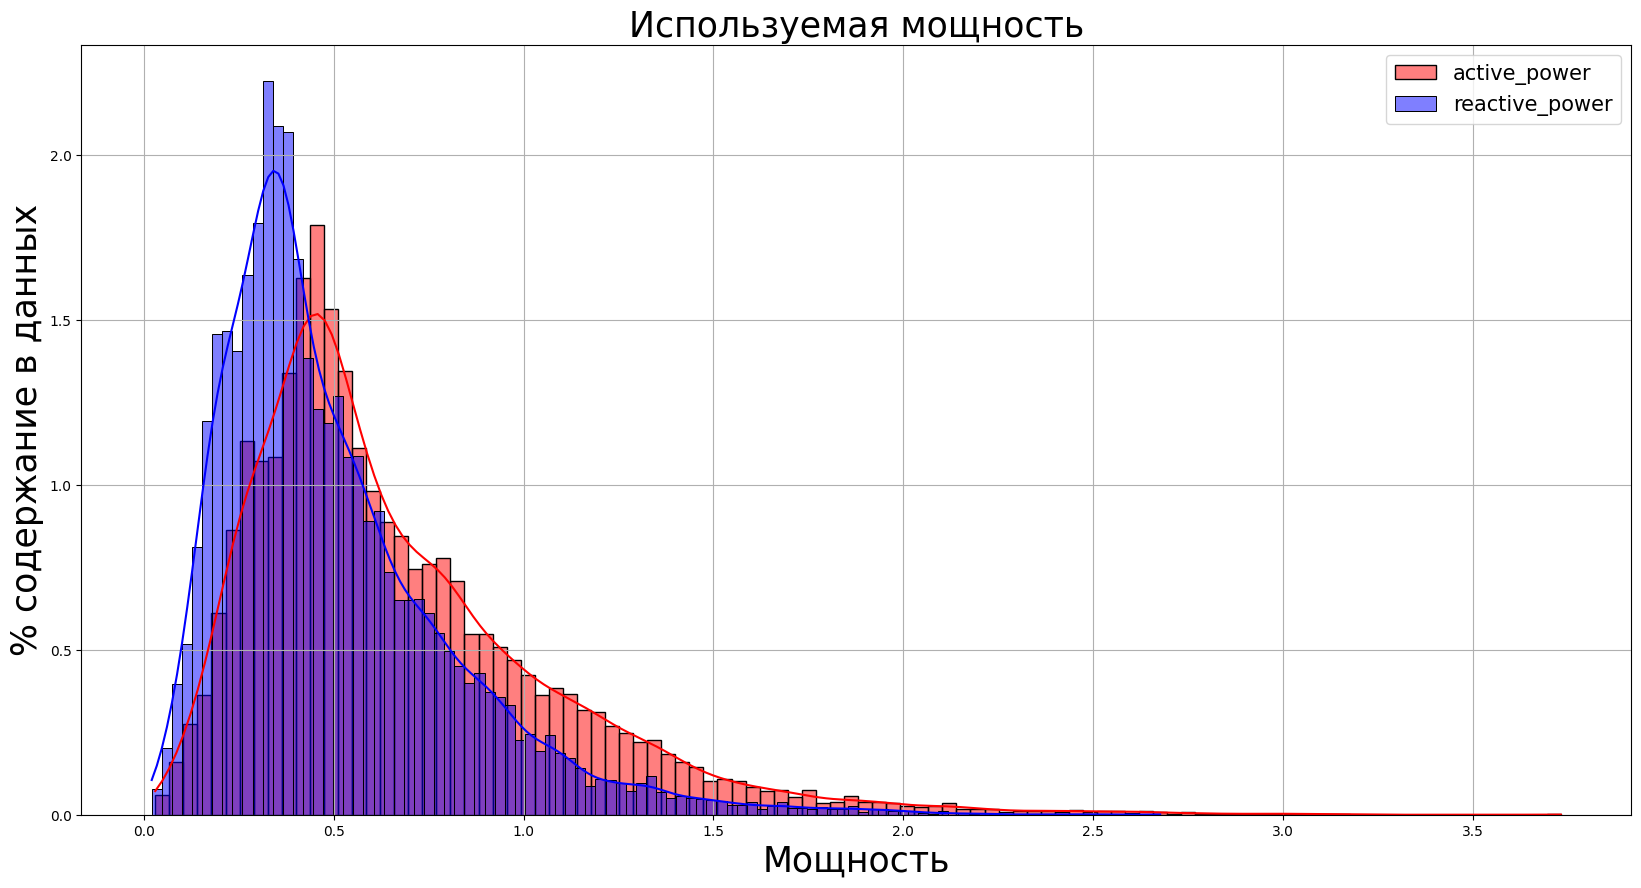

In [14]:
plt.figure(figsize=(40, 10))
sns.lineplot(x='start_of_arc_heating', y='active_power', data=data_arc, color='red') 
plt.title('Используемая мощность',fontsize=25)
plt.xlabel('Время',fontsize=25)
plt.ylabel('Мощность',fontsize=25)

plt.figure(figsize=(40, 10))
sns.lineplot(x='start_of_arc_heating', y='reactive_power', data=data_arc, color='blue') 
plt.title('Используемая мощность',fontsize=25)
plt.xlabel('Время',fontsize=25)
plt.ylabel('Мощность',fontsize=25)

plt.figure(figsize=(40, 10))
sns.lineplot(x='start_of_arc_heating', y='reactive_power', data=data_arc.query('reactive_power > 0'), color='blue')
plt.title('Используемая мощность',fontsize=25)
plt.xlabel('Время',fontsize=25)
plt.ylabel('Мощность',fontsize=25)


plt.figure(figsize=(20, 10))
sns.histplot(data_arc['active_power'], kde=True, stat="density", color='red',
             label='active_power', bins = 100)

sns.histplot(data_arc.query('reactive_power > 0')['reactive_power'],
             kde=True, stat="density", color='blue',
              label='reactive_power', bins = 100)

plt.title('Используемая мощность',fontsize=25)
plt.xlabel('Мощность',fontsize=25)
plt.ylabel('% содержание в данных',fontsize=25)

plt.legend(fontsize=15)
plt.grid()
plt.show()

C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


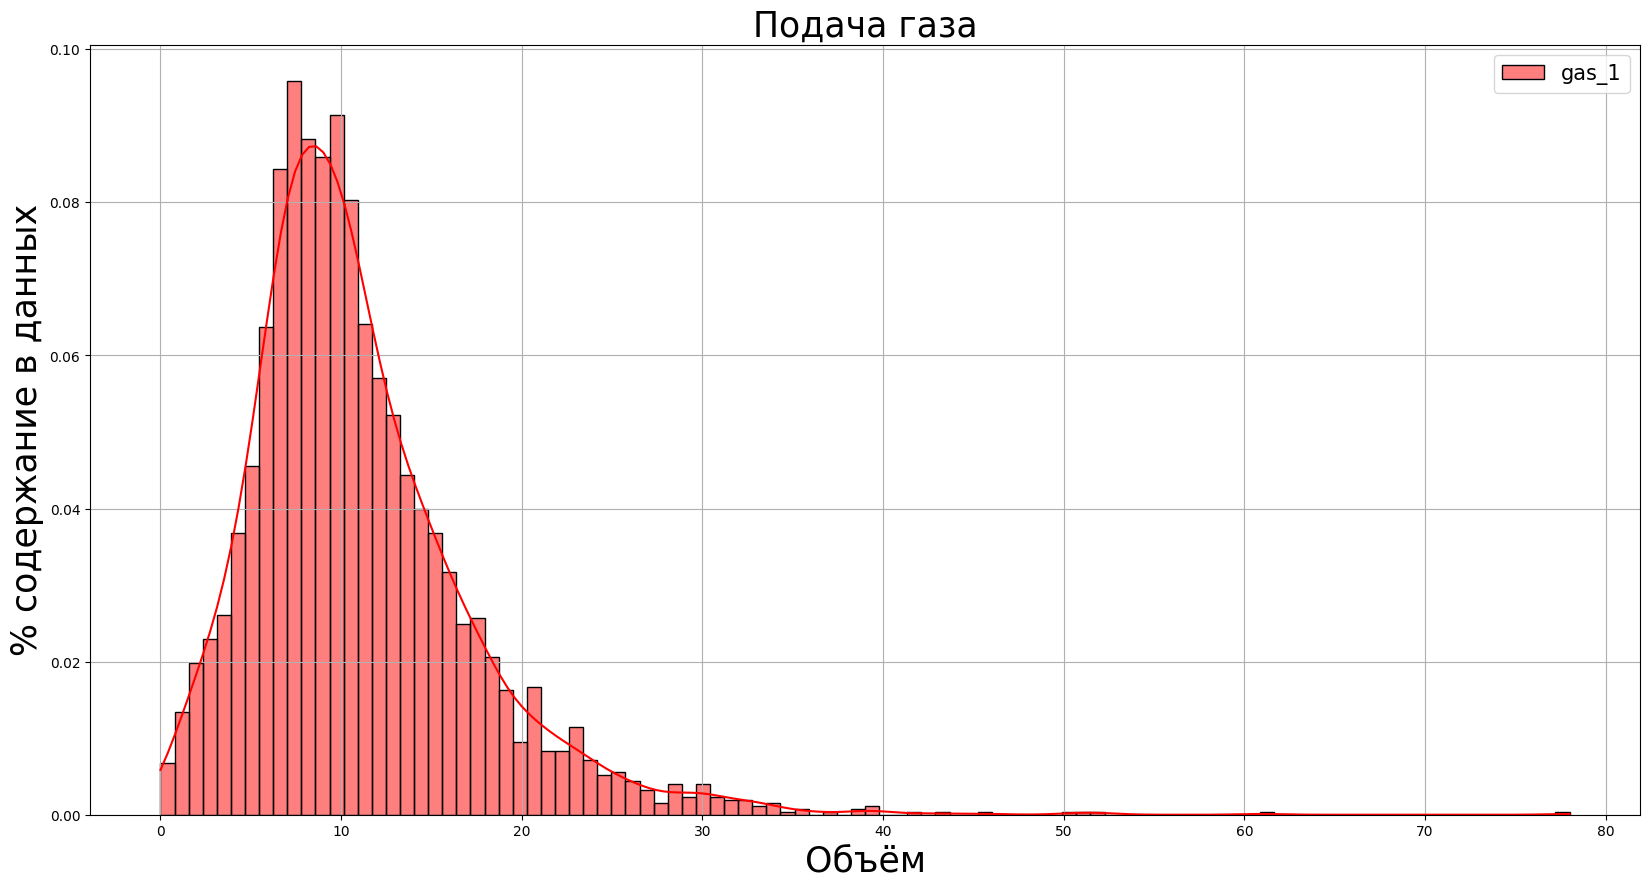

In [15]:
plt.figure(figsize=(20, 10))
sns.histplot(data_gas['gas_1'], color='red', label='gas_1', bins = 100, kde=True, stat="density")
plt.title('Подача газа',fontsize=25)
plt.xlabel('Объём',fontsize=25)
plt.ylabel('% содержание в данных',fontsize=25)
plt.legend(fontsize=15)
plt.grid()
plt.show()

C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning

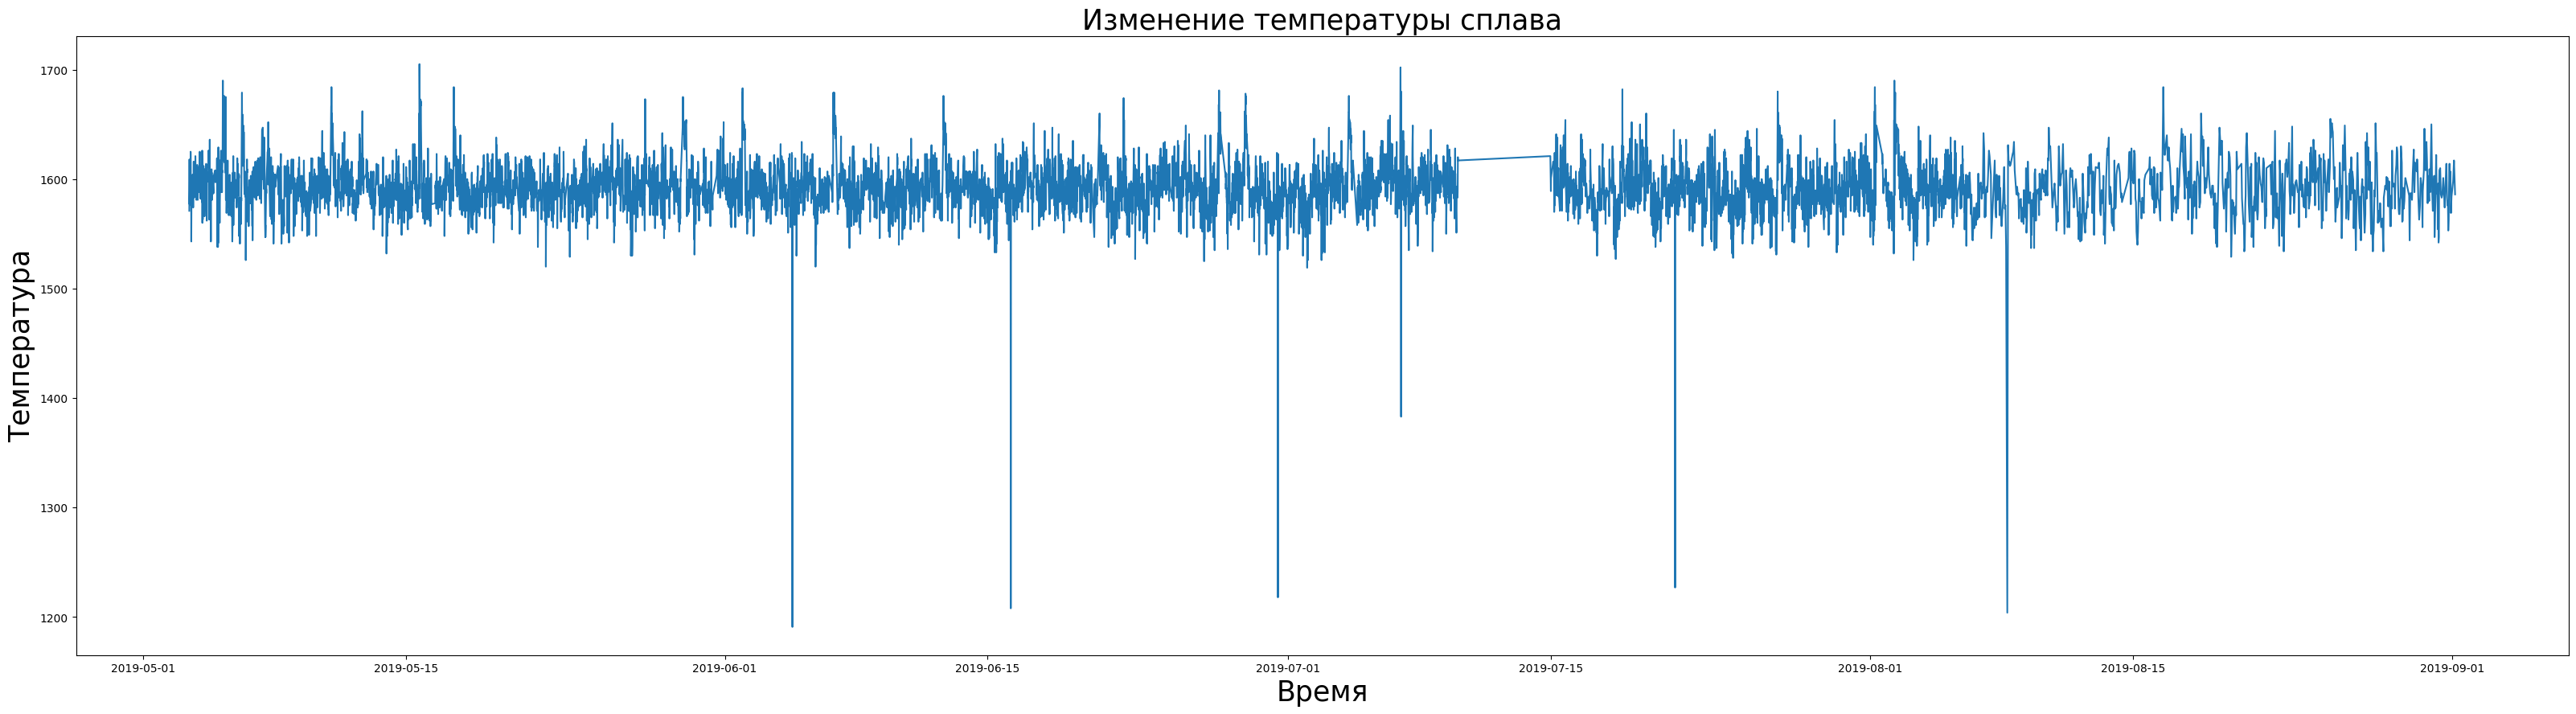

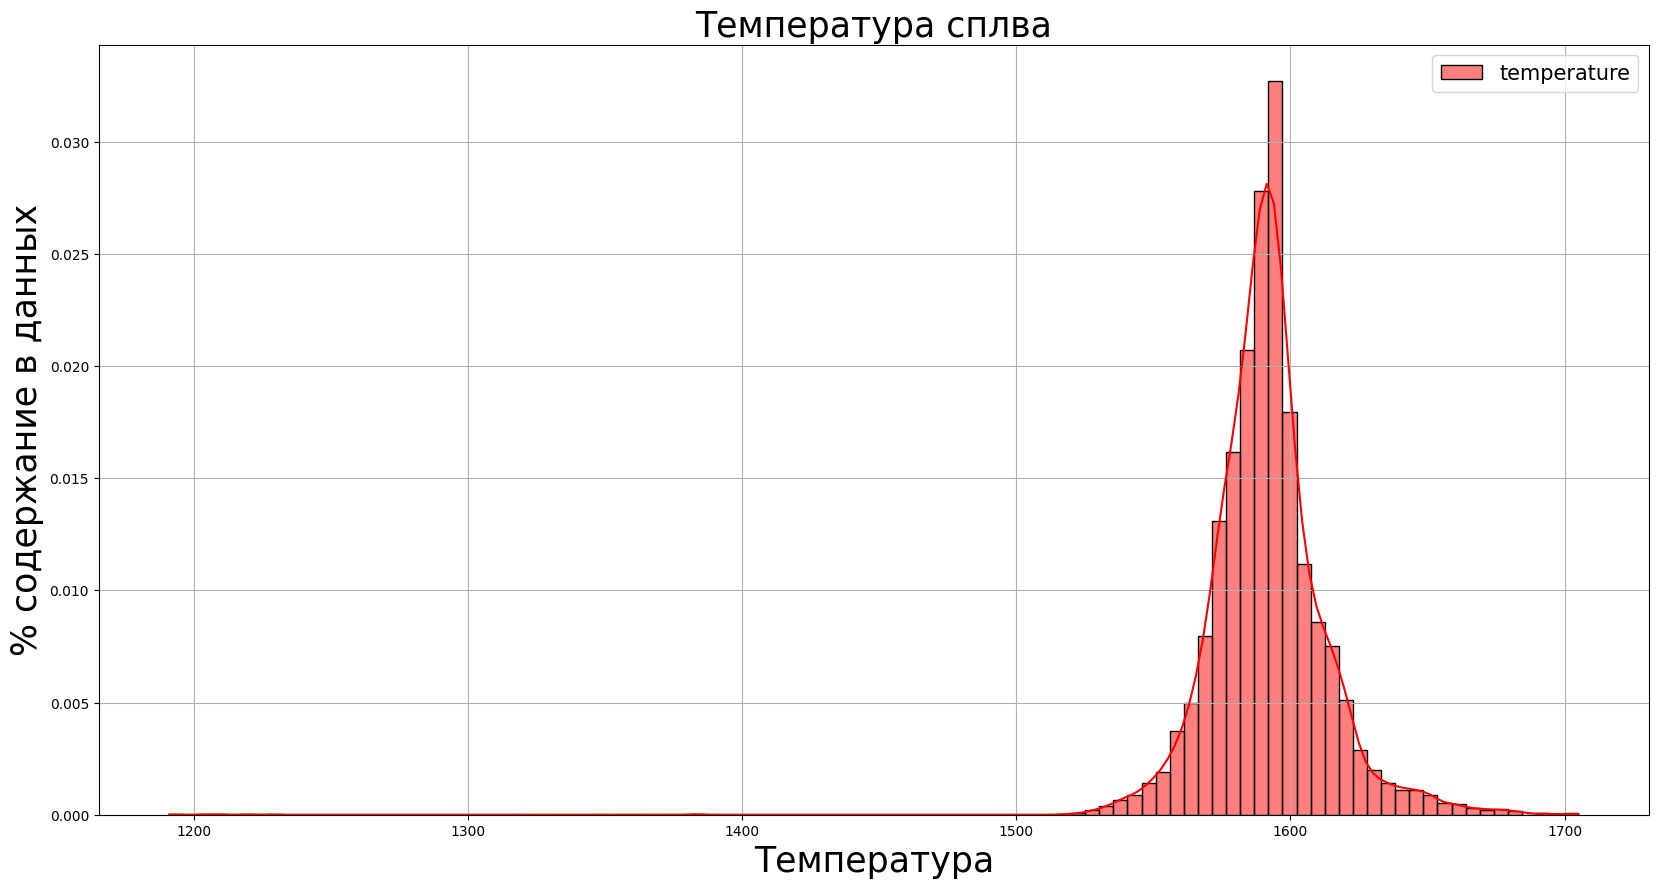

In [16]:
plt.figure(figsize=(40, 10))
sns.lineplot(x='measurement_time', y='temperature', data=data_temp)
plt.title('Изменение температуры сплава',fontsize=25)
plt.xlabel('Время',fontsize=25)
plt.ylabel('Температура',fontsize=25)

plt.figure(figsize=(20, 10))
sns.histplot(data_temp['temperature'], color='red', label='temperature', bins = 100, kde=True, stat="density")
plt.title('Температура сплва',fontsize=25)
plt.xlabel('Температура',fontsize=25)
plt.ylabel('% содержание в данных',fontsize=25)
plt.legend(fontsize=15)
plt.grid()
plt.show()

In [17]:
def chart1(data,n,x,y):
    for d in data.columns:
        column1 = data[d].dtype
        if column1 == 'float64':
            plt.figure(figsize=(20, 10))
            sns.histplot(data[d], label=d, bins = 100, kde=True, stat="density")        

            plt.title(n,fontsize=25)
            plt.xlabel(x,fontsize=25)
            plt.ylabel(y,fontsize=25)
            plt.legend(fontsize=15)

            plt.grid()
            plt.show()

In [18]:
def chart2(data,n,x,y):
    for d in range(1, 16, 1):
        d = str(d) 
        plt.figure(figsize=(40, 10))
        sns.lineplot(x='bulk_'+d+'_x', y='bulk_'+d+'_y', data=data, label='bulk_'+d)

        plt.title('Частота использования сыпучих материалов',fontsize=25)
        plt.xlabel('Время',fontsize=25)
        plt.ylabel('Количеств',fontsize=25)

        plt.legend(fontsize=15)
        plt.grid()
        plt.show()

In [19]:
def chart3(data,n,x,y):
    for d in range(1, 10, 1):
        d = str(d) 
        plt.figure(figsize=(40, 10))
        sns.lineplot(x='wire_'+d+'_x', y='wire_'+d+'_y', data=data, label='wire_'+d)

        plt.title('Частота использования проволочных материалов',fontsize=25)
        plt.xlabel('Время',fontsize=25)
        plt.ylabel('Количеств',fontsize=25)

        plt.legend(fontsize=15)
        plt.grid()
        plt.show()

In [20]:
bulk_splice = pd.merge(data_bulk_time, data_bulk, on="key")

In [21]:
wire_splice = pd.merge(data_wire_time, data_wire, on="key")

C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning

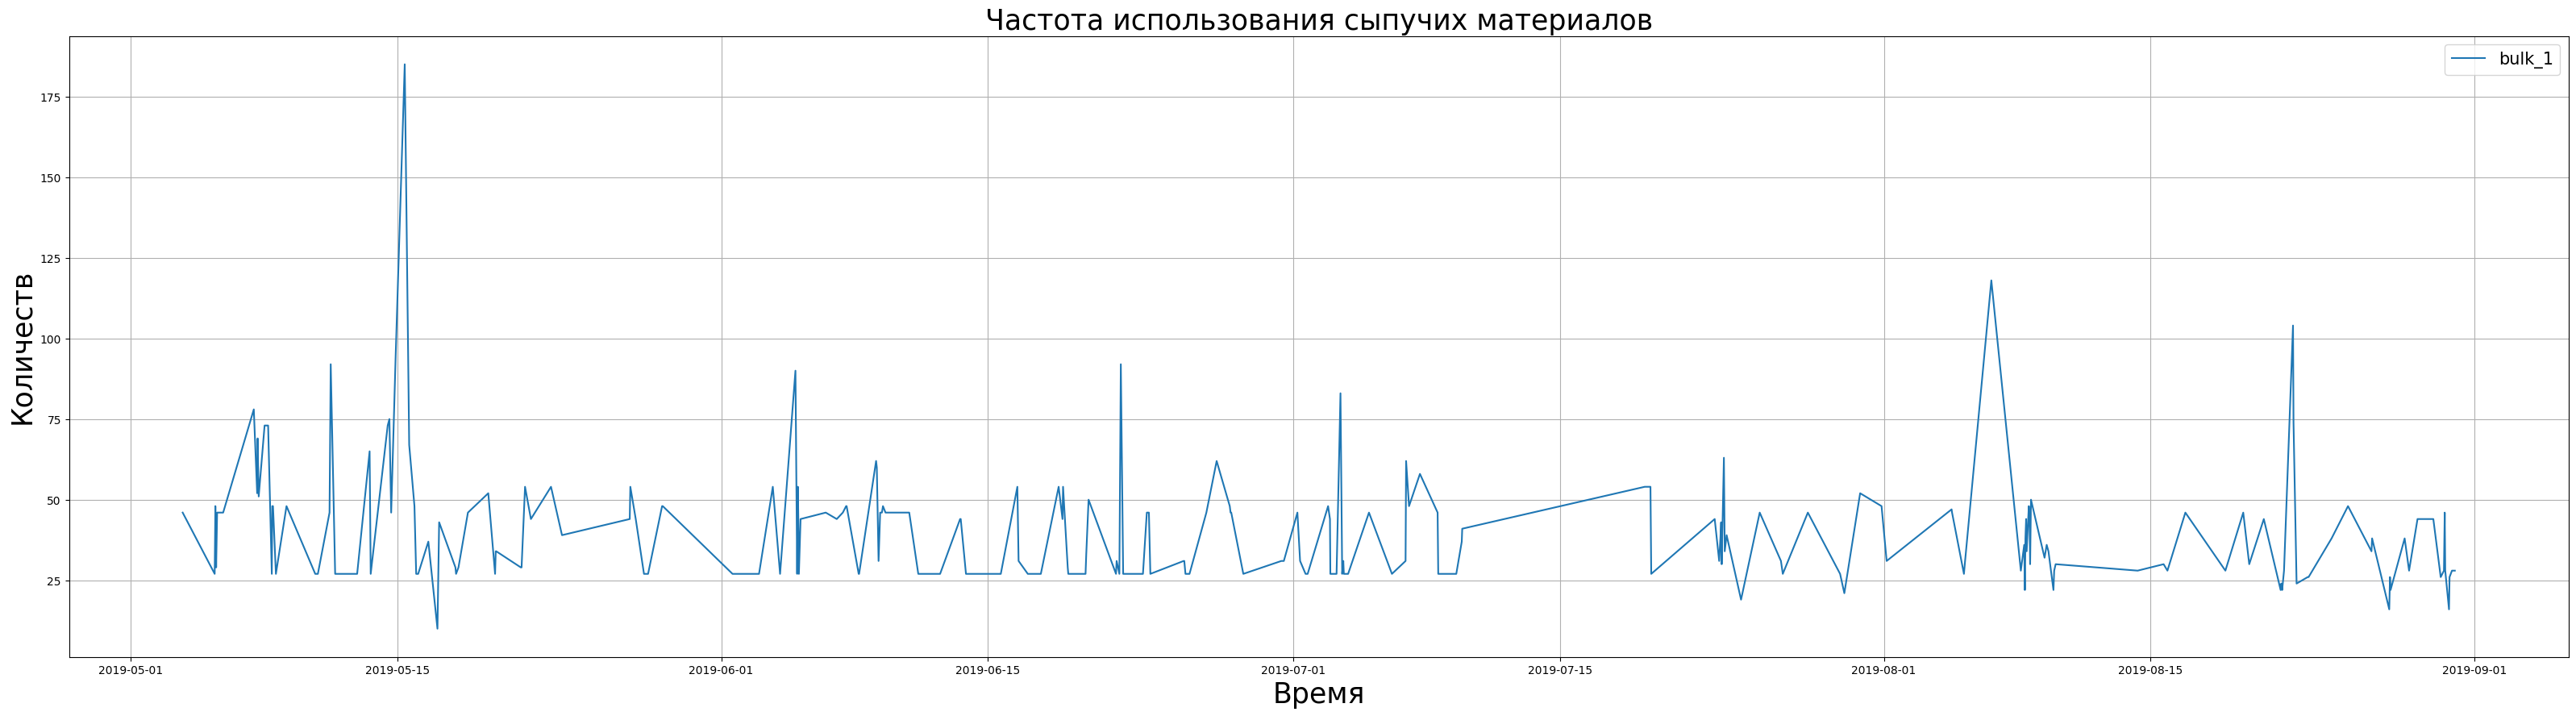

C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning

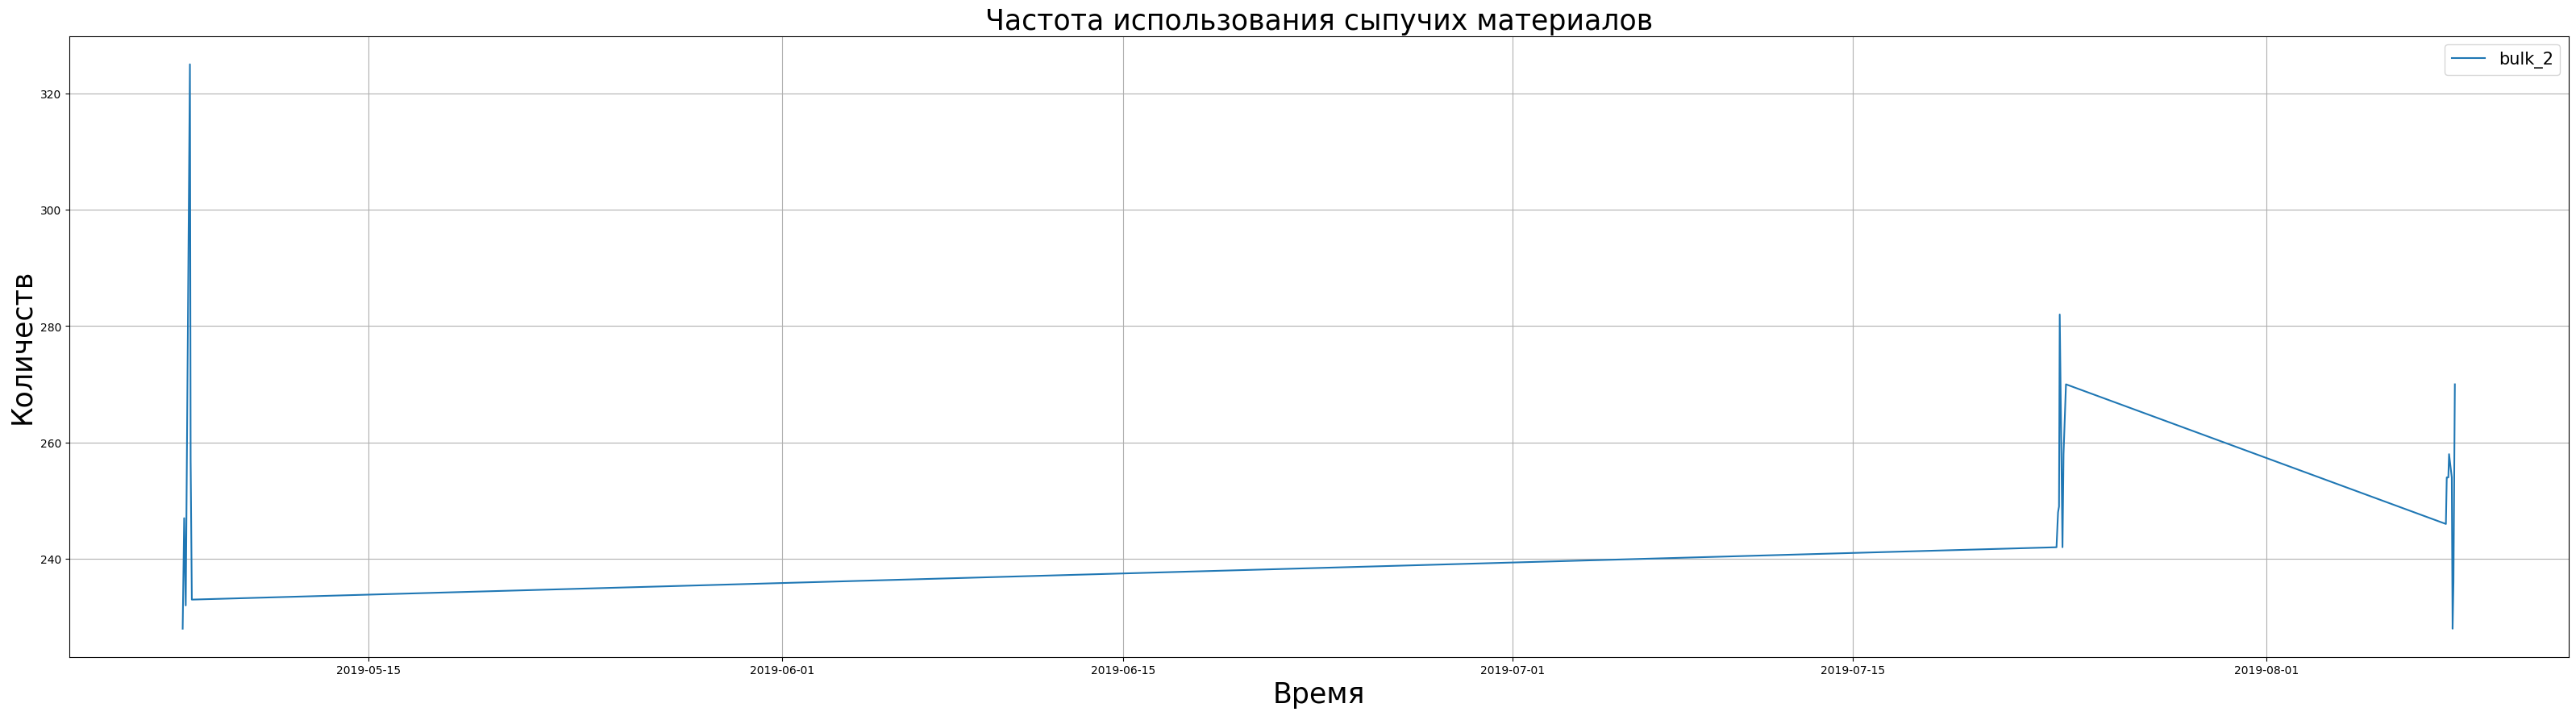

C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning

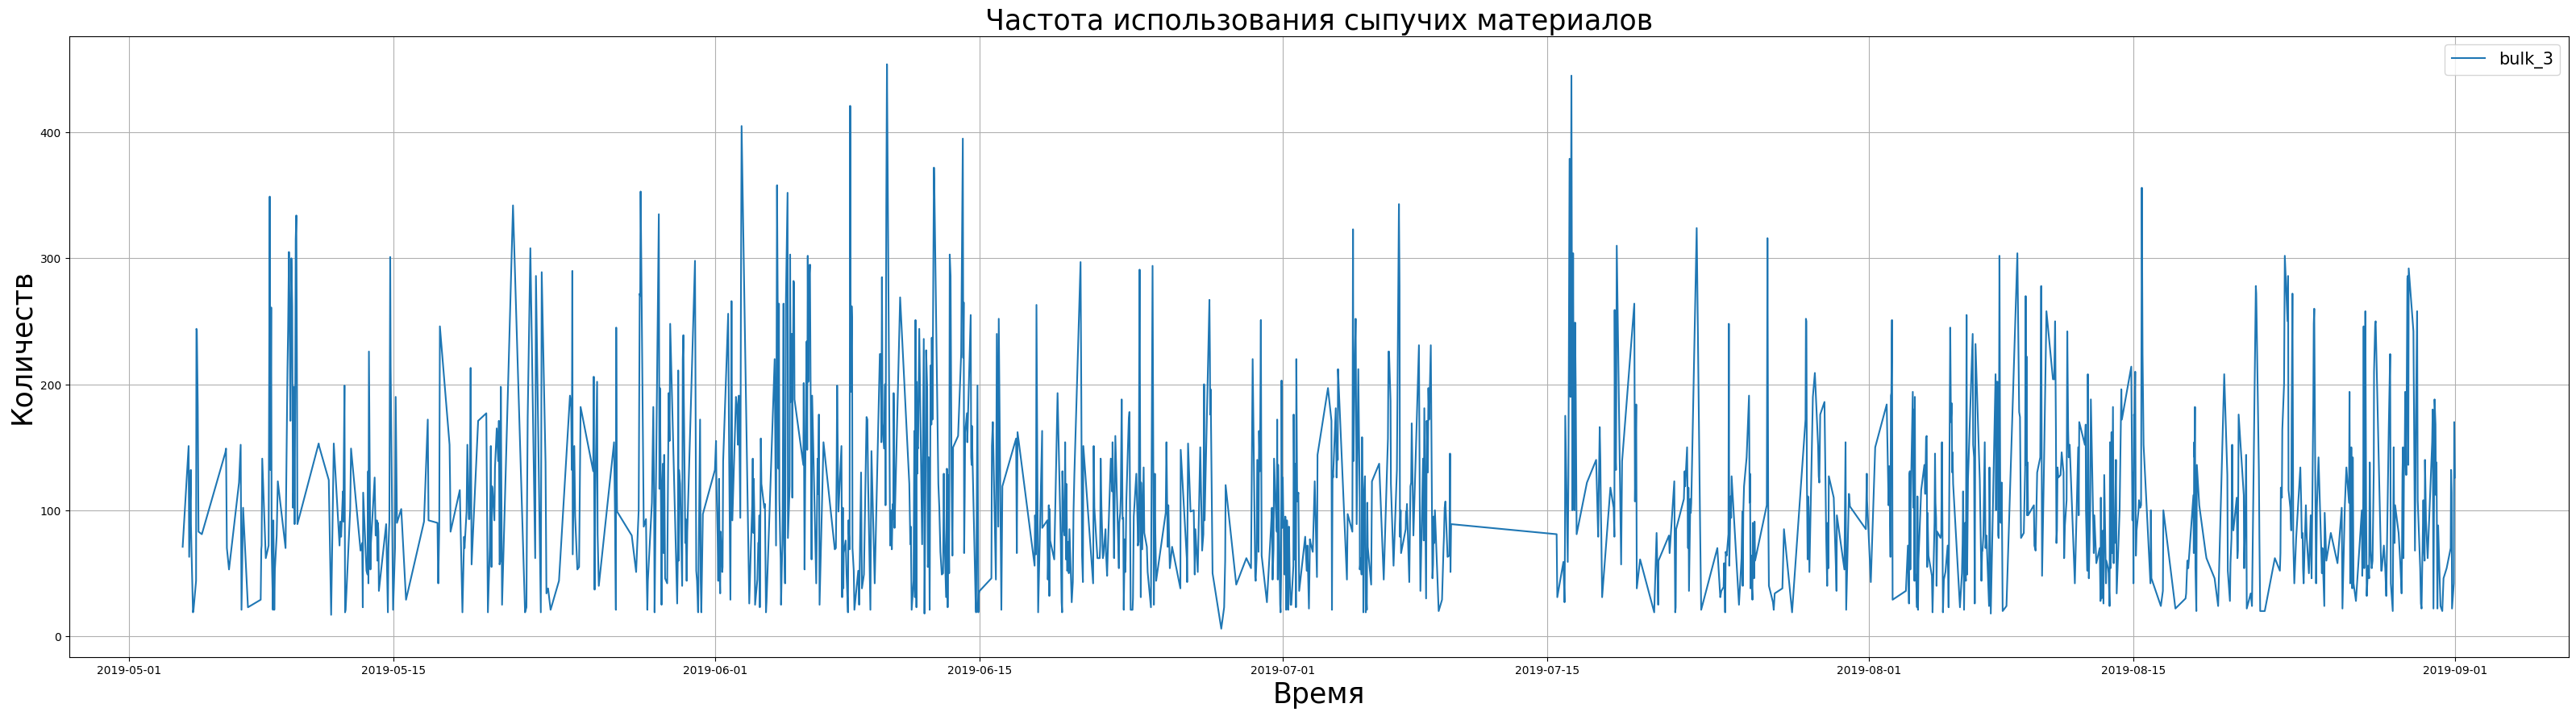

C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning

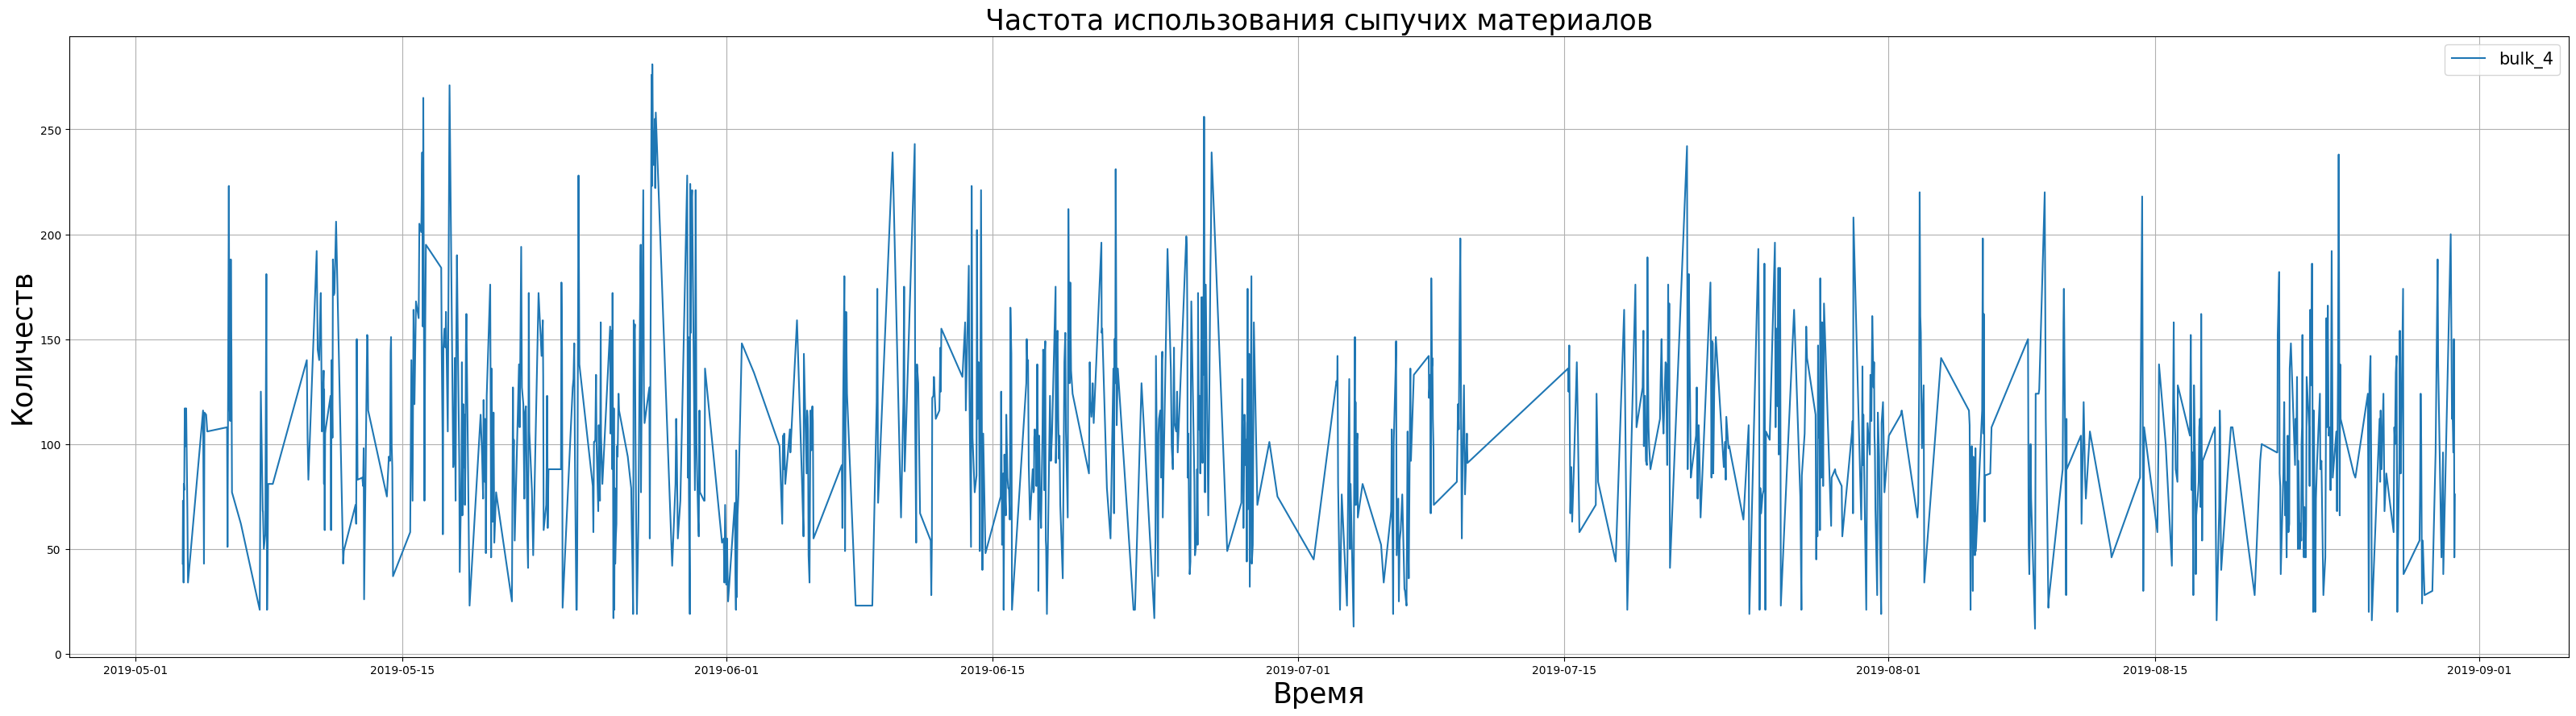

C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning

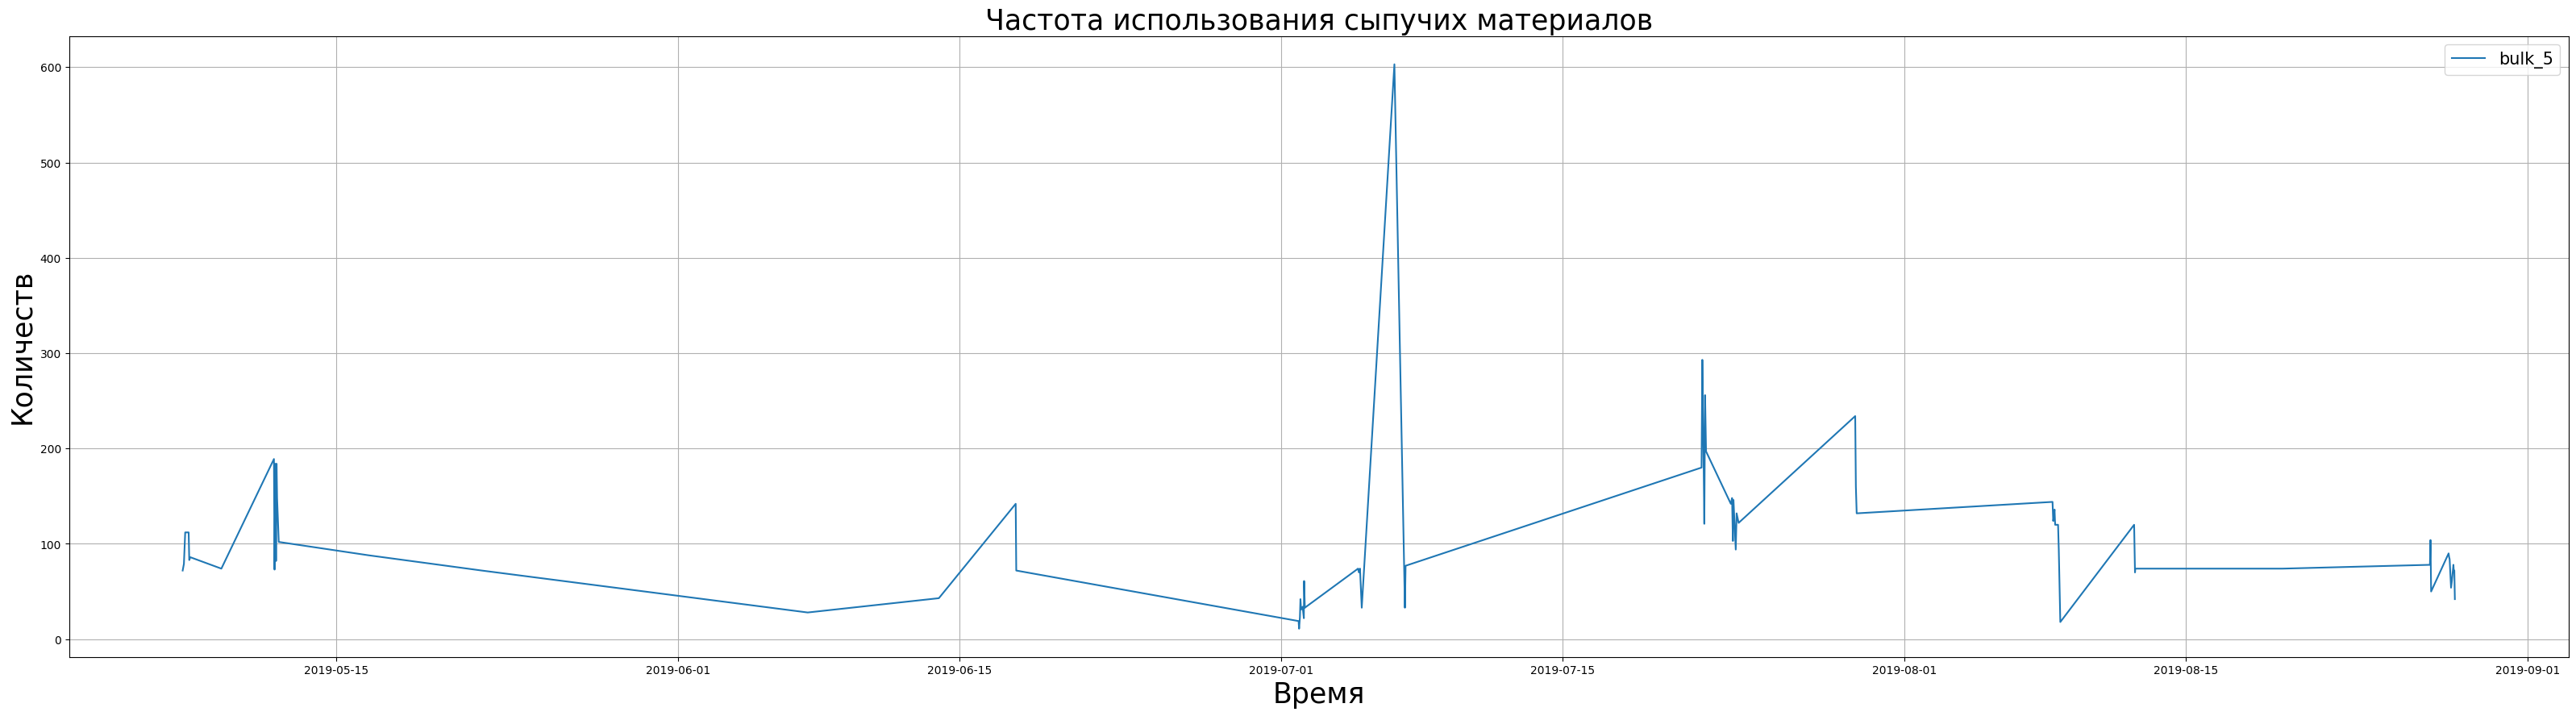

C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning

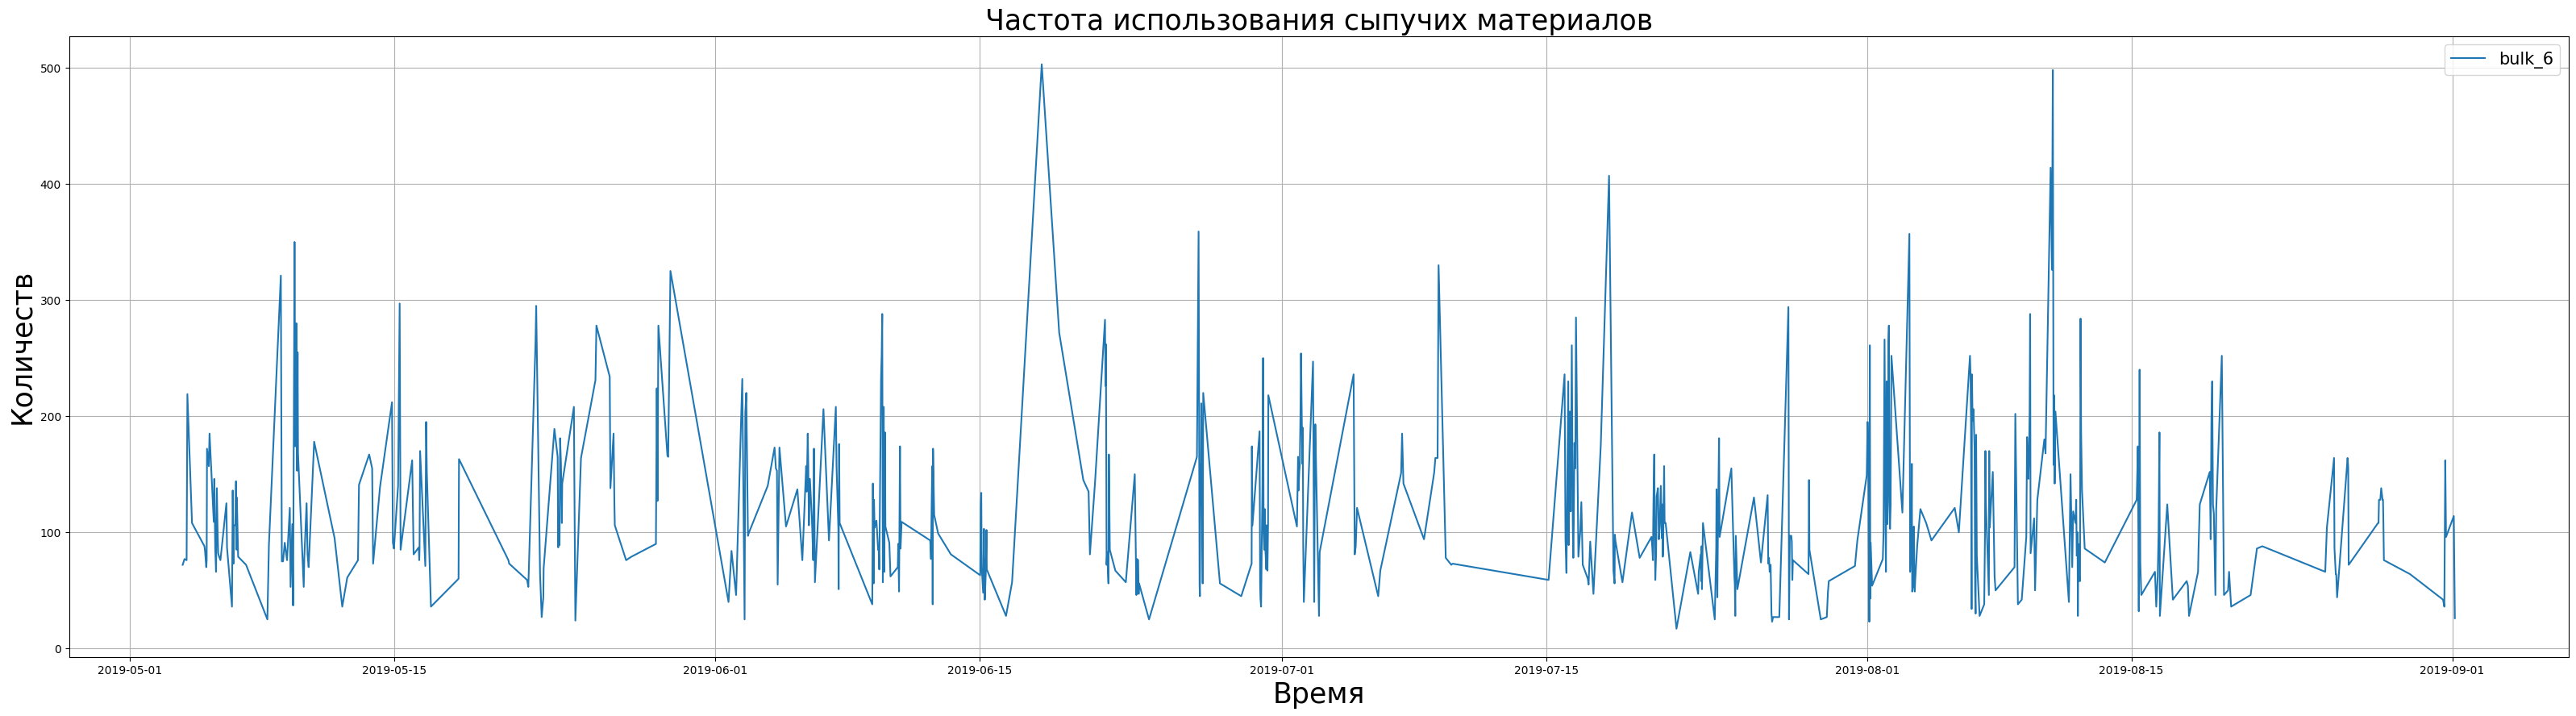

C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning

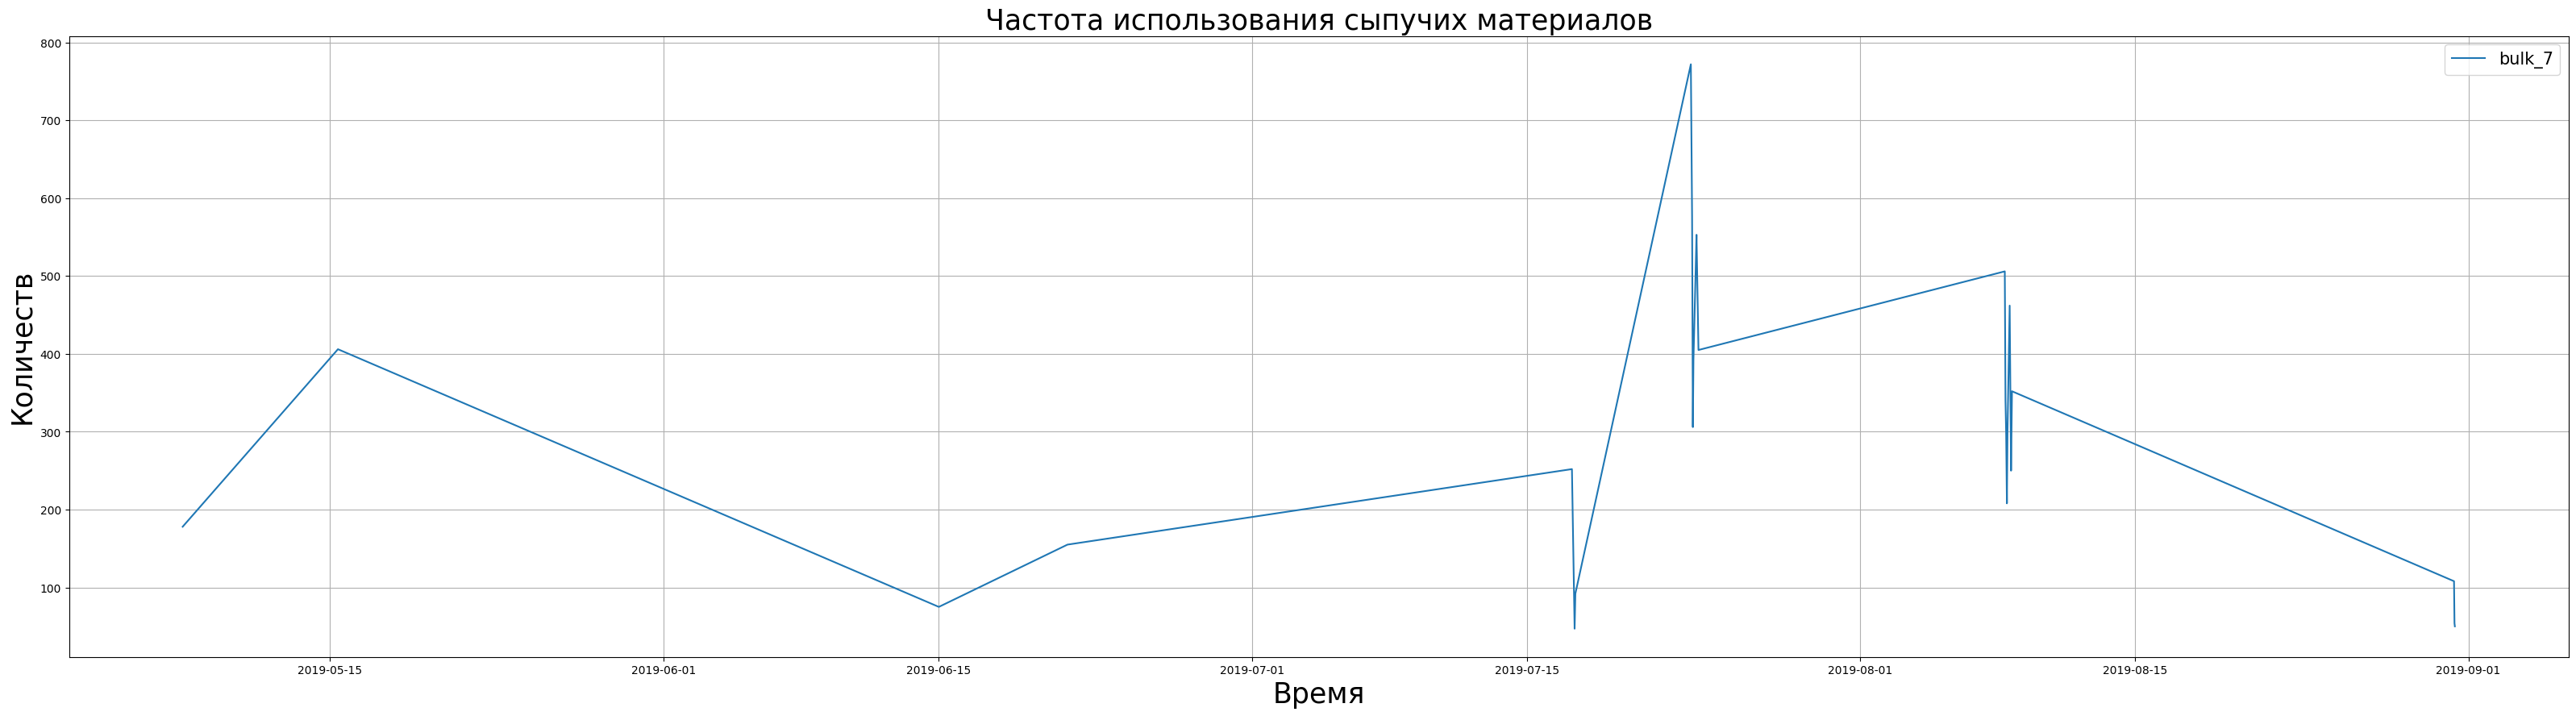

C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning

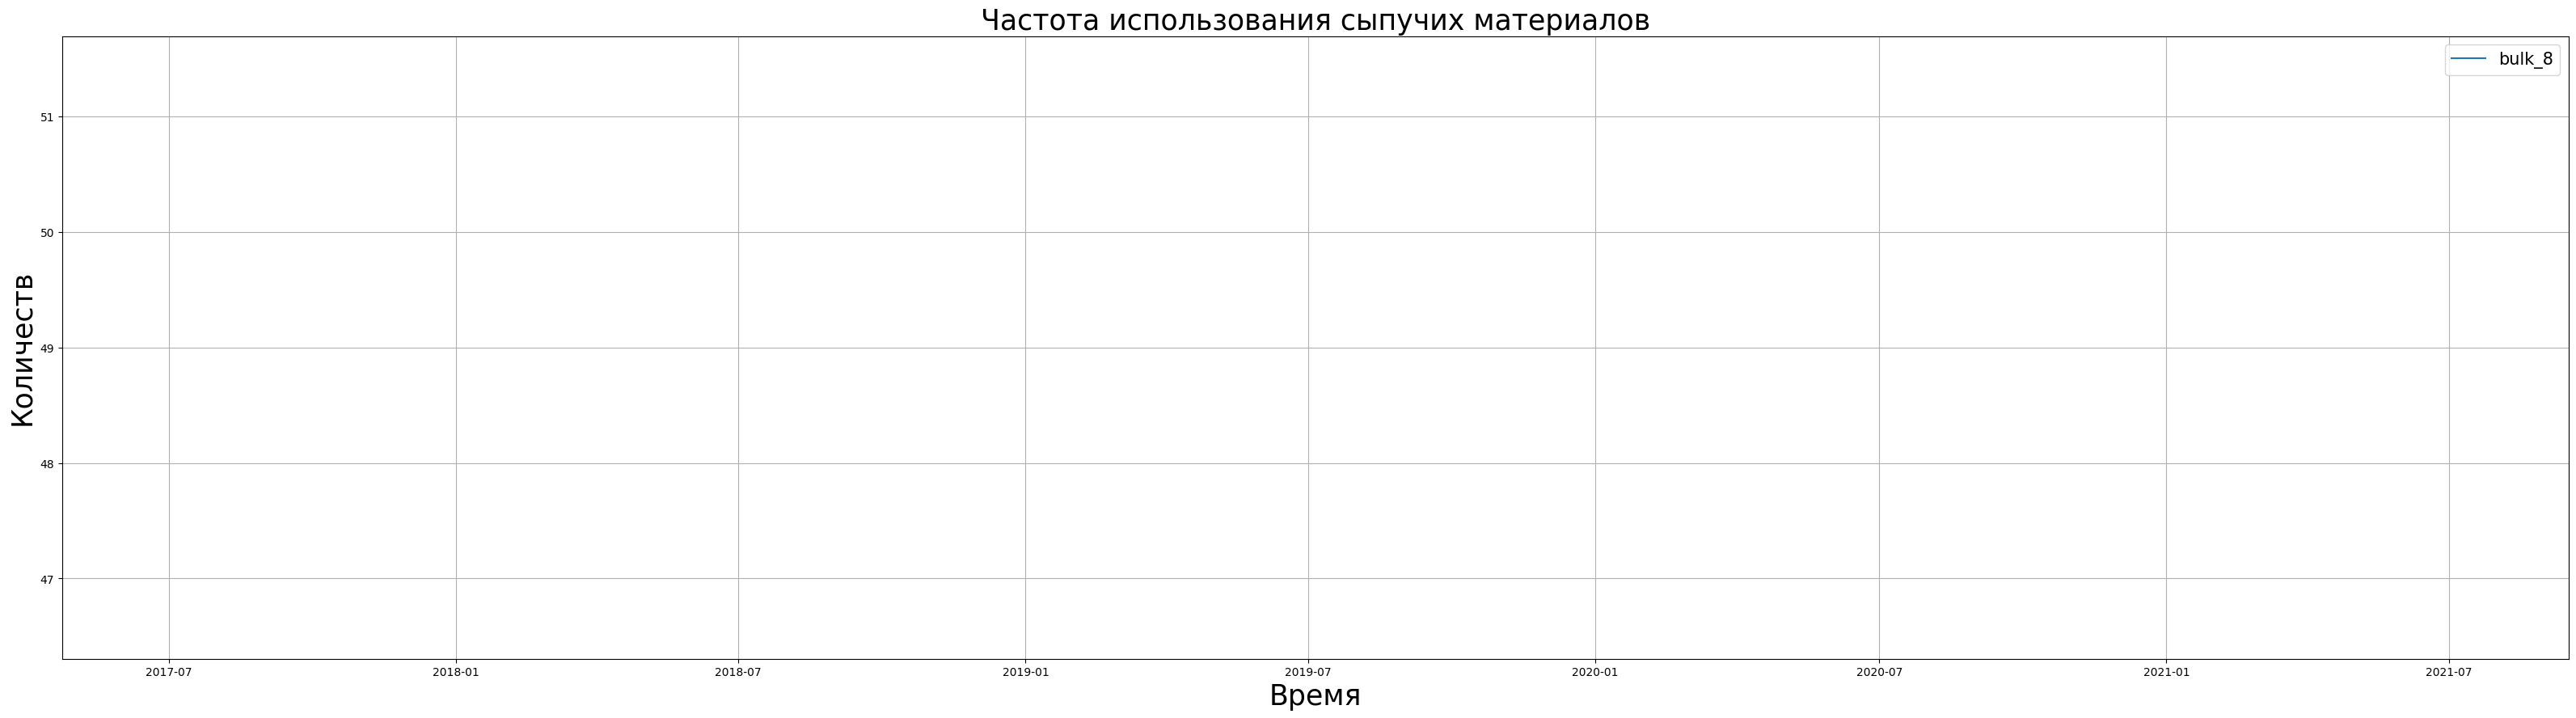

C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning

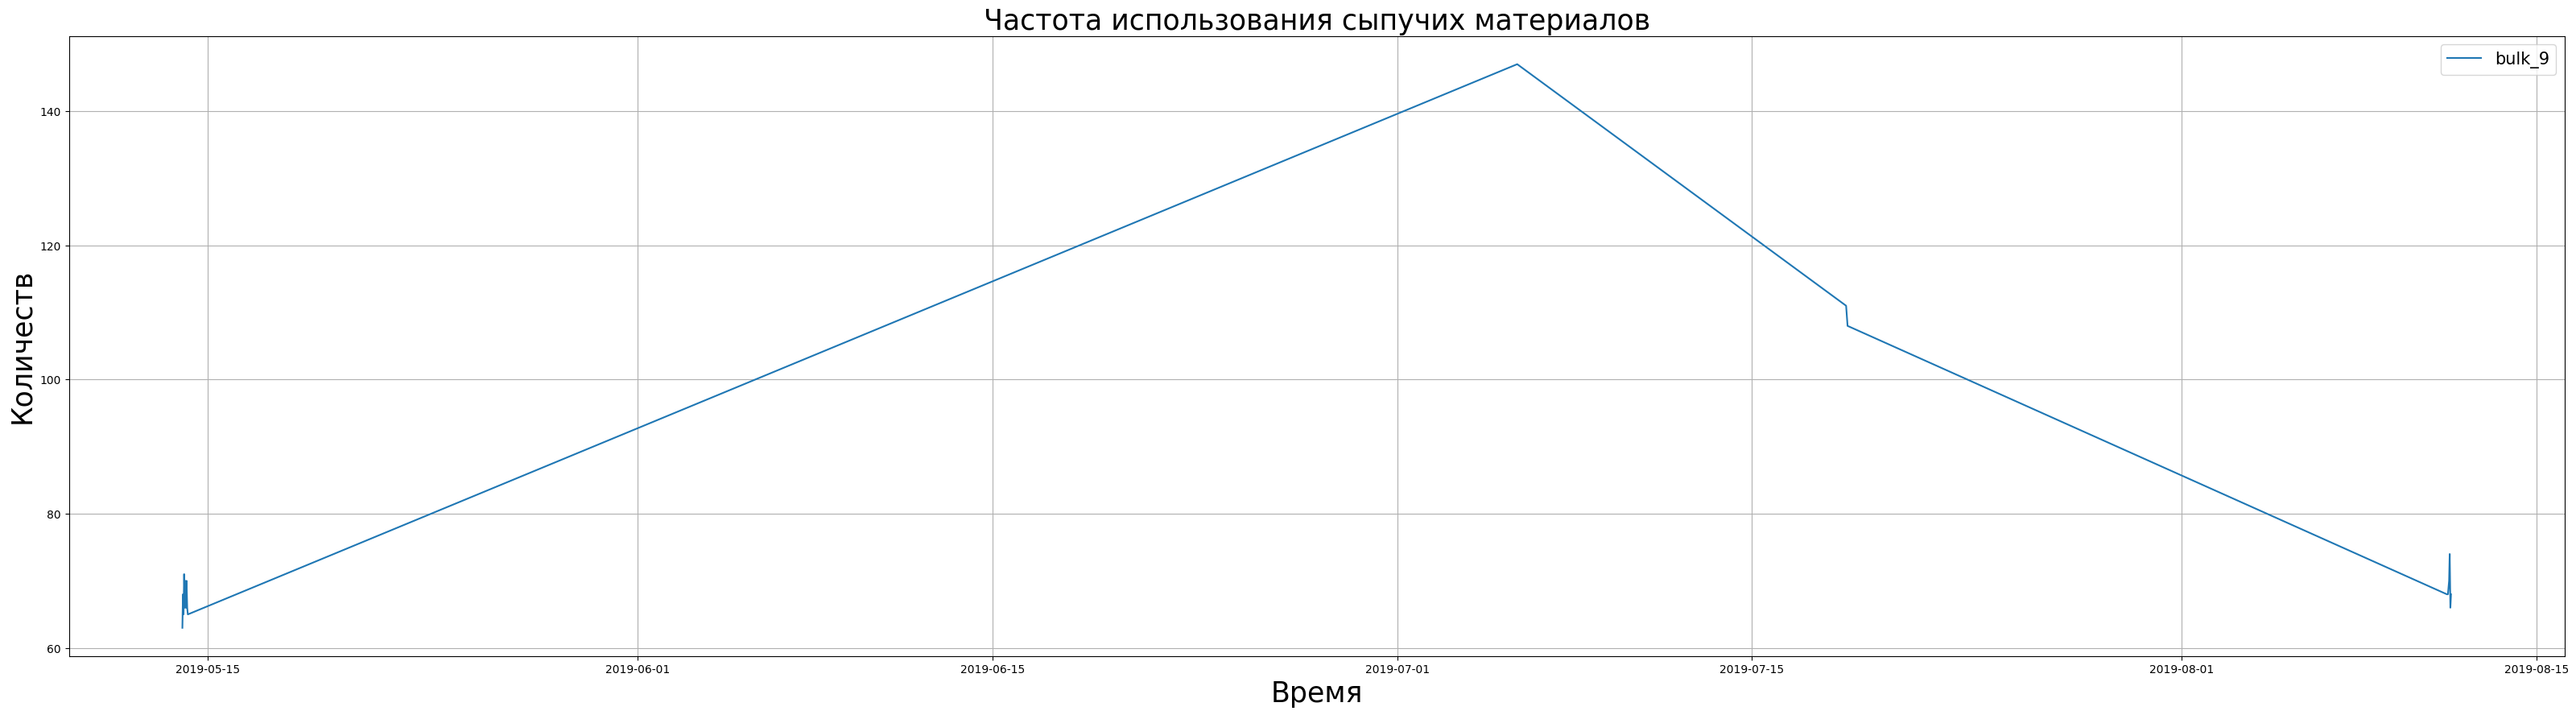

C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning

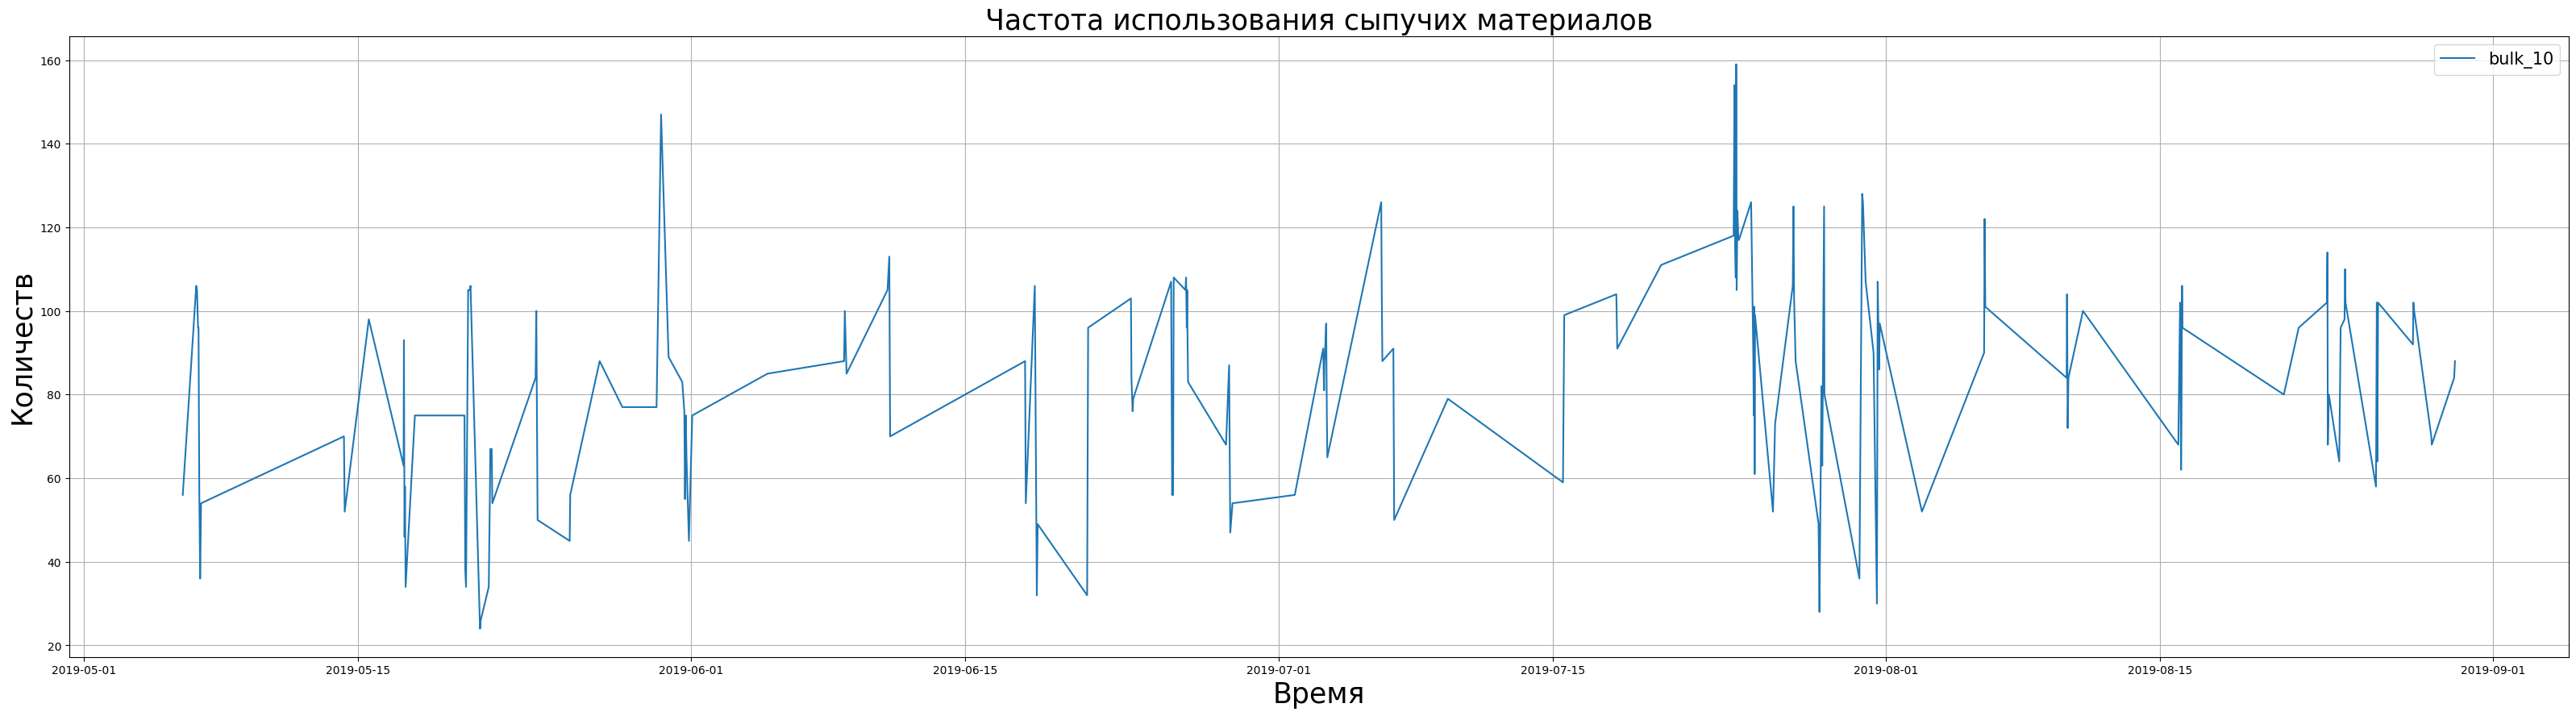

C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning

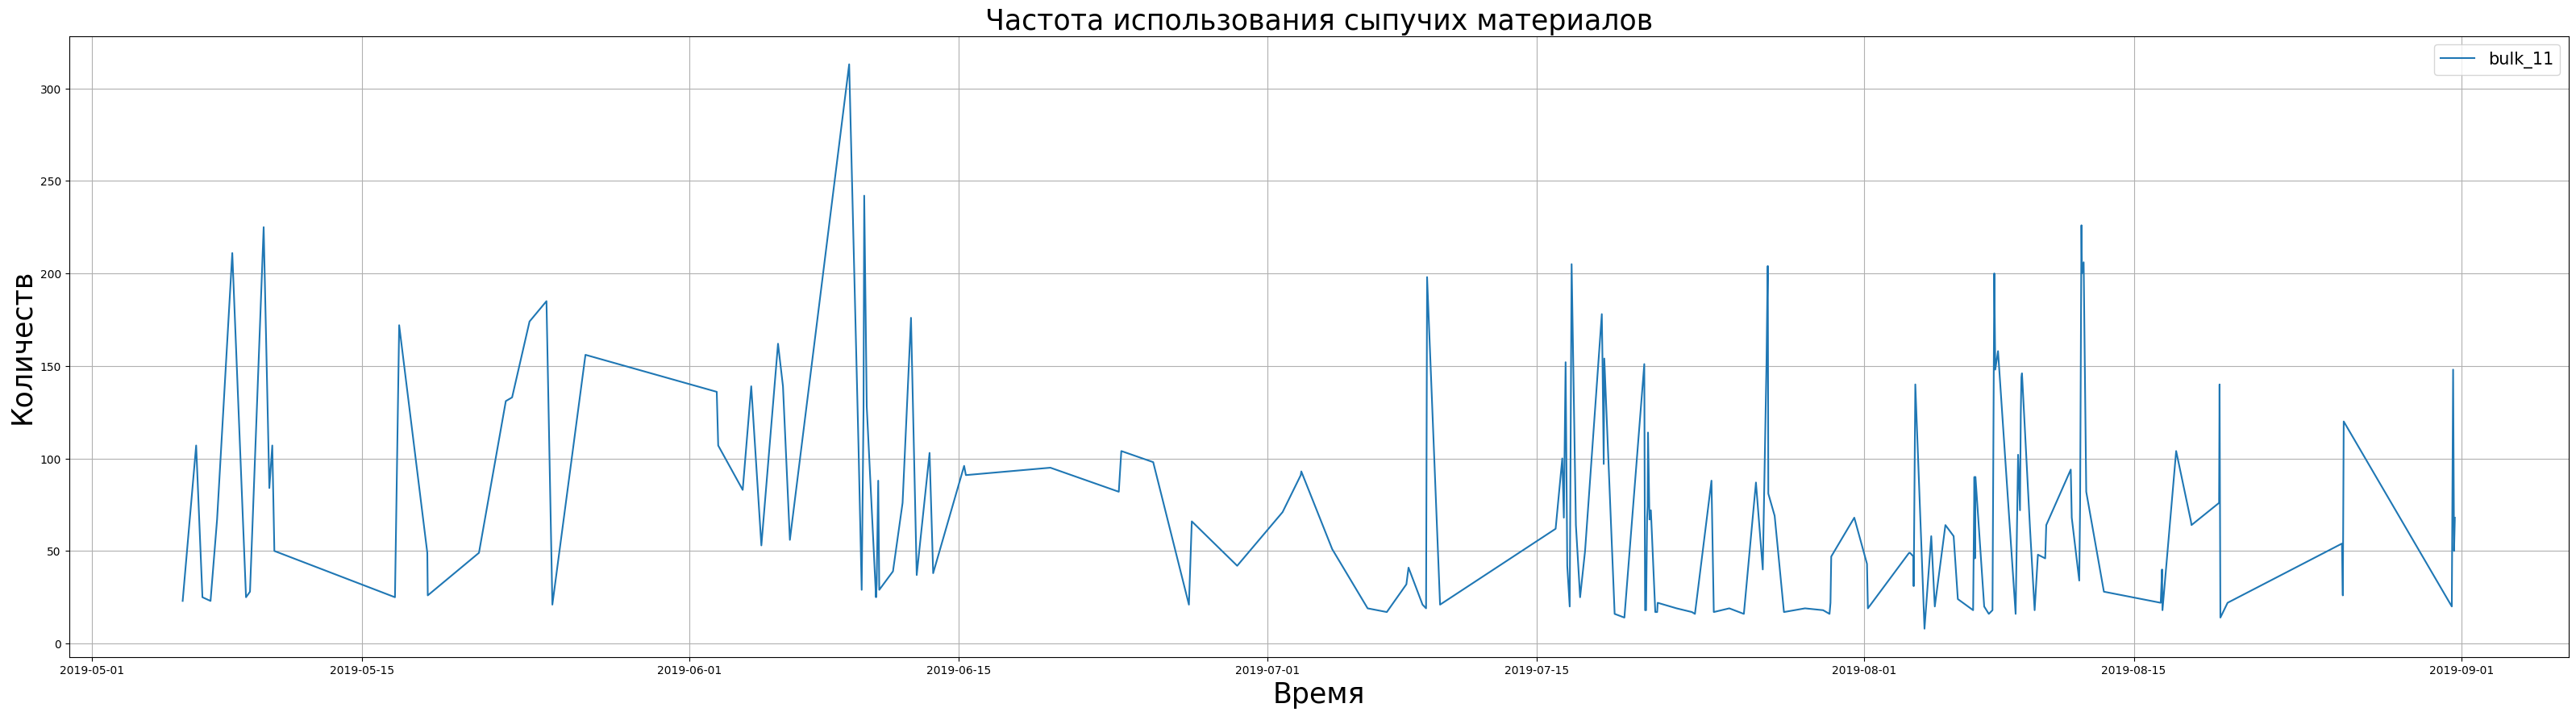

C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning

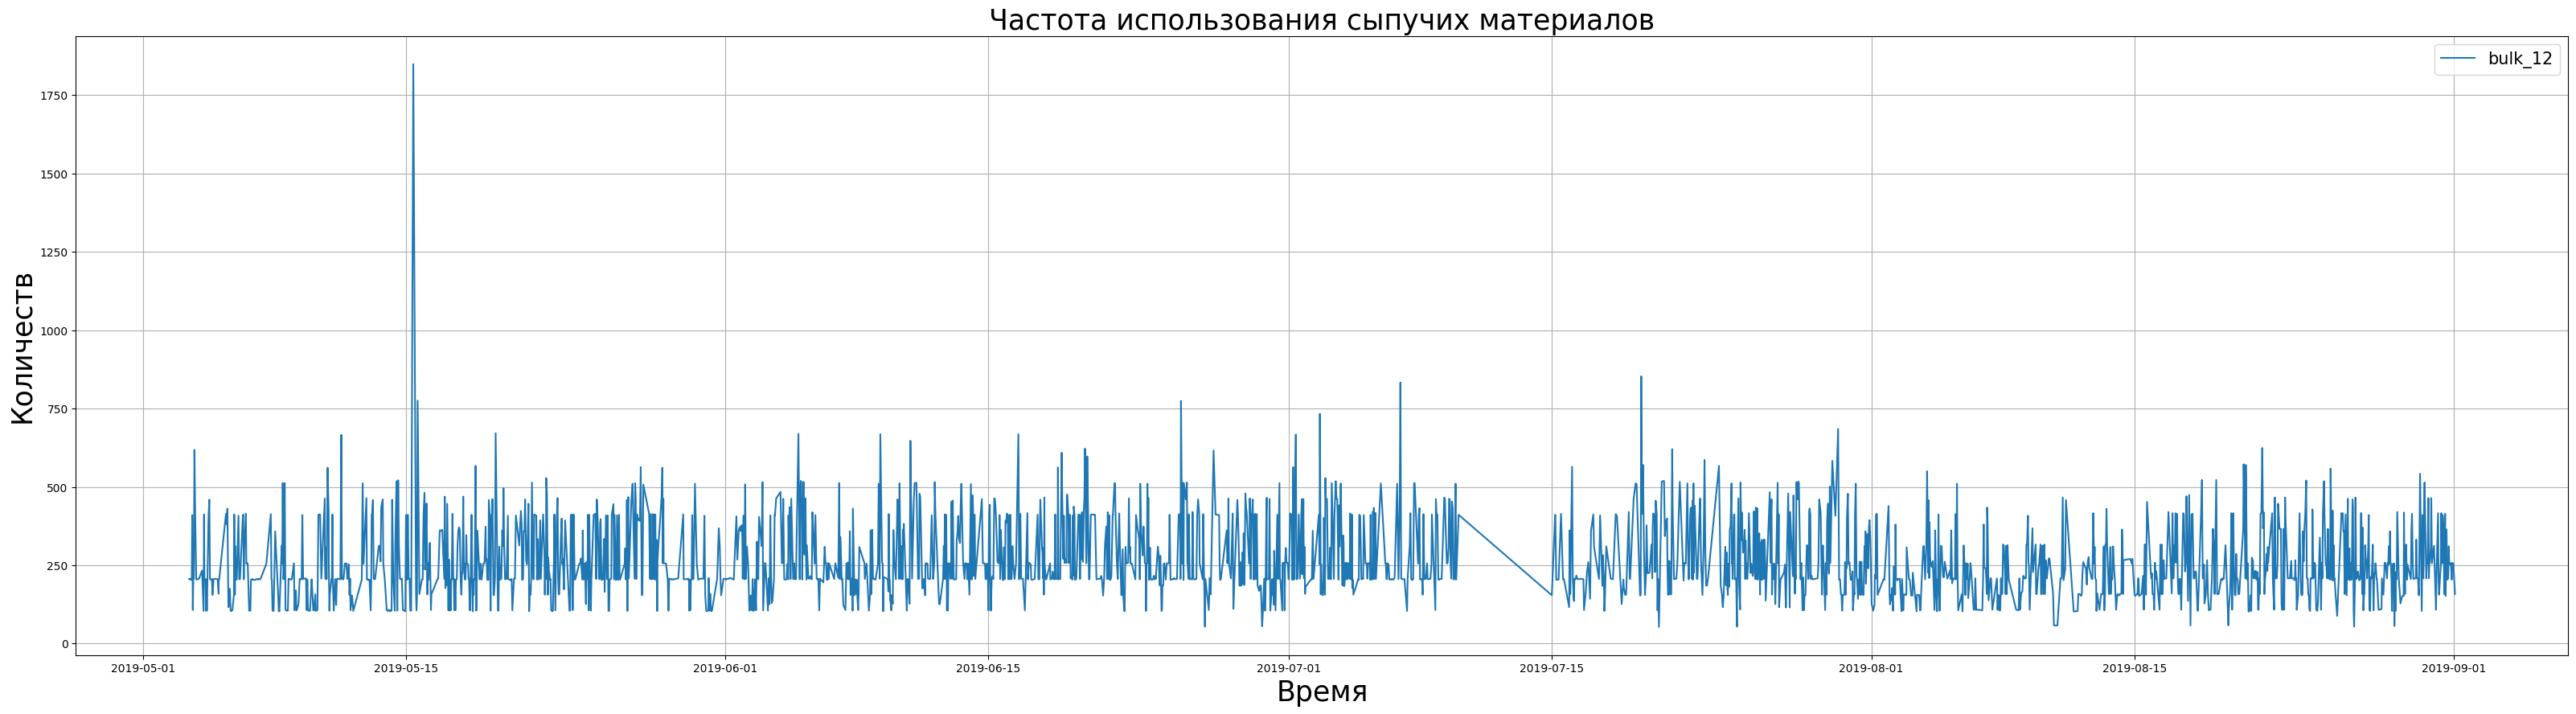

C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning

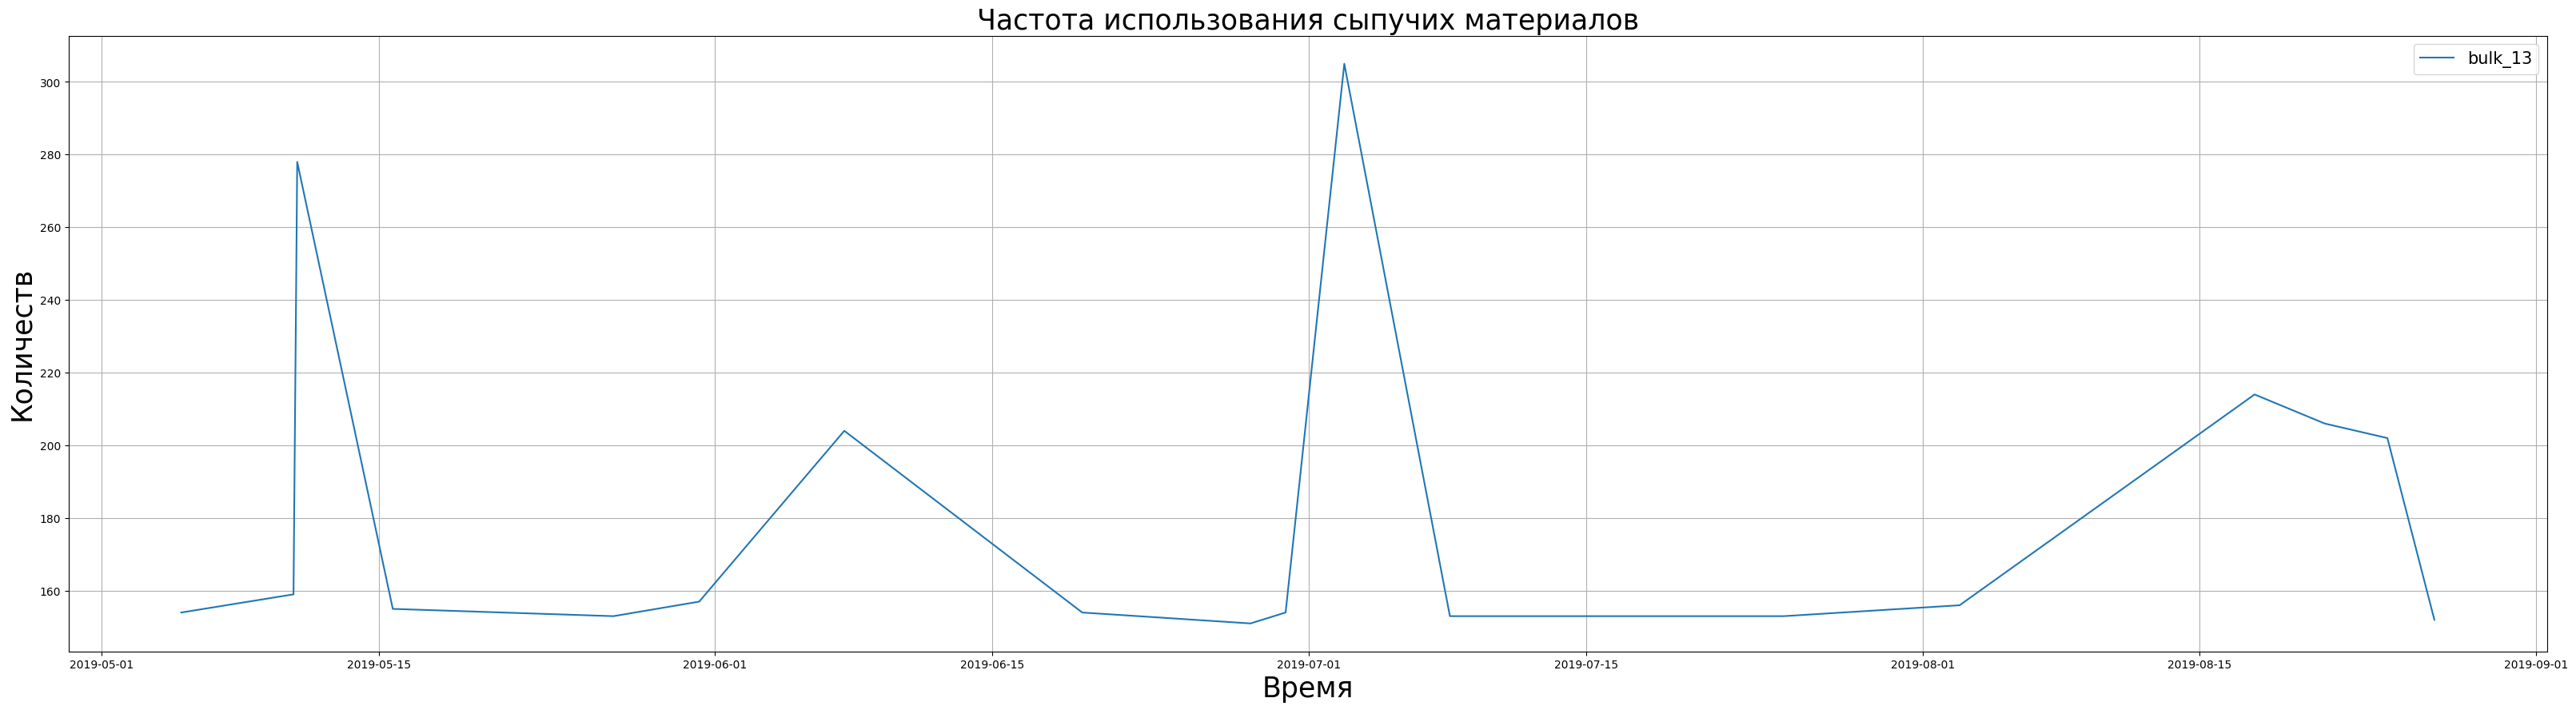

C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning

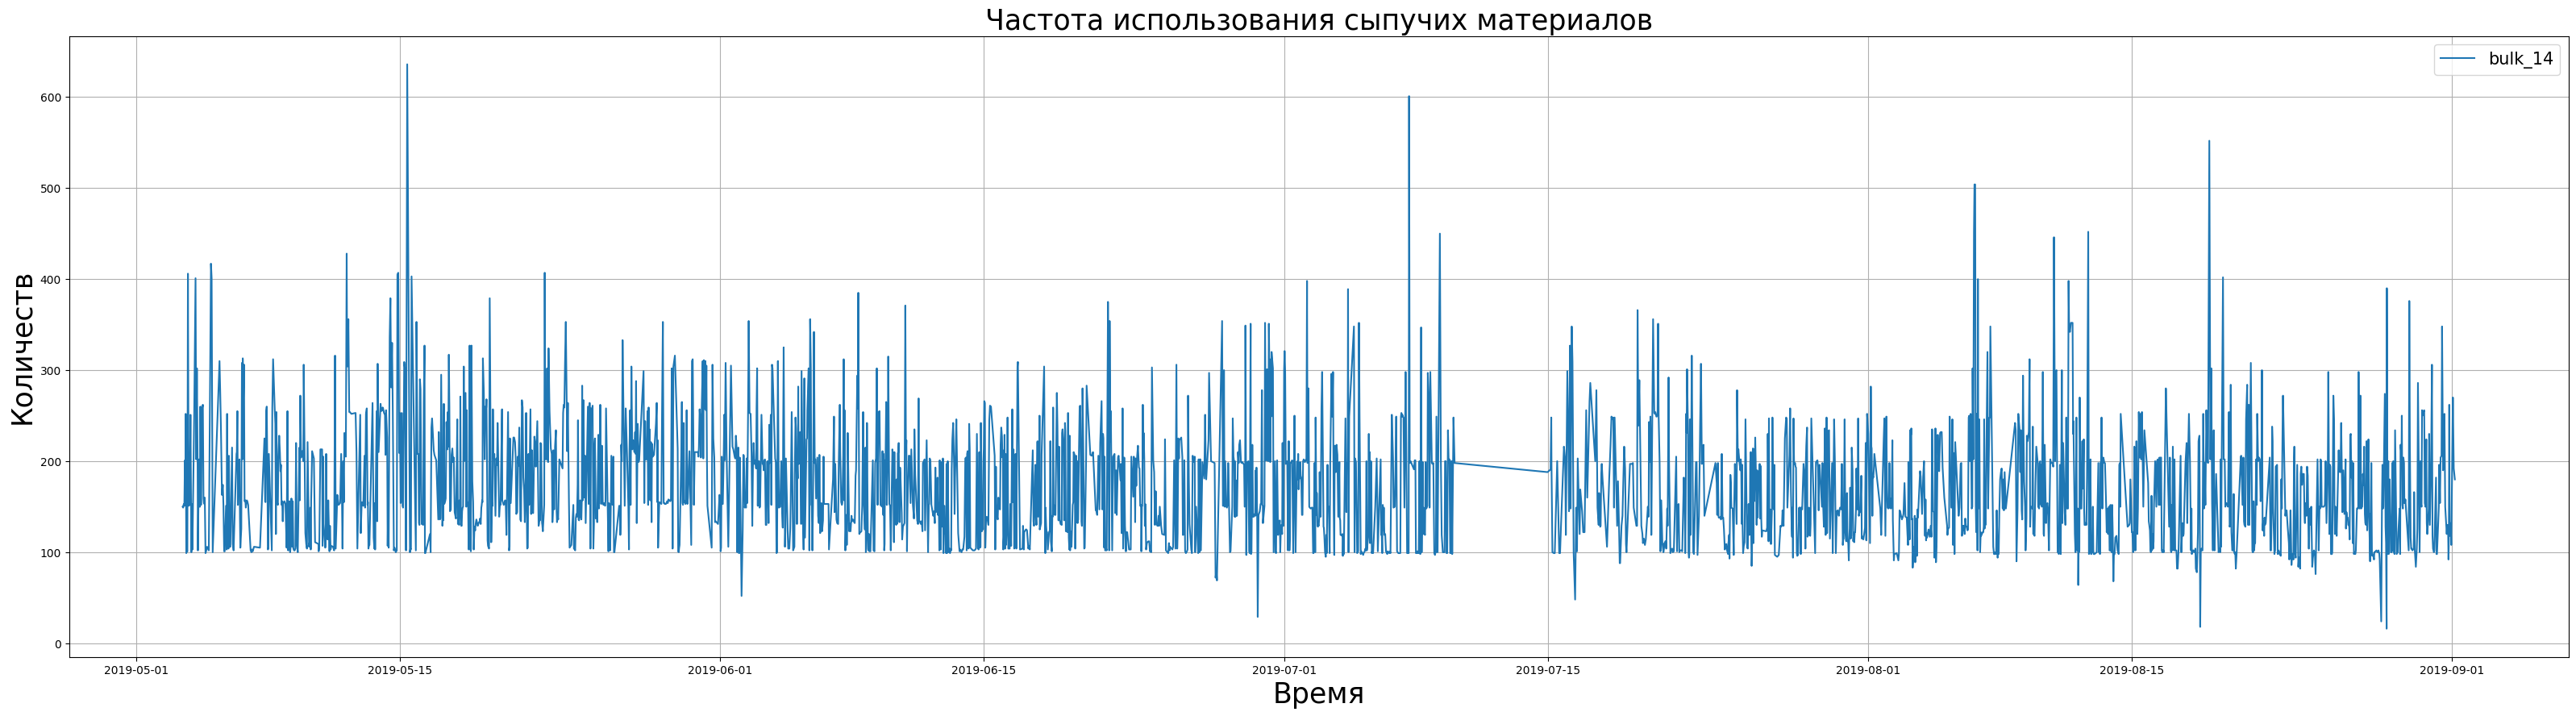

C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning

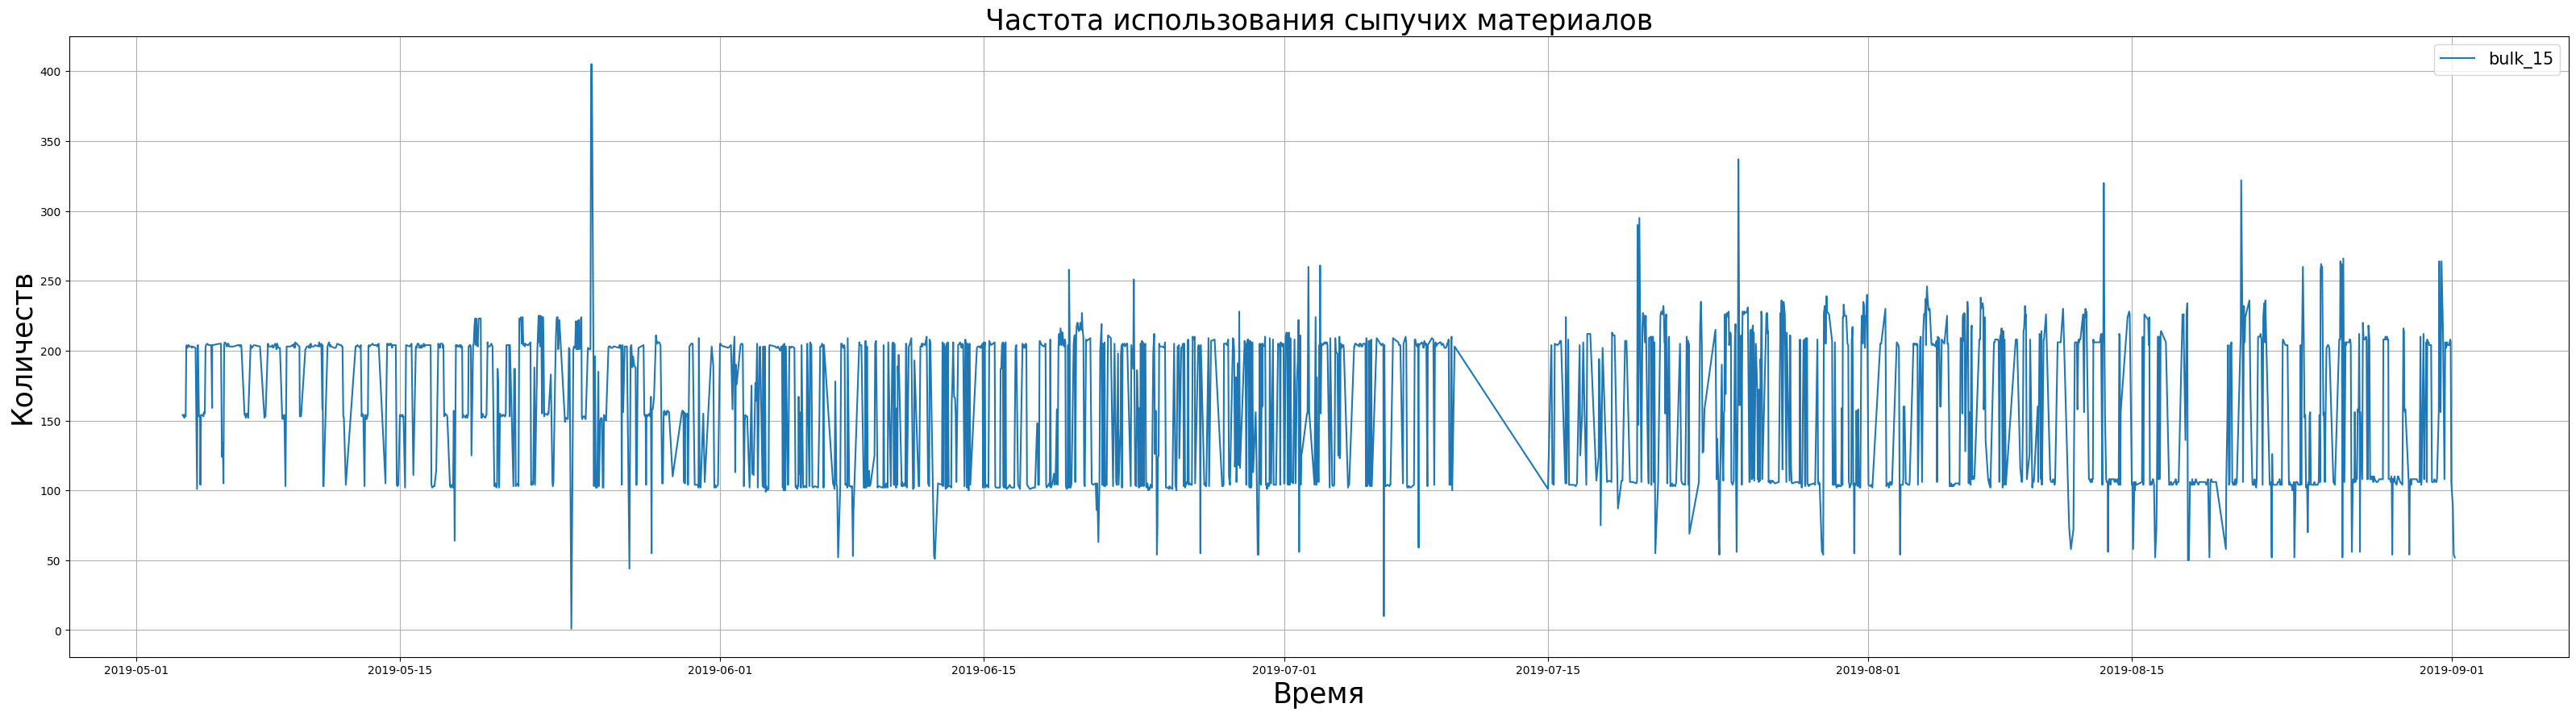

In [22]:
chart2(bulk_splice,'Частота использования сыпучих материалов','Время','Количеств')

C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


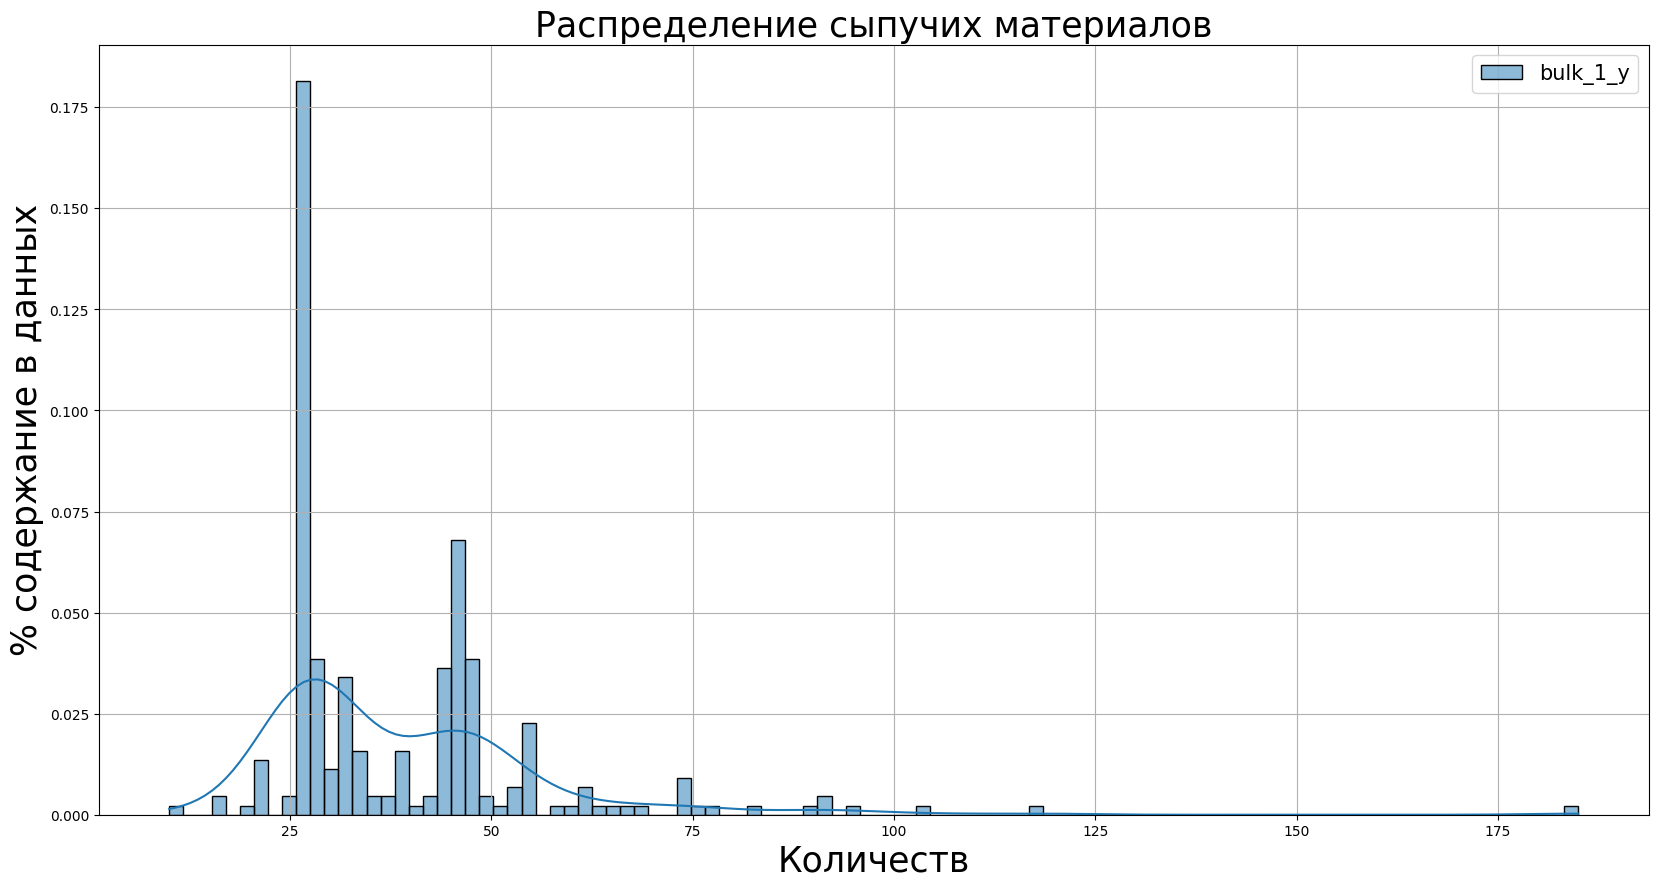

C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


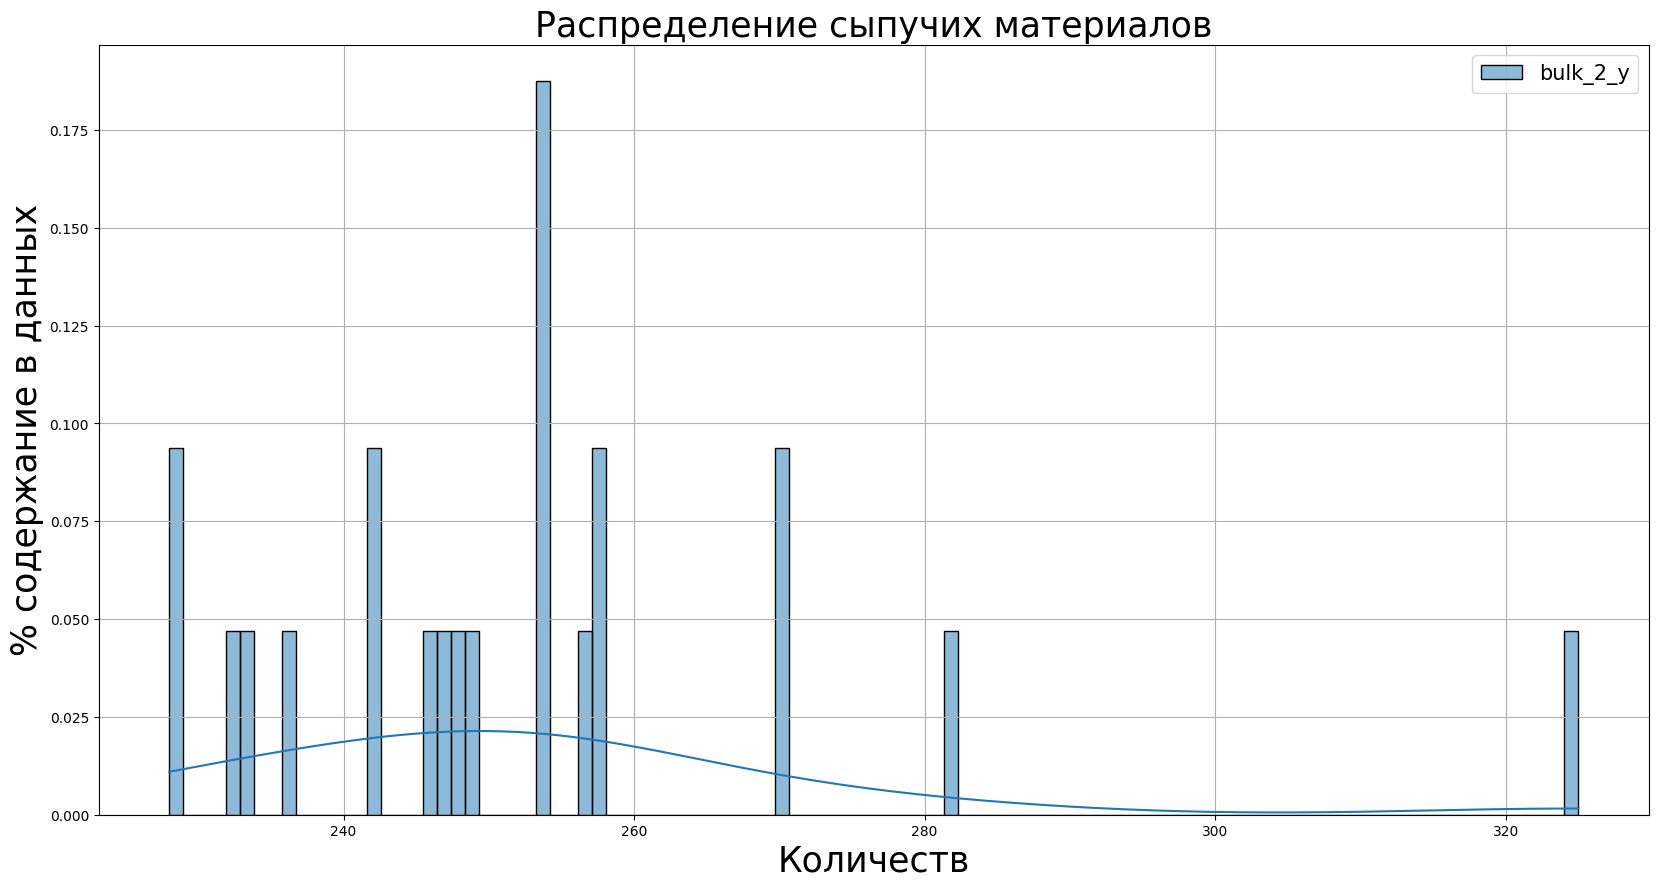

C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


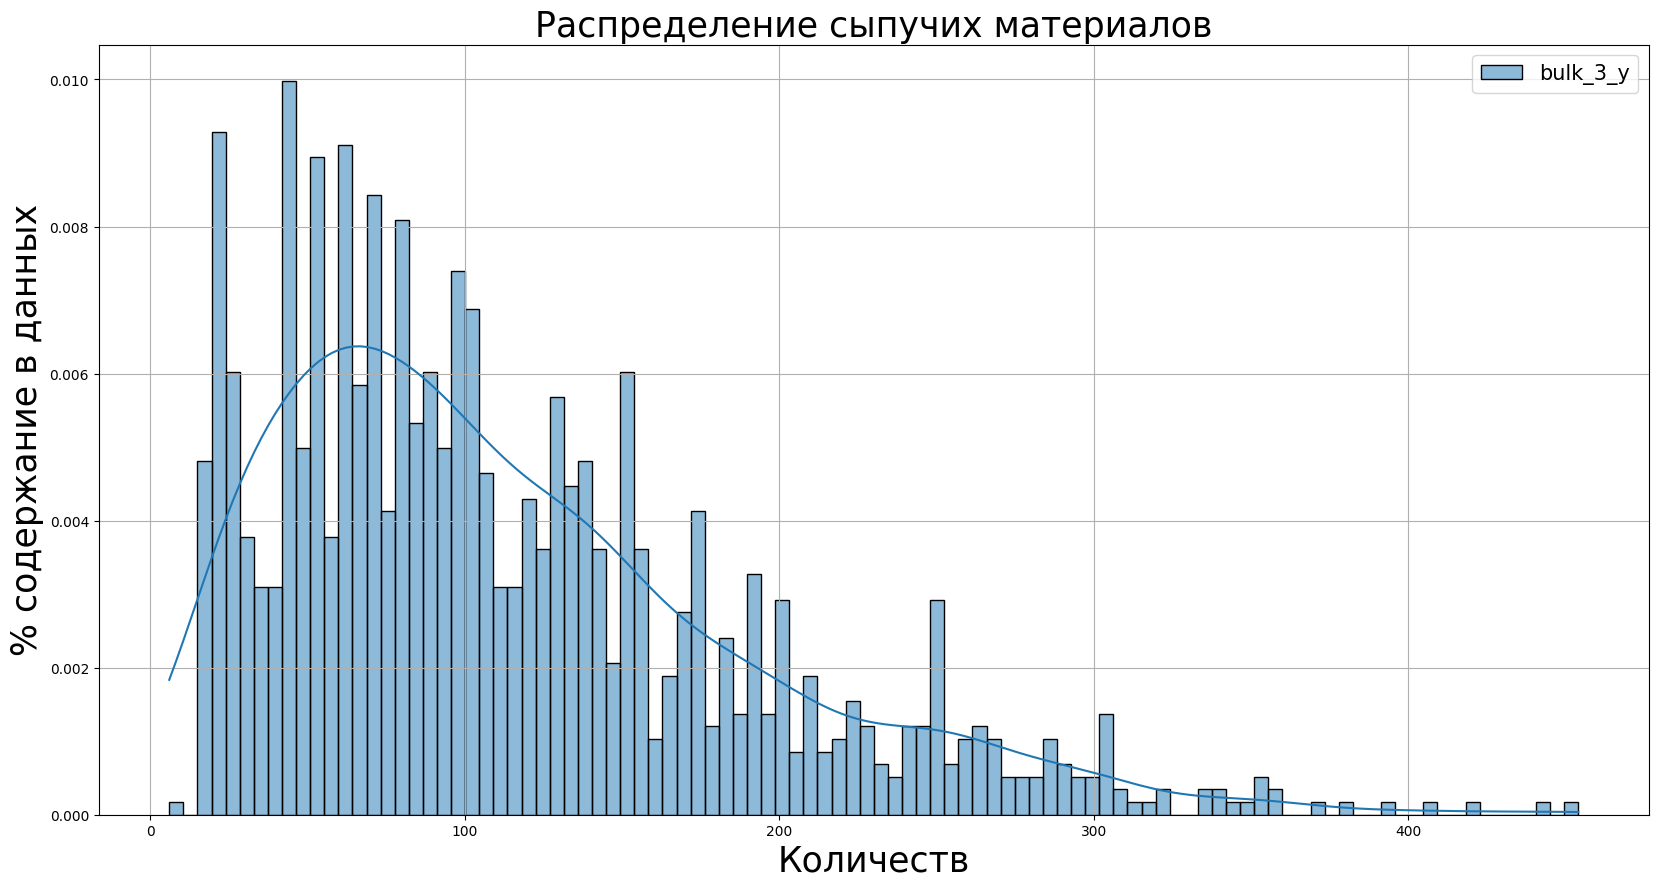

C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


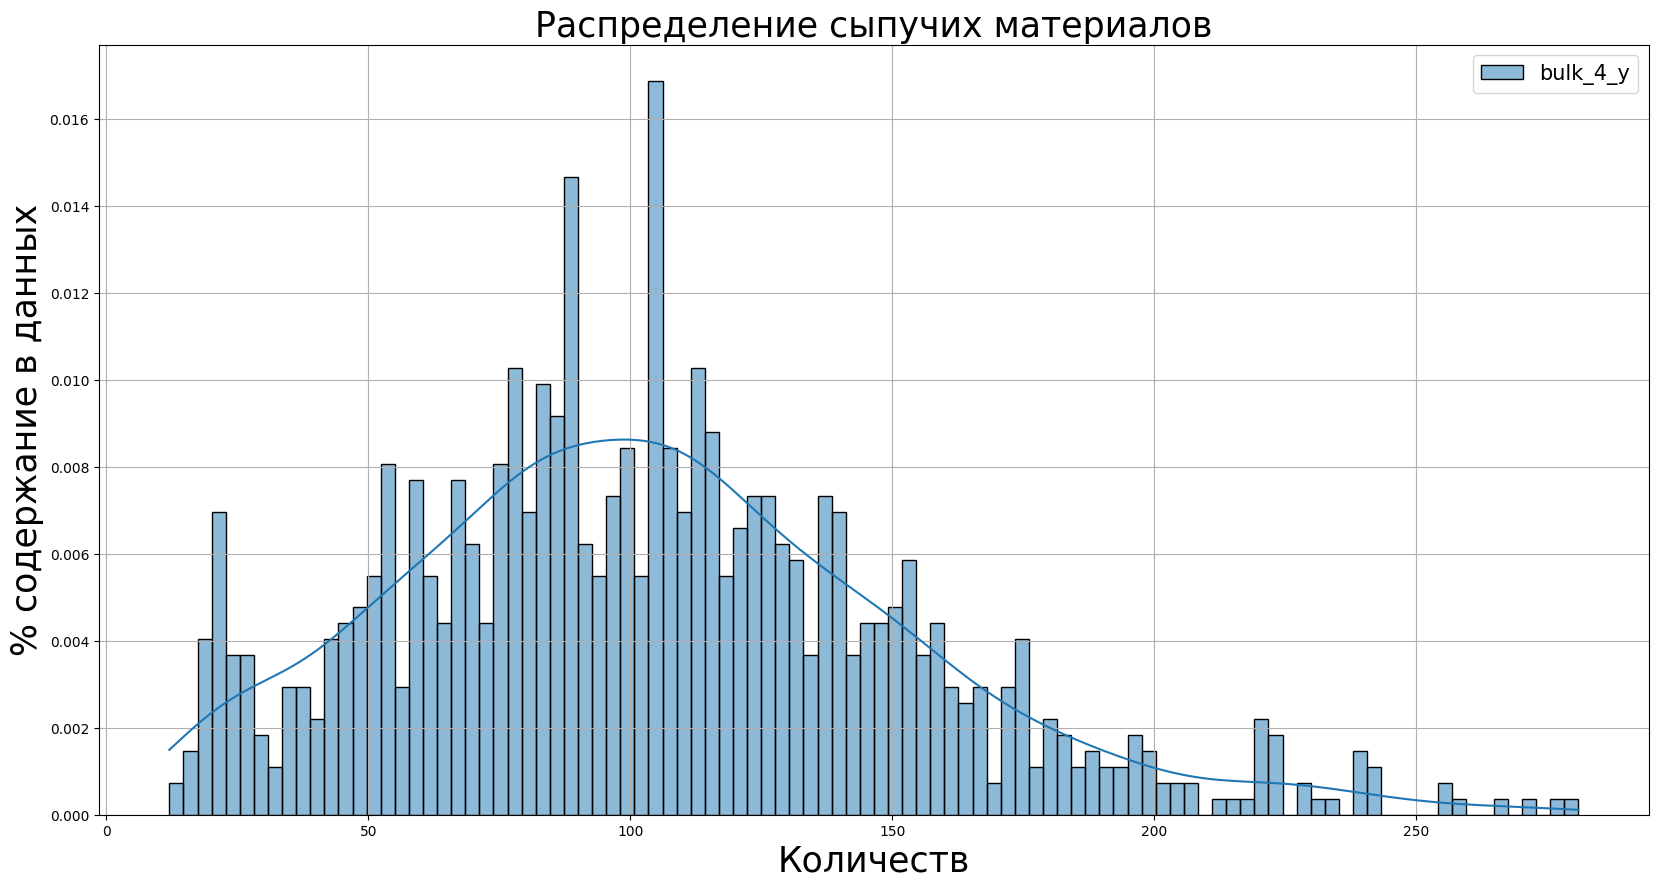

C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


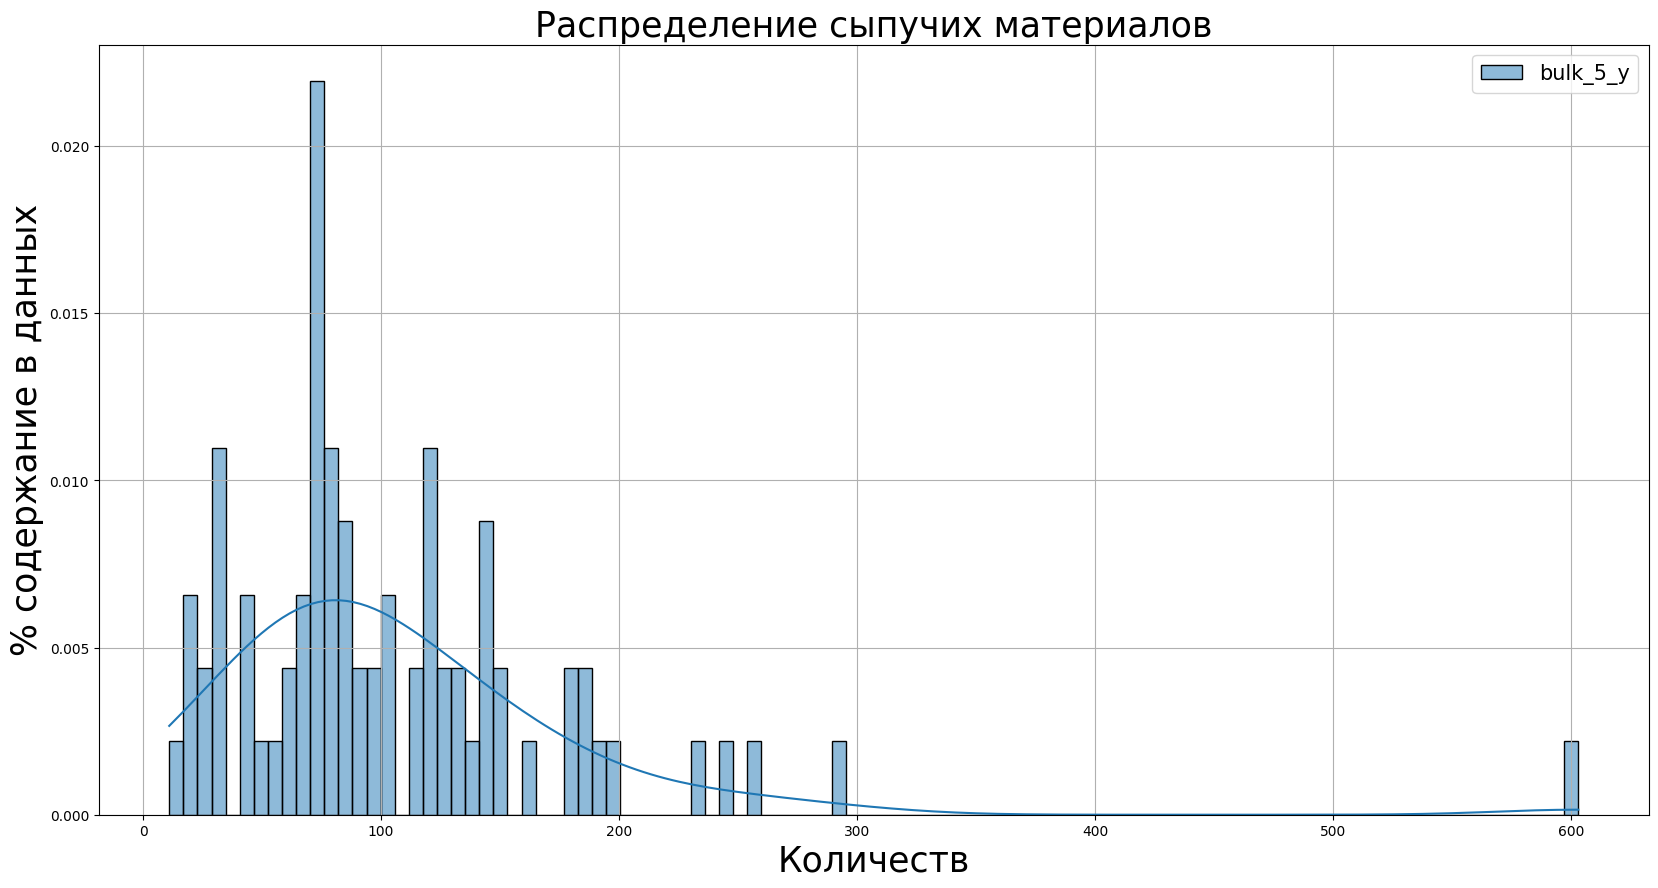

C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


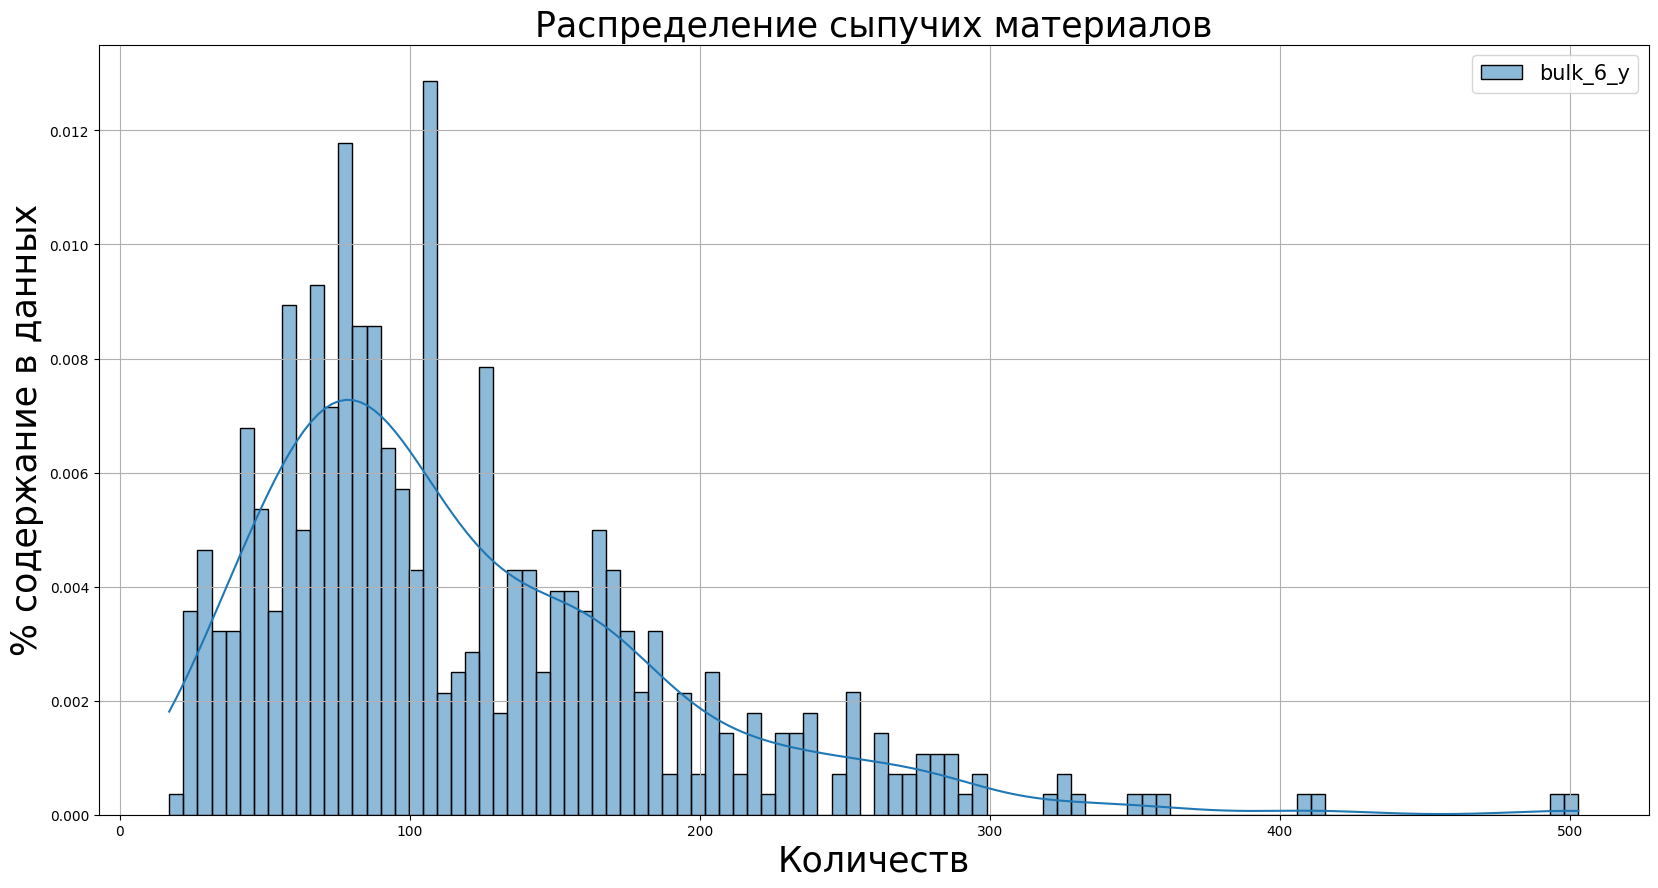

C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


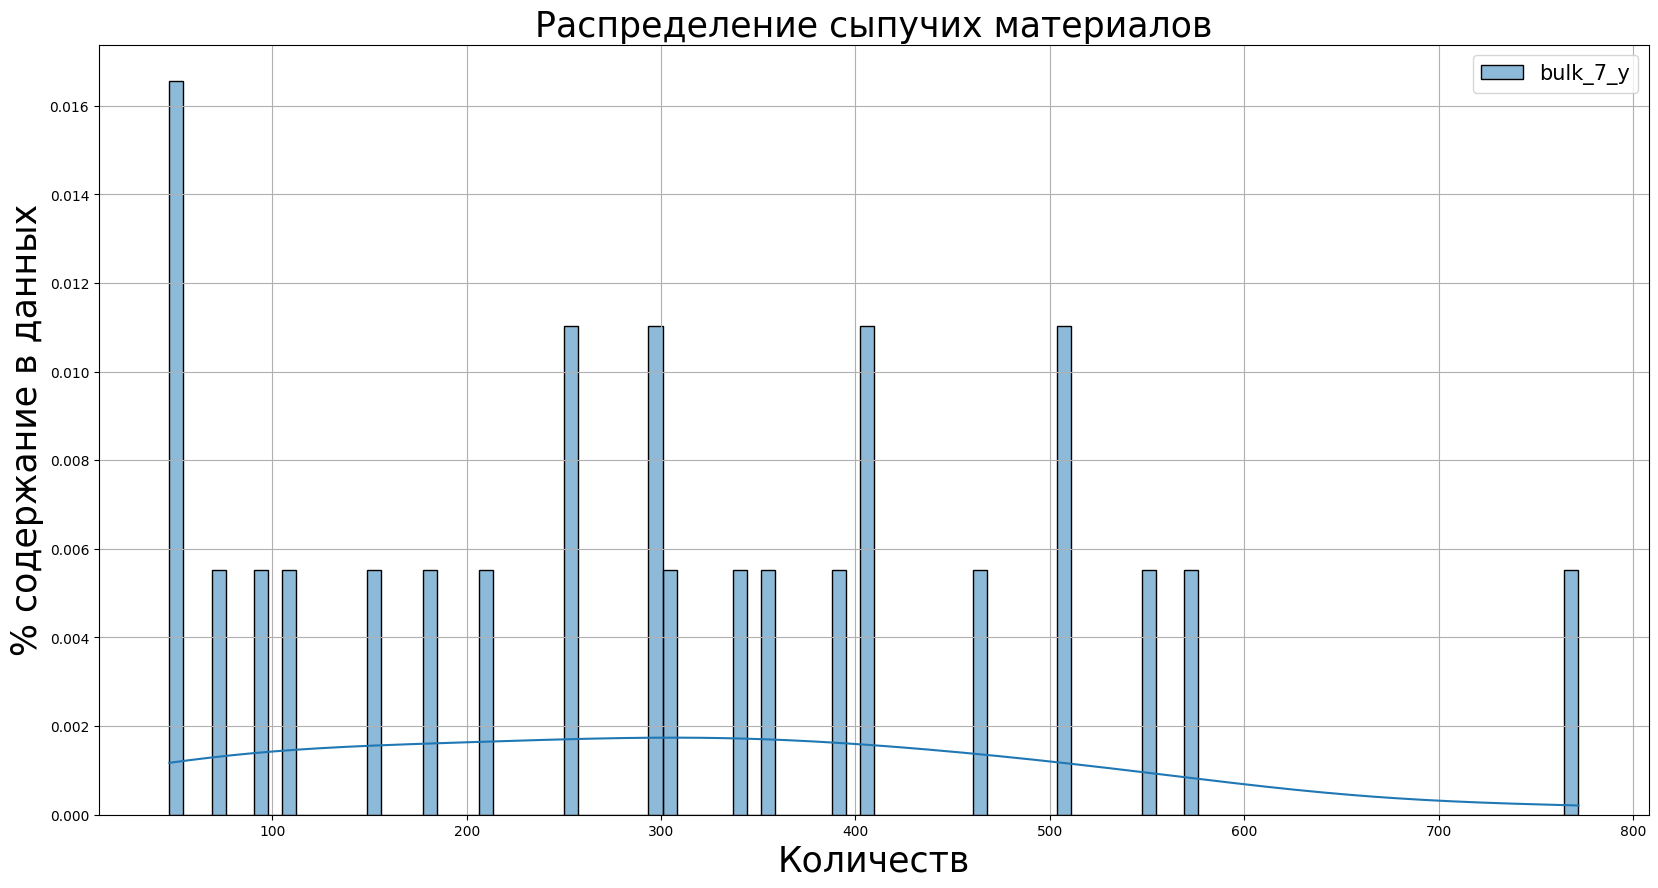

C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


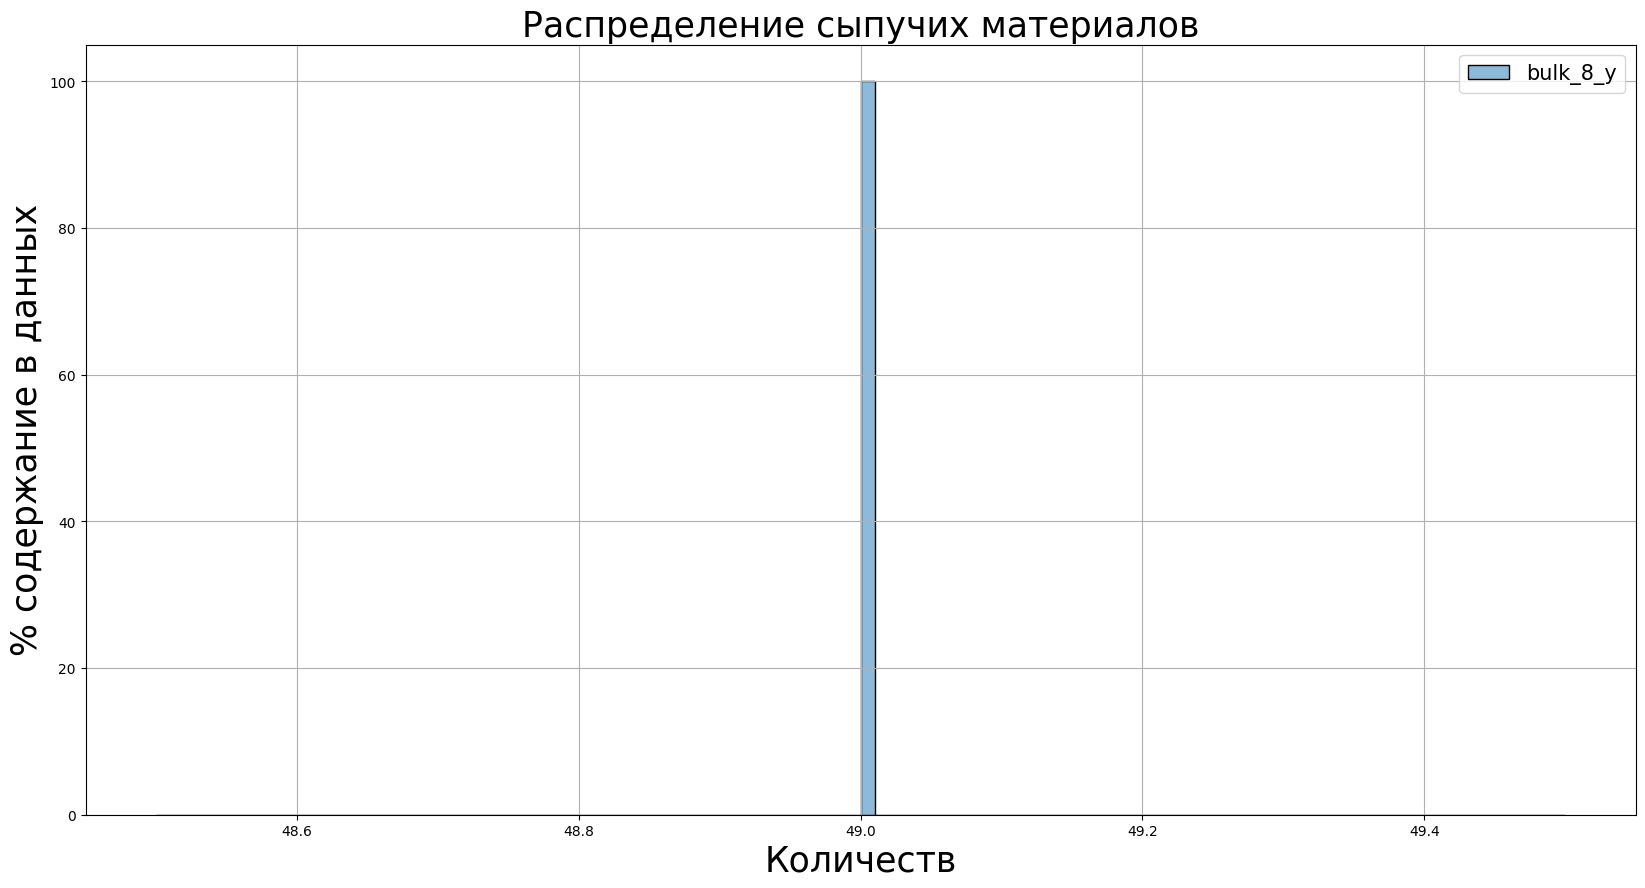

C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


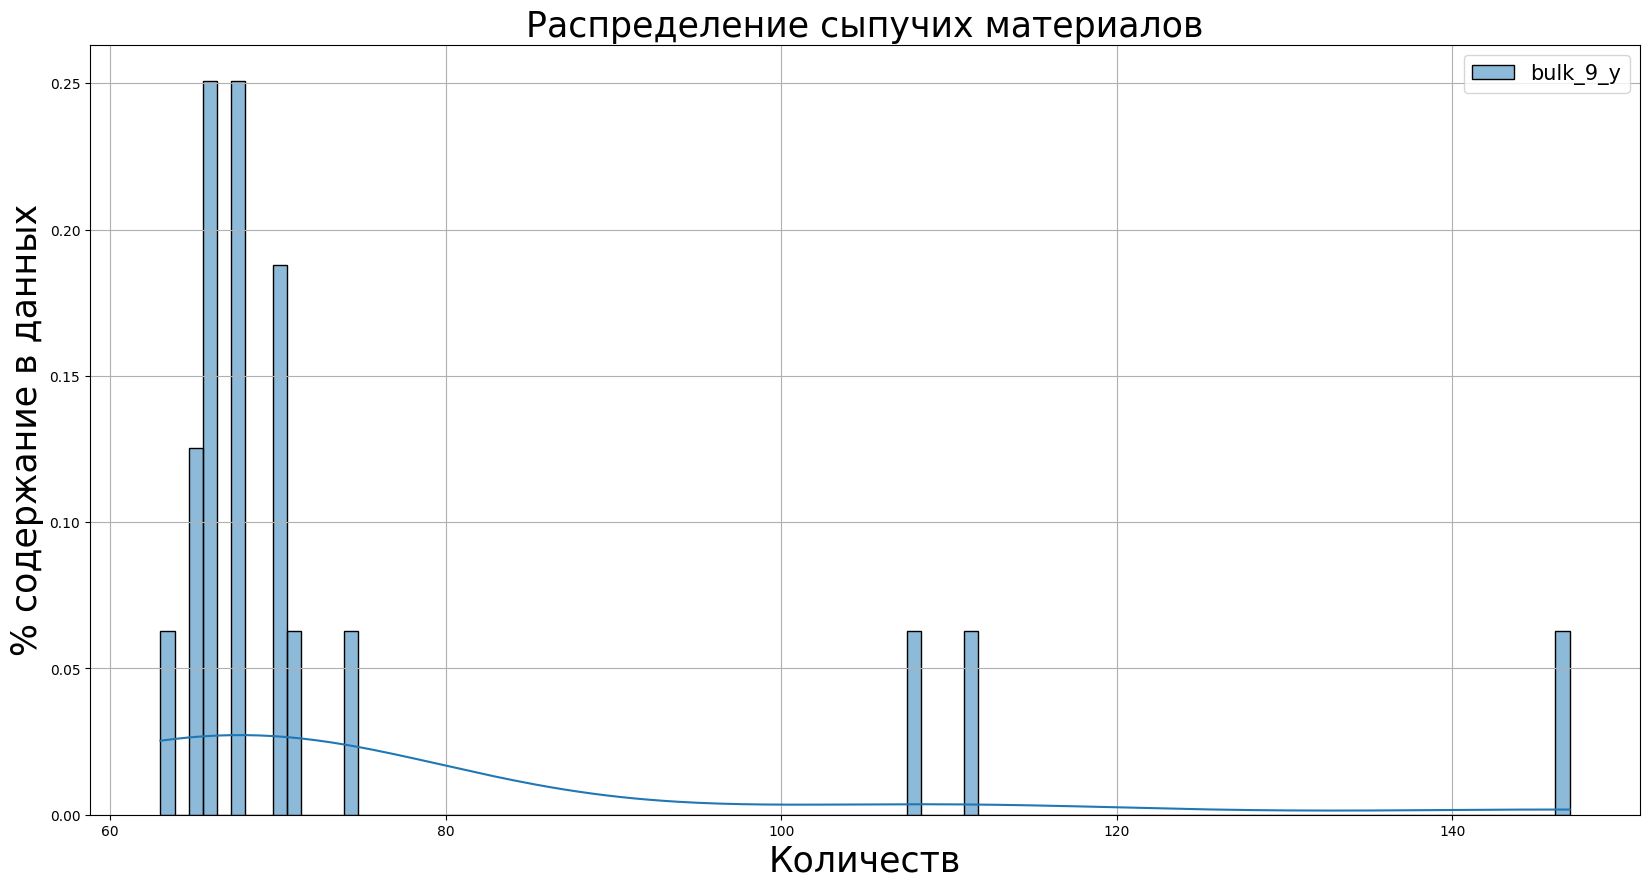

C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


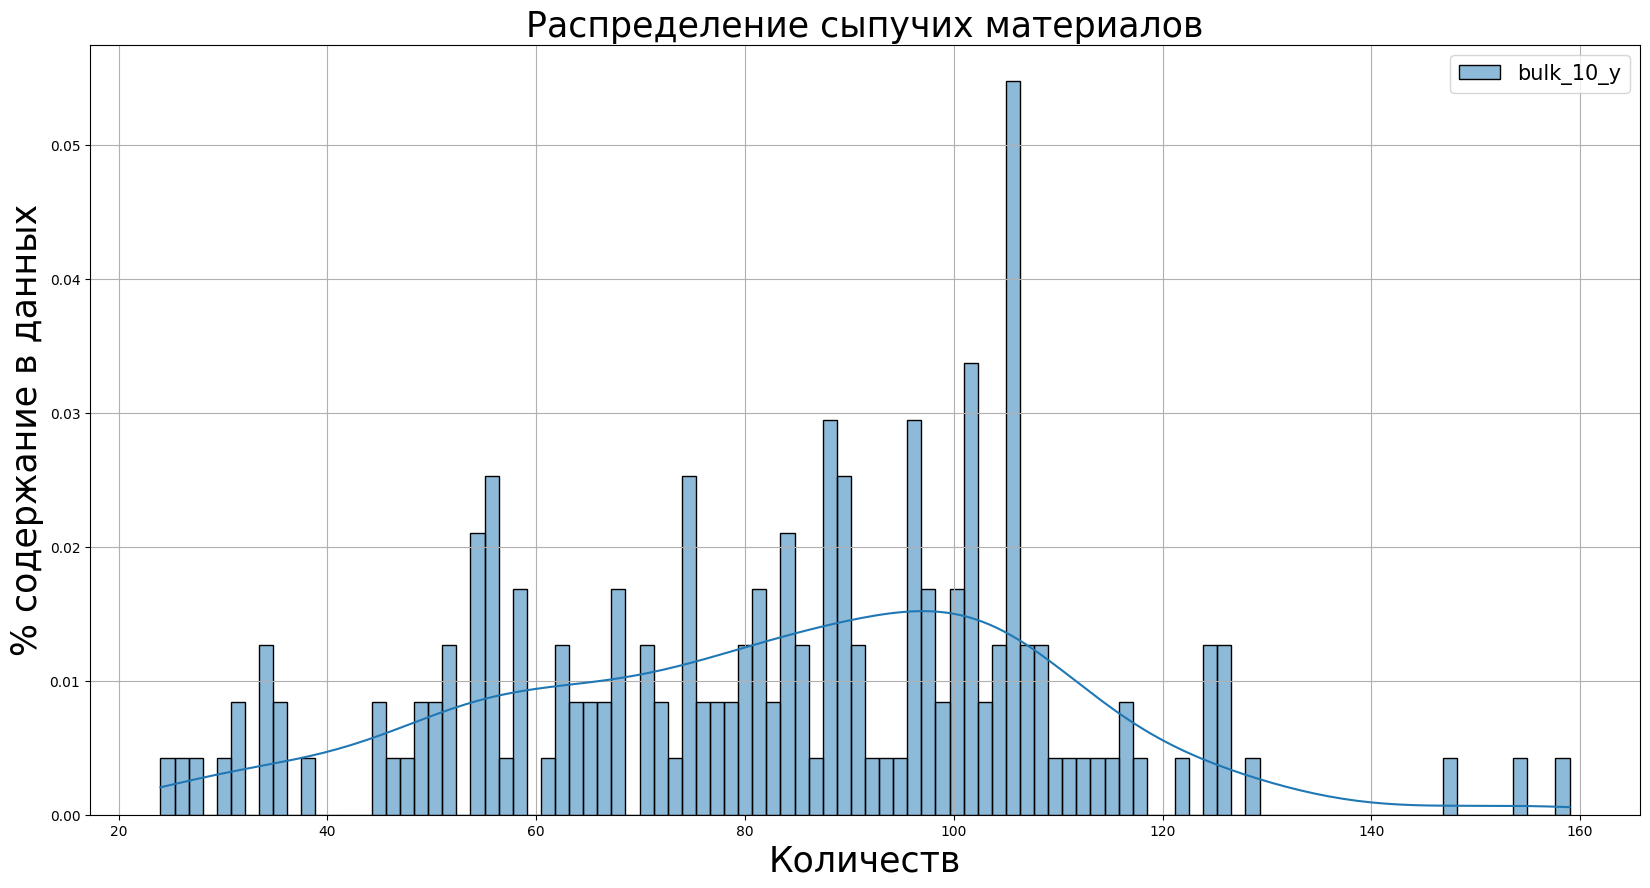

C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


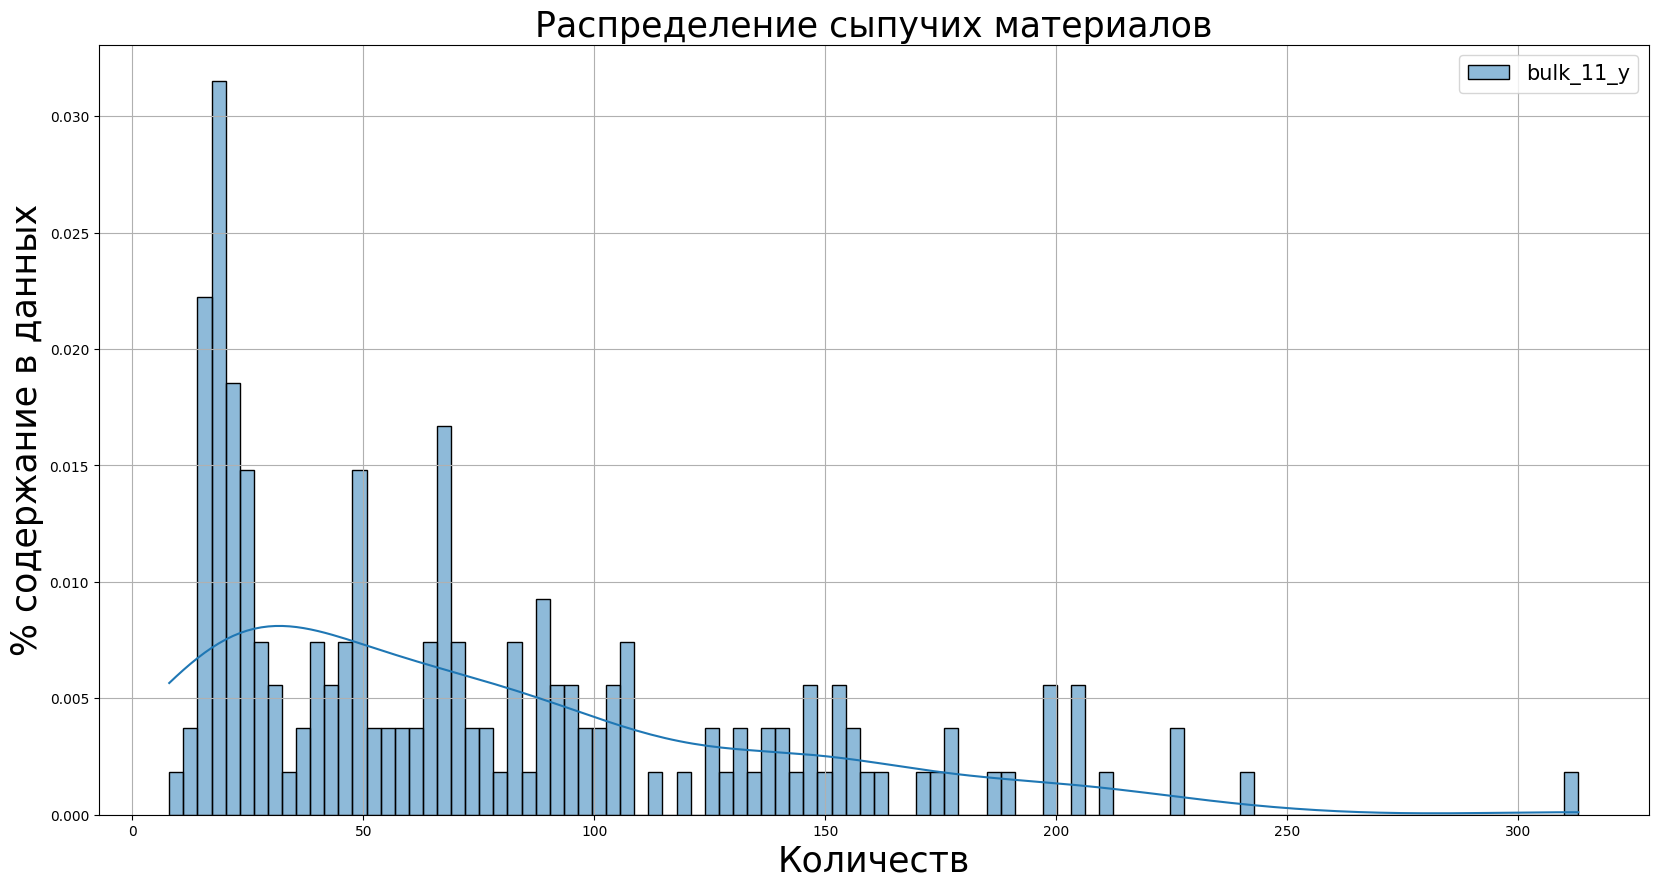

C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


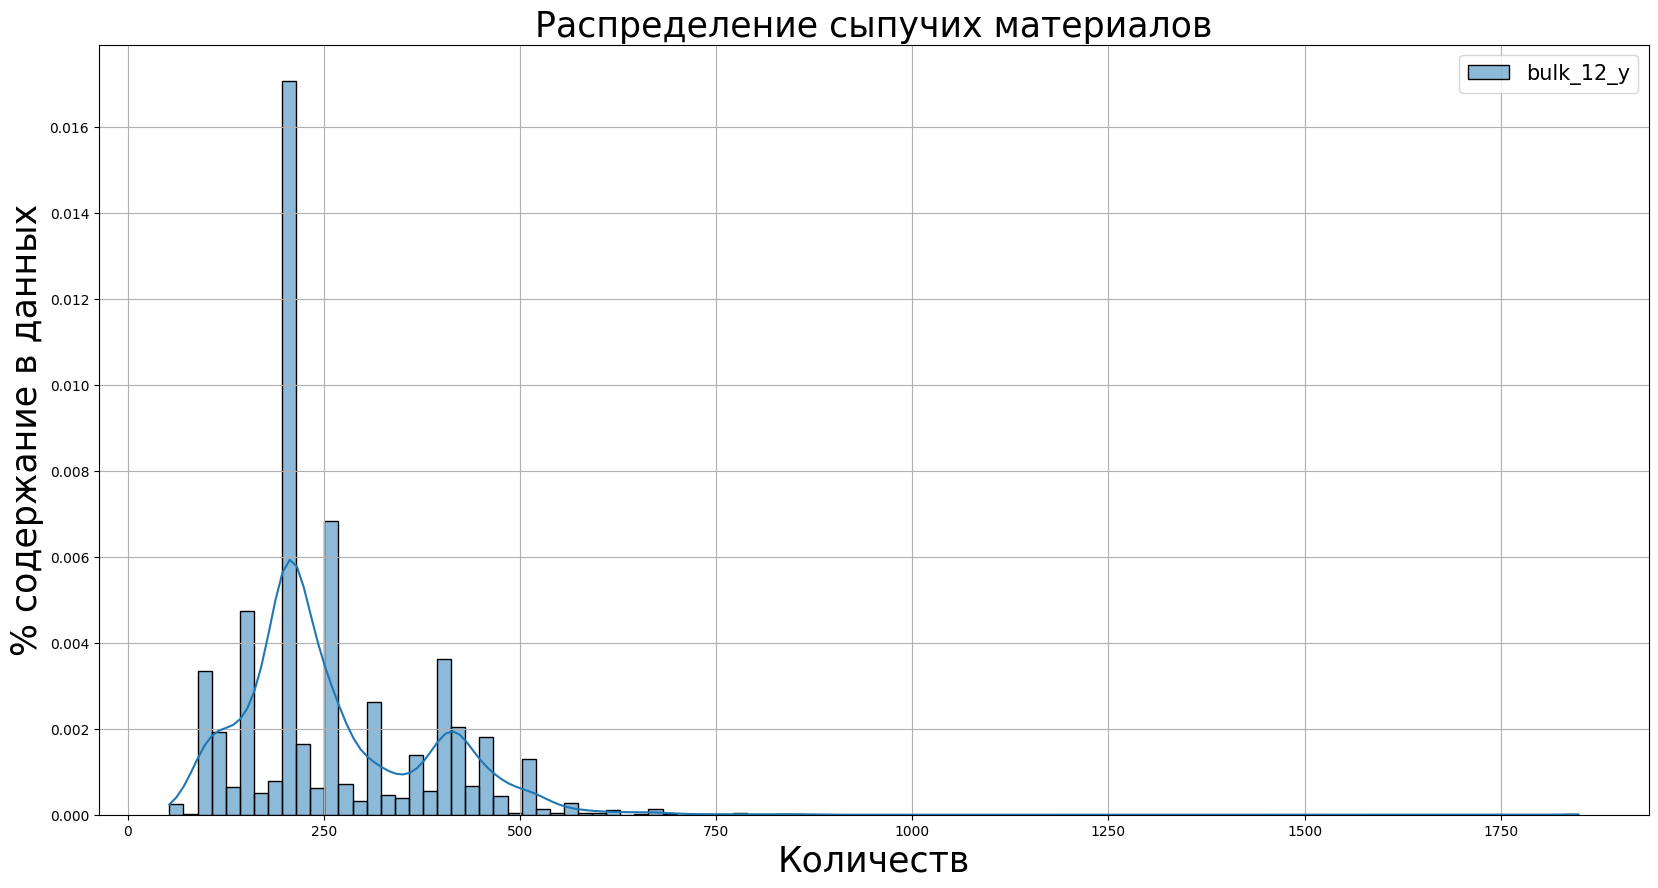

C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


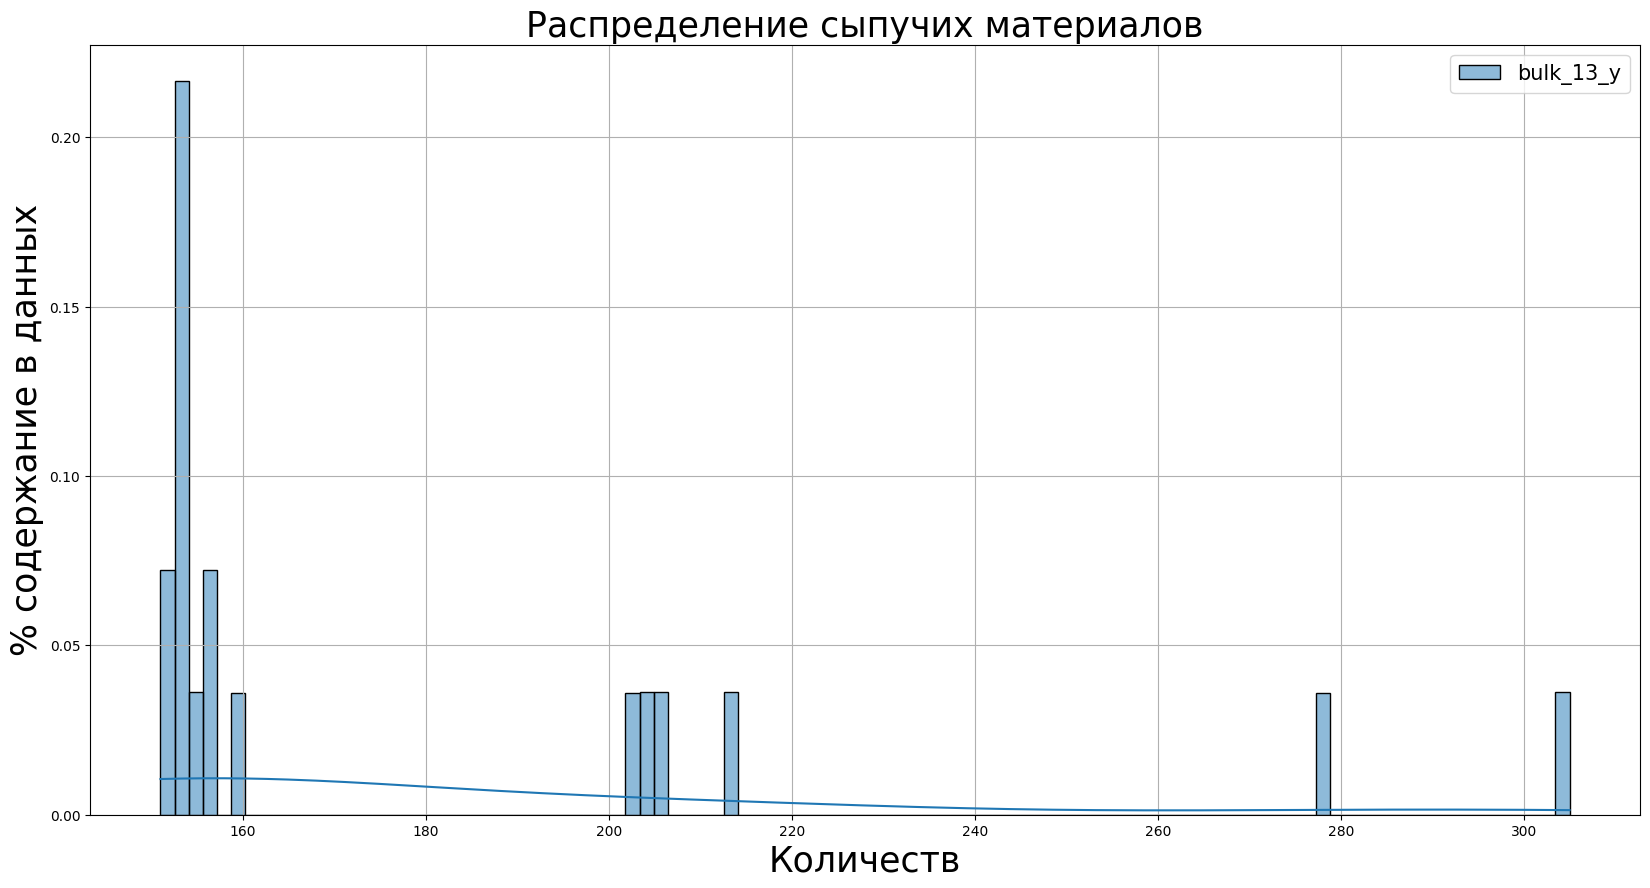

C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


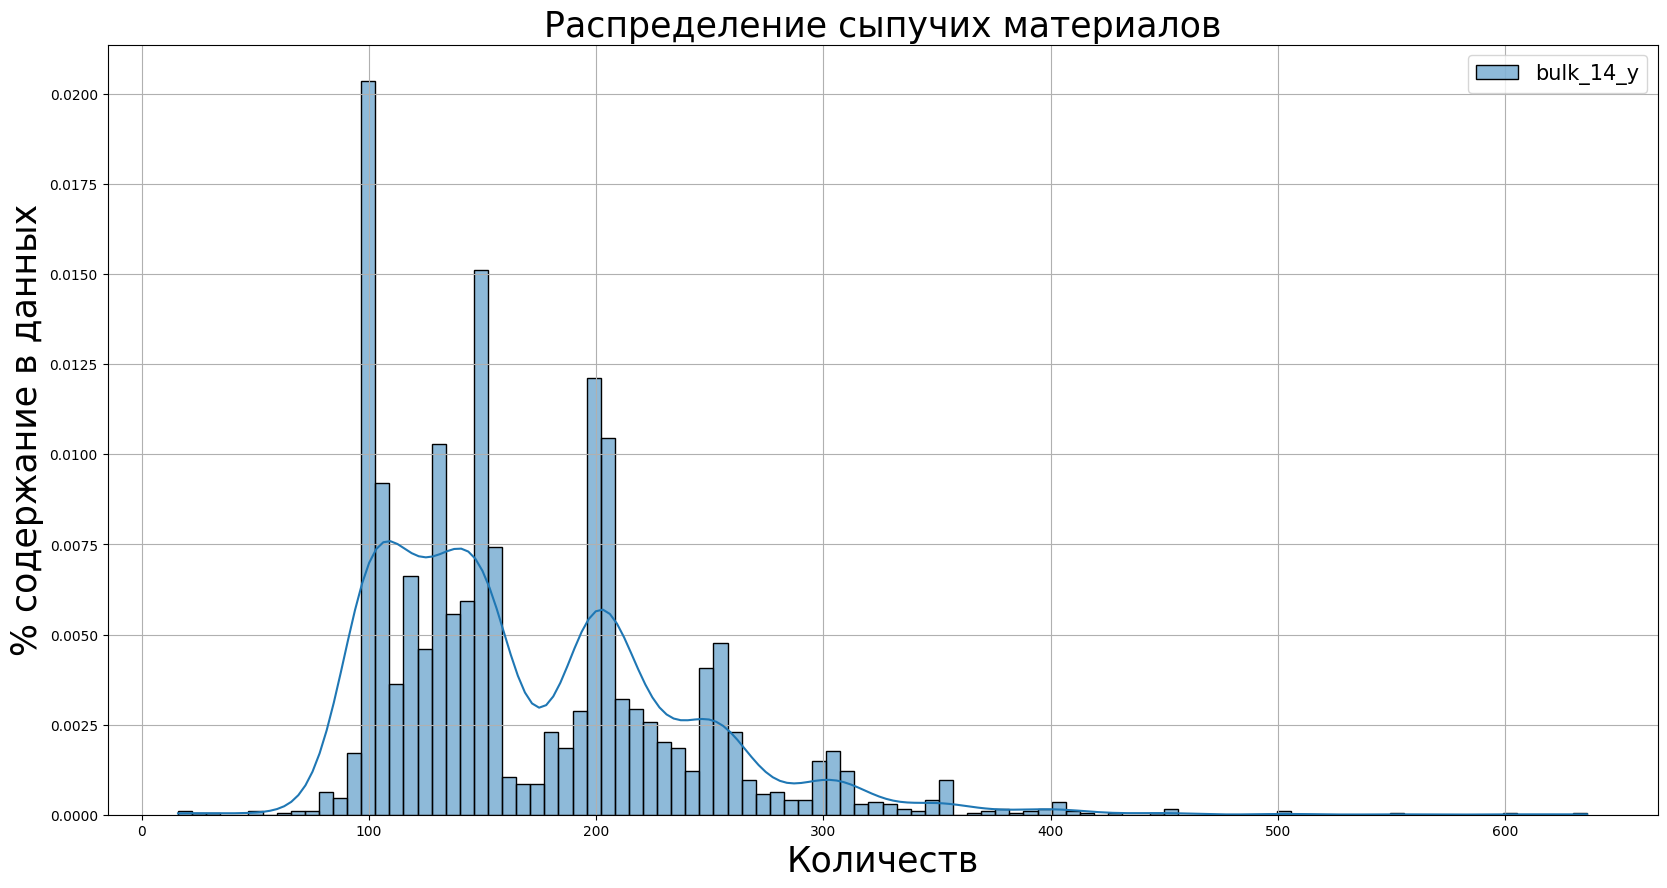

C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


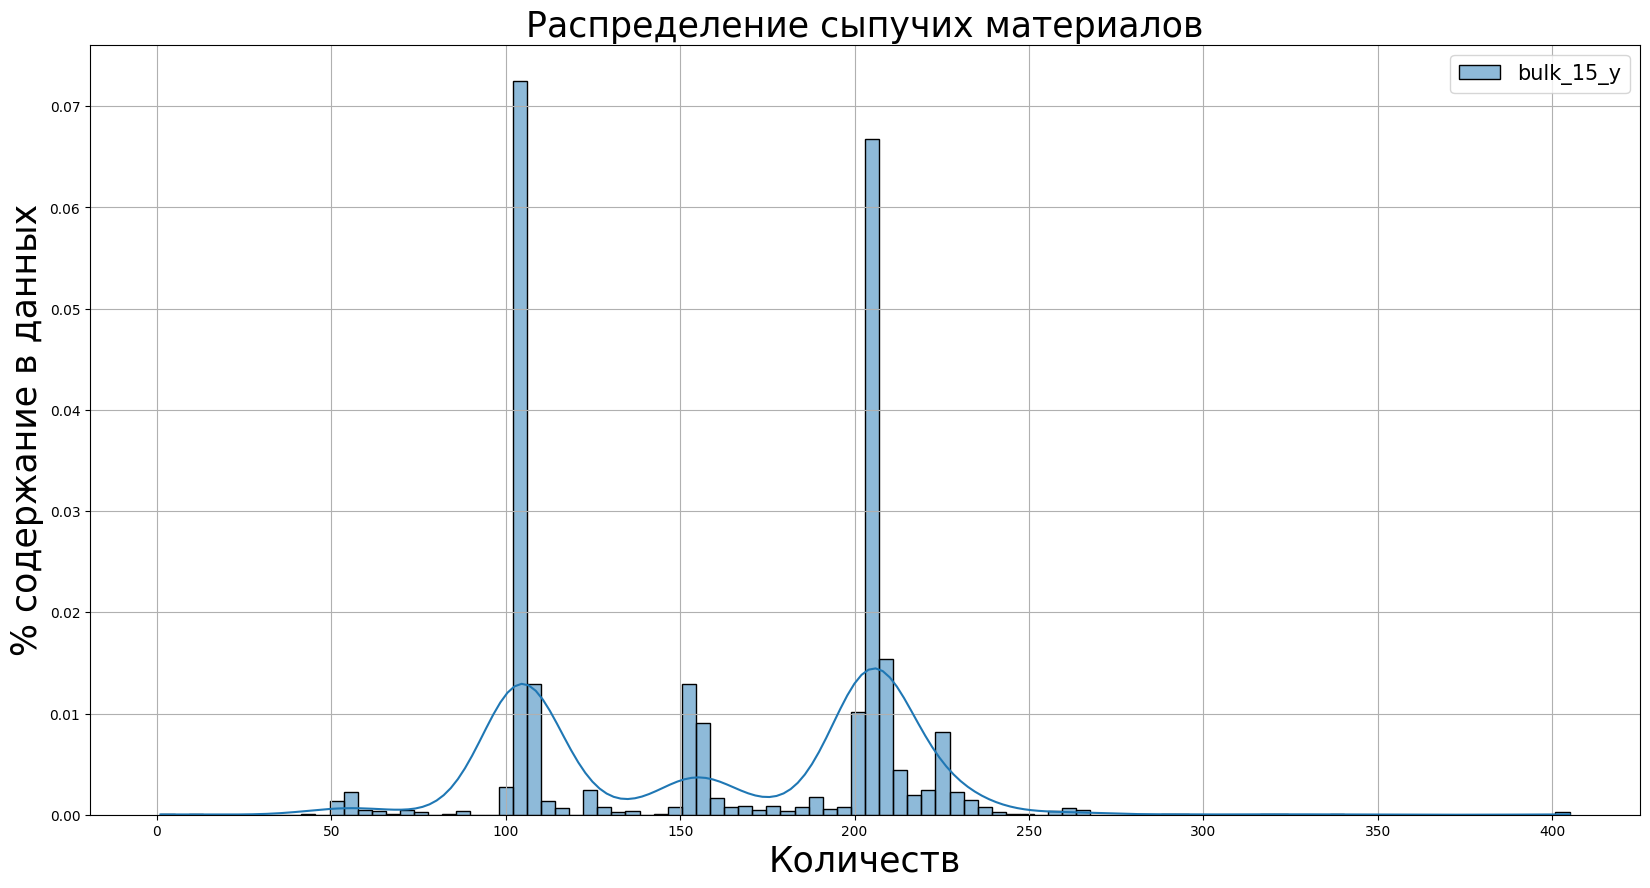

In [23]:
chart1(bulk_splice,'Распределение сыпучих материалов','Количеств','% содержание в данных')

C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning

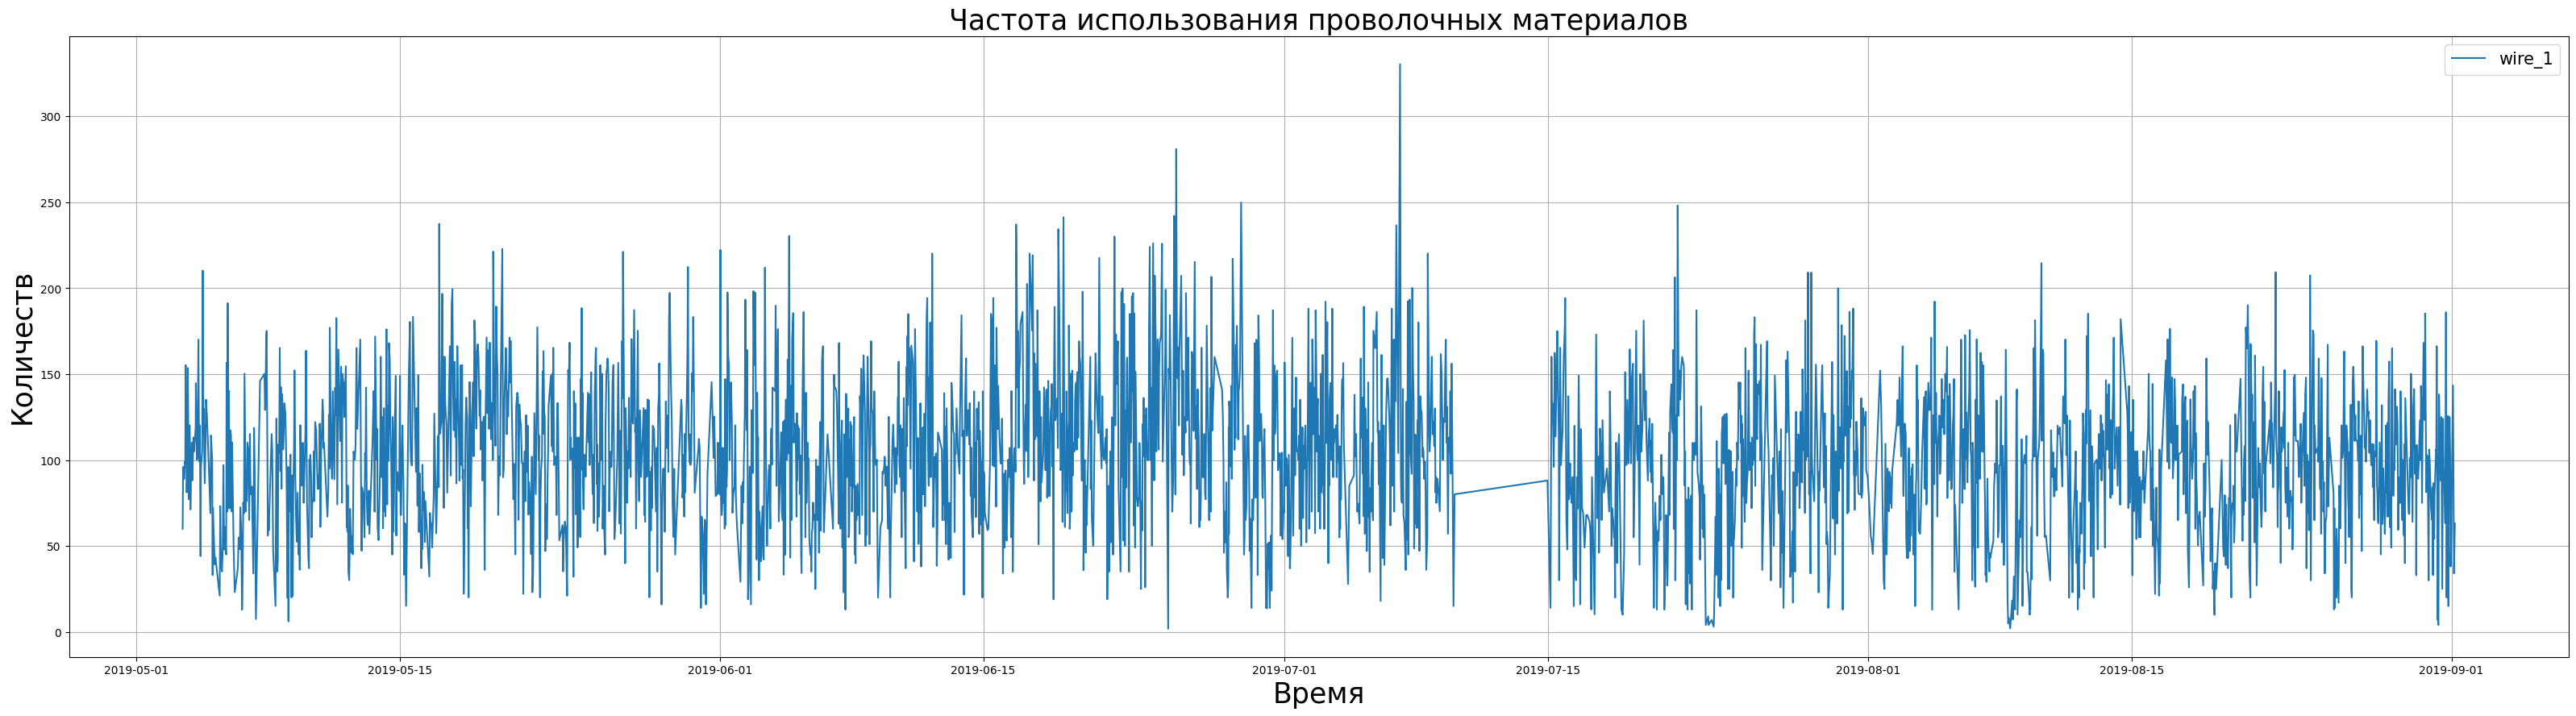

C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning

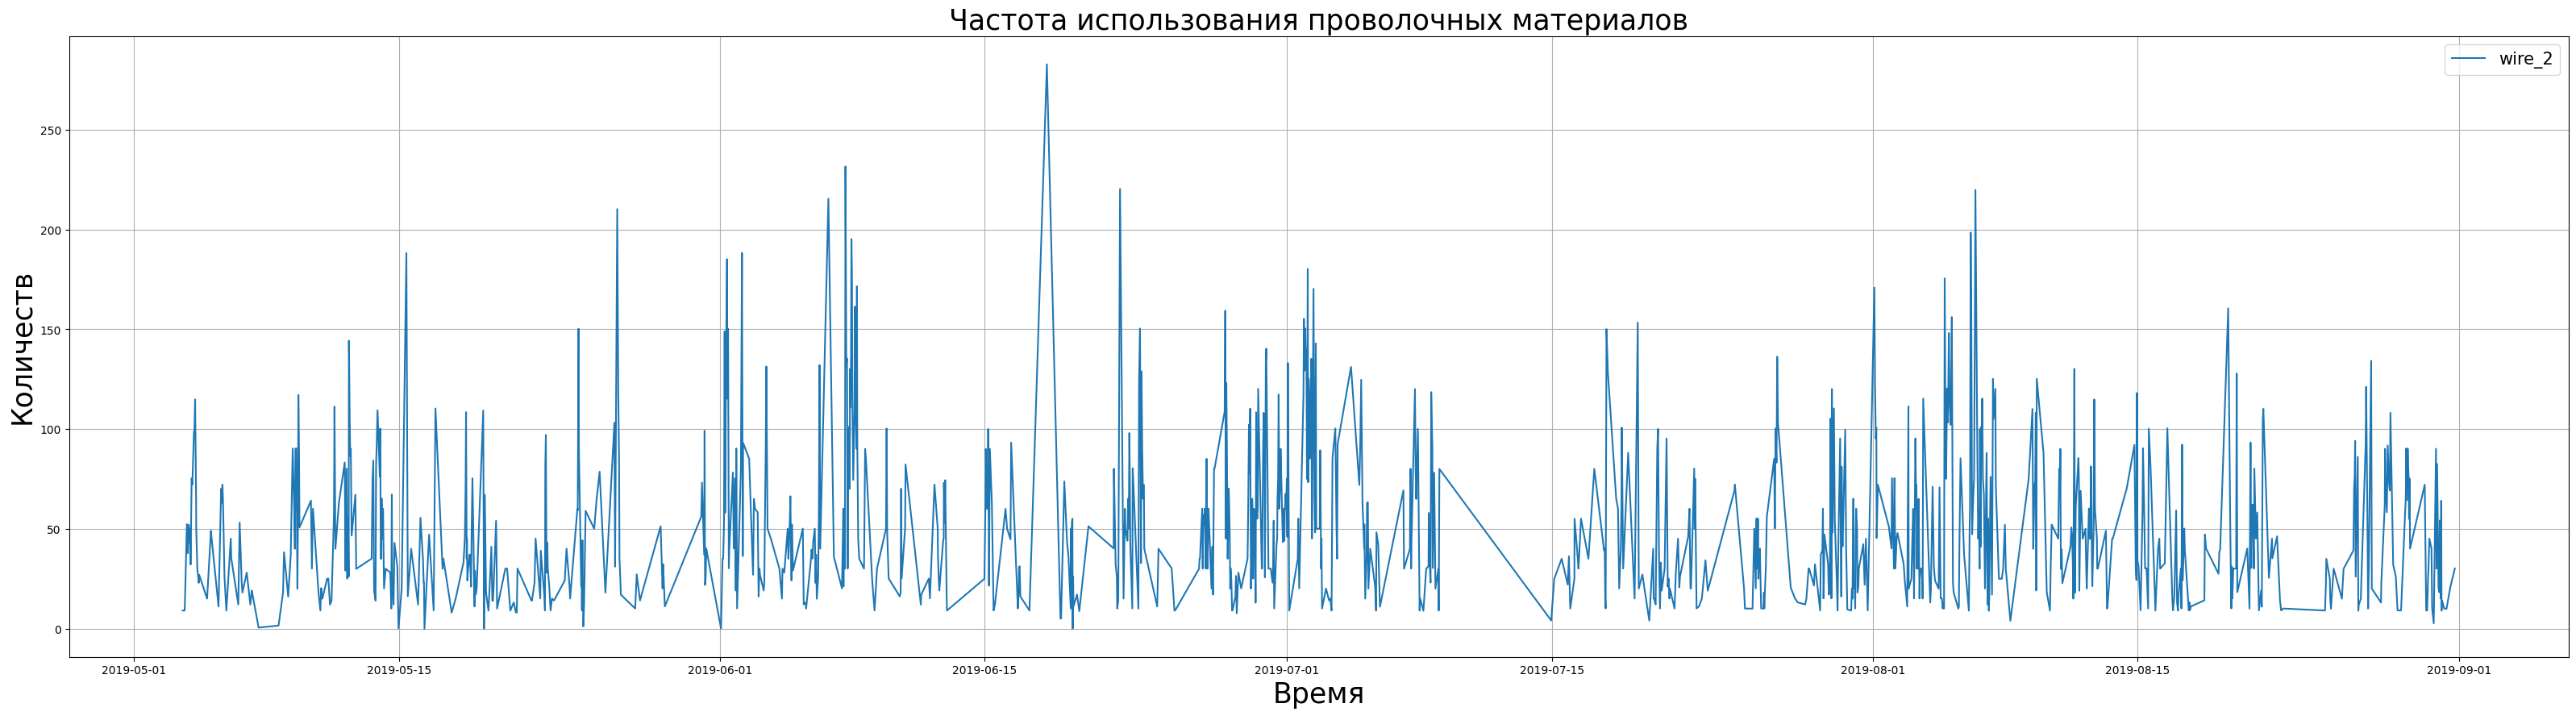

C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning

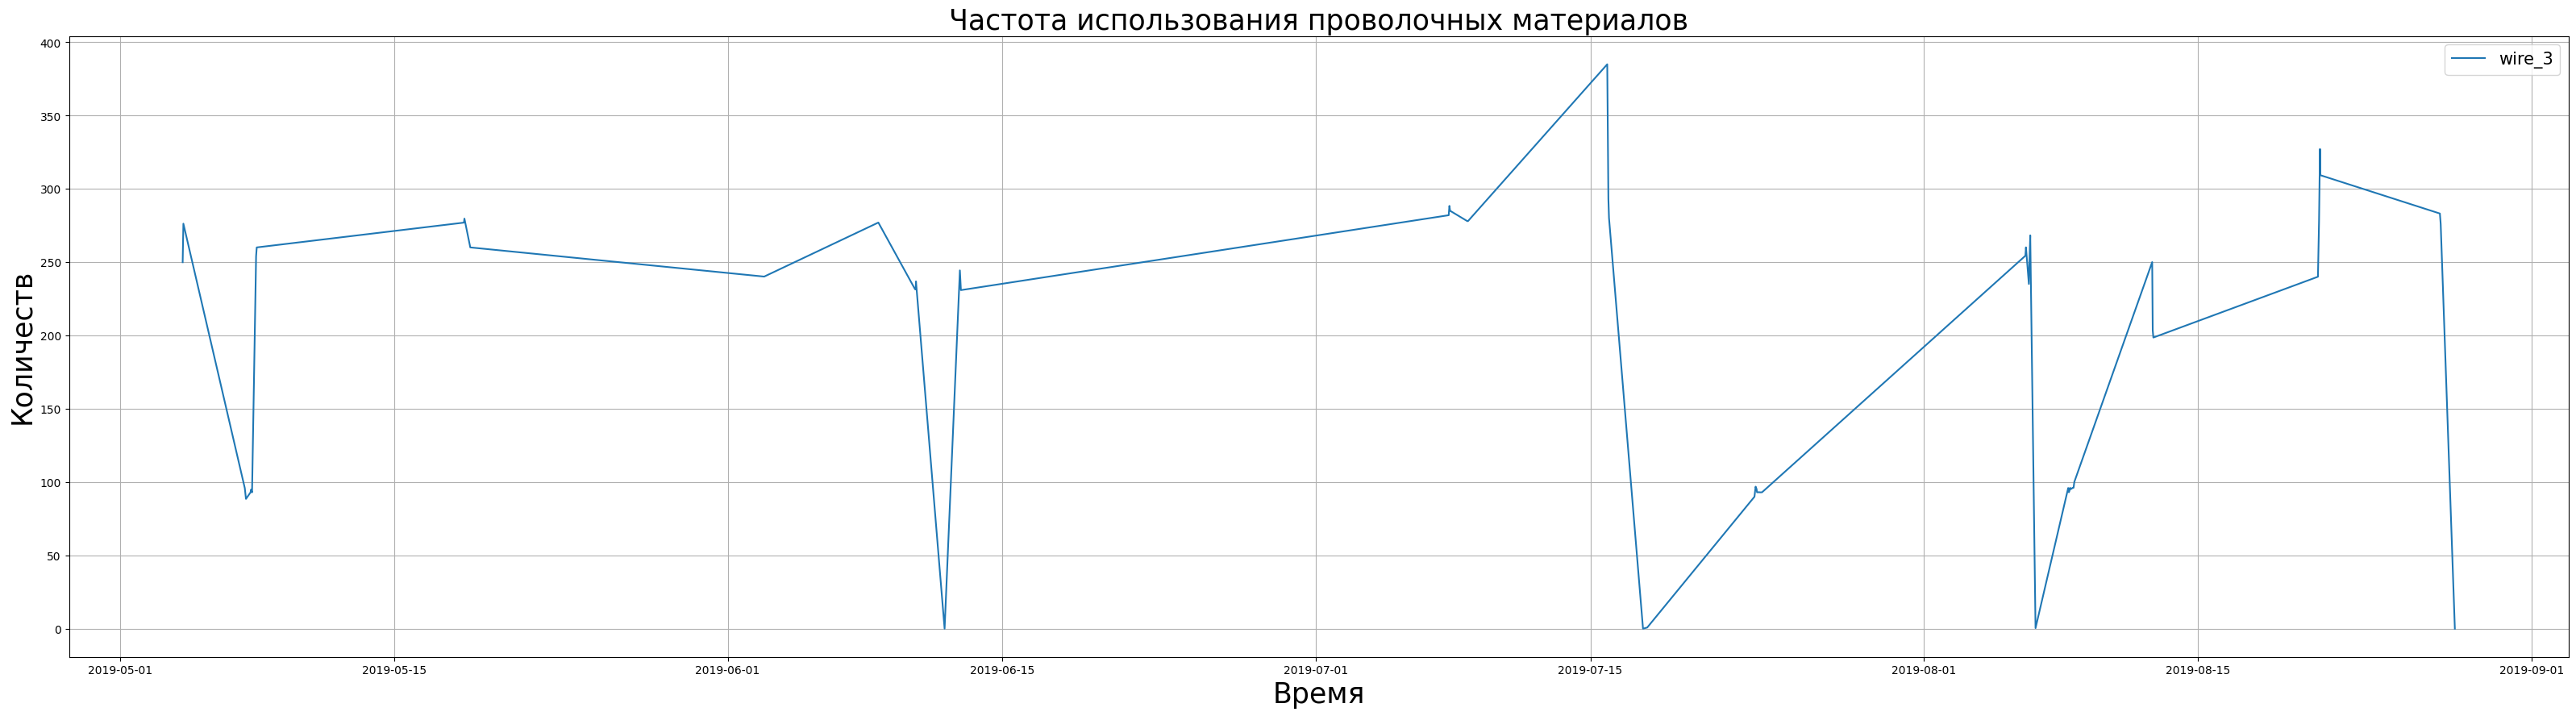

C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning

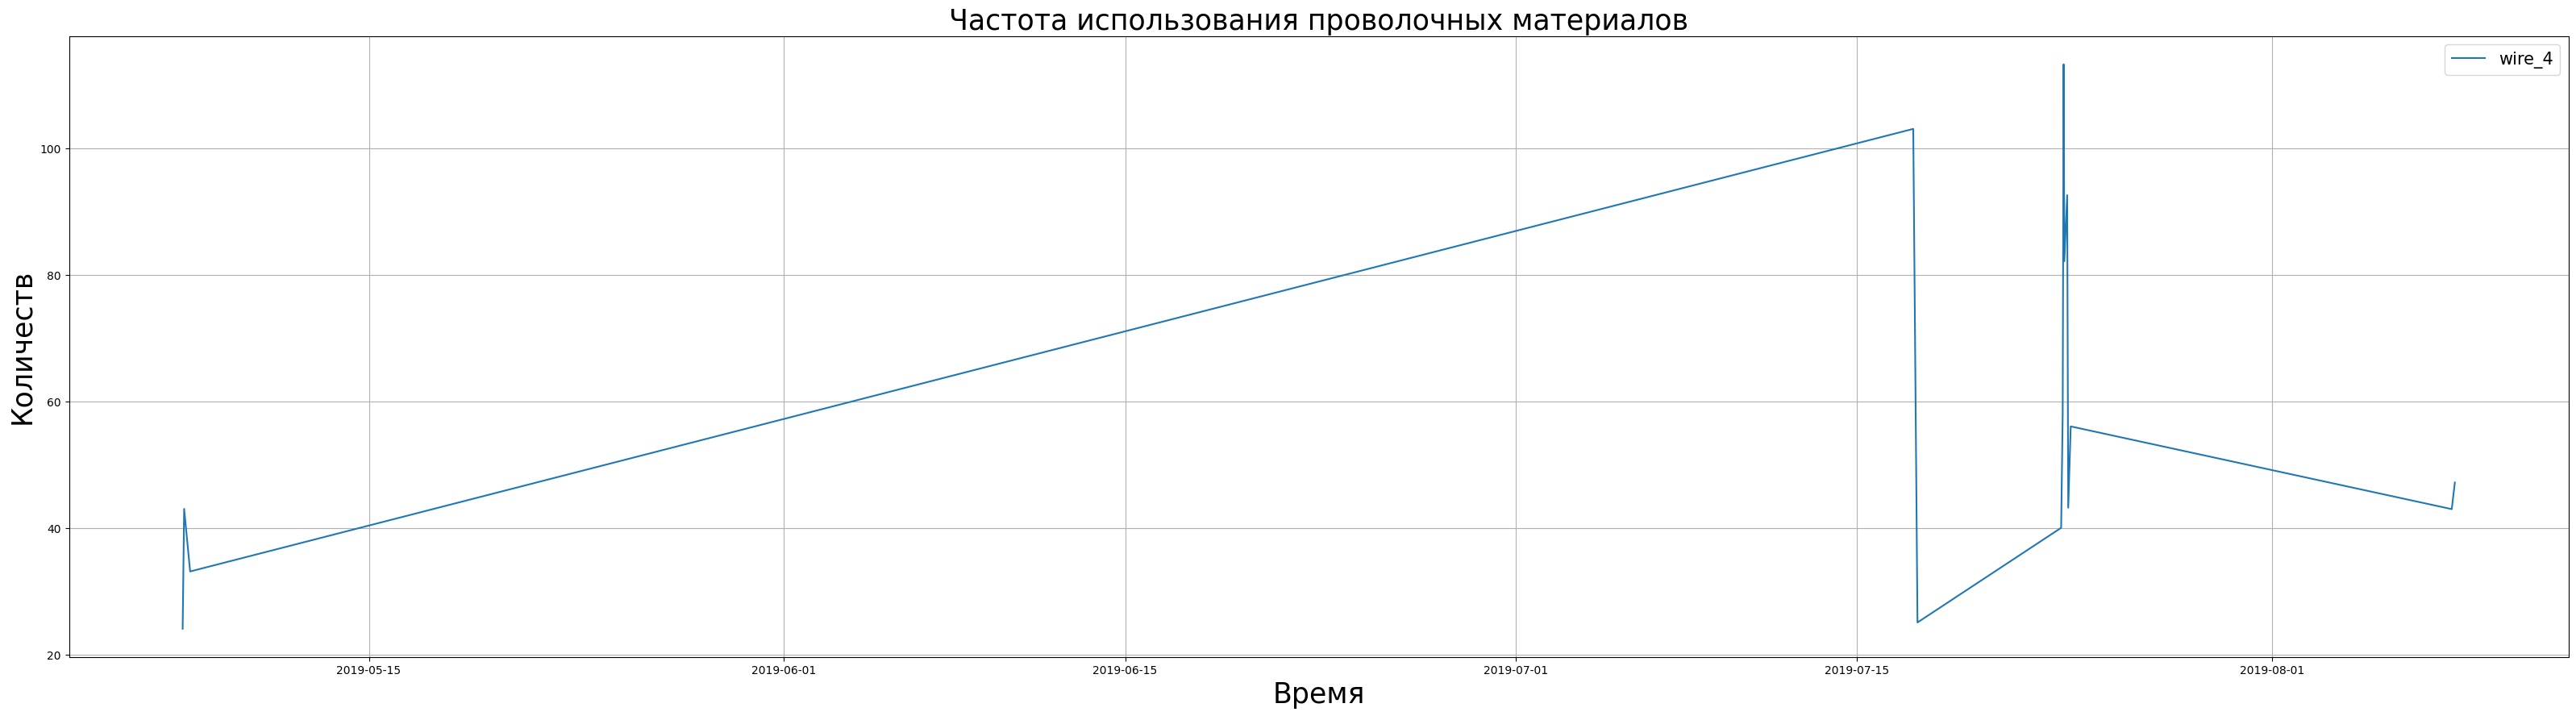

C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning

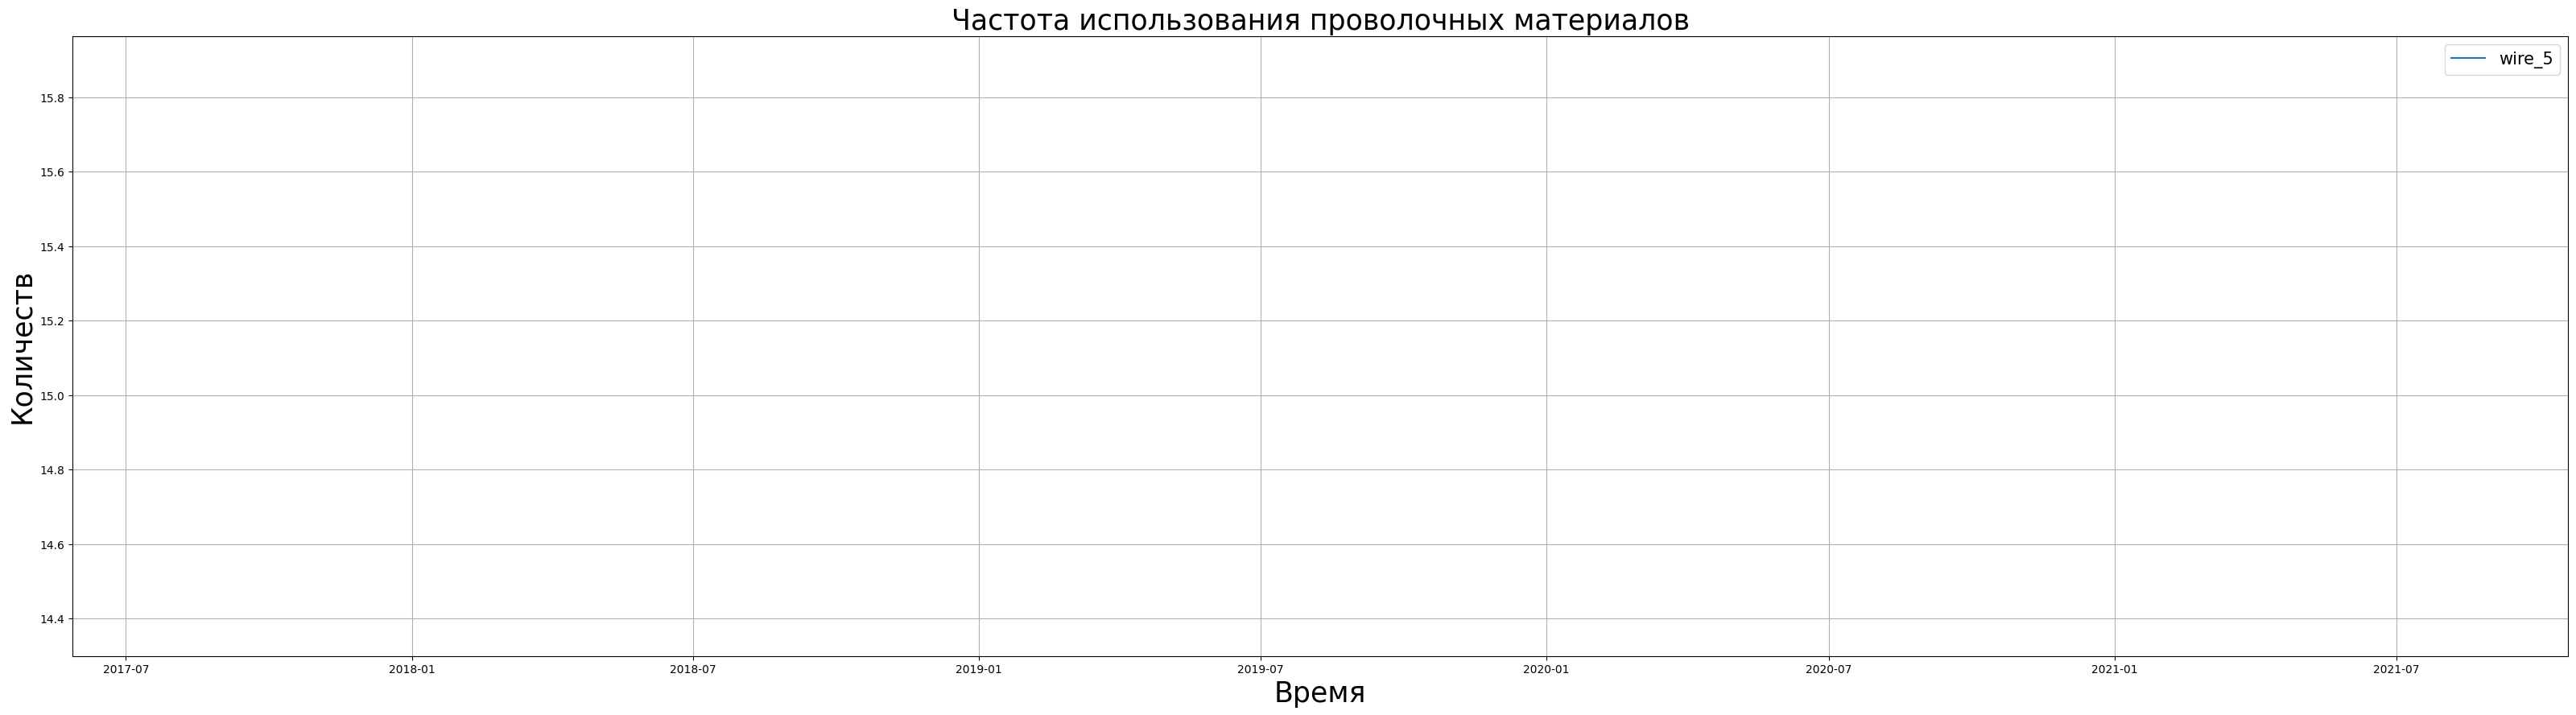

C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning

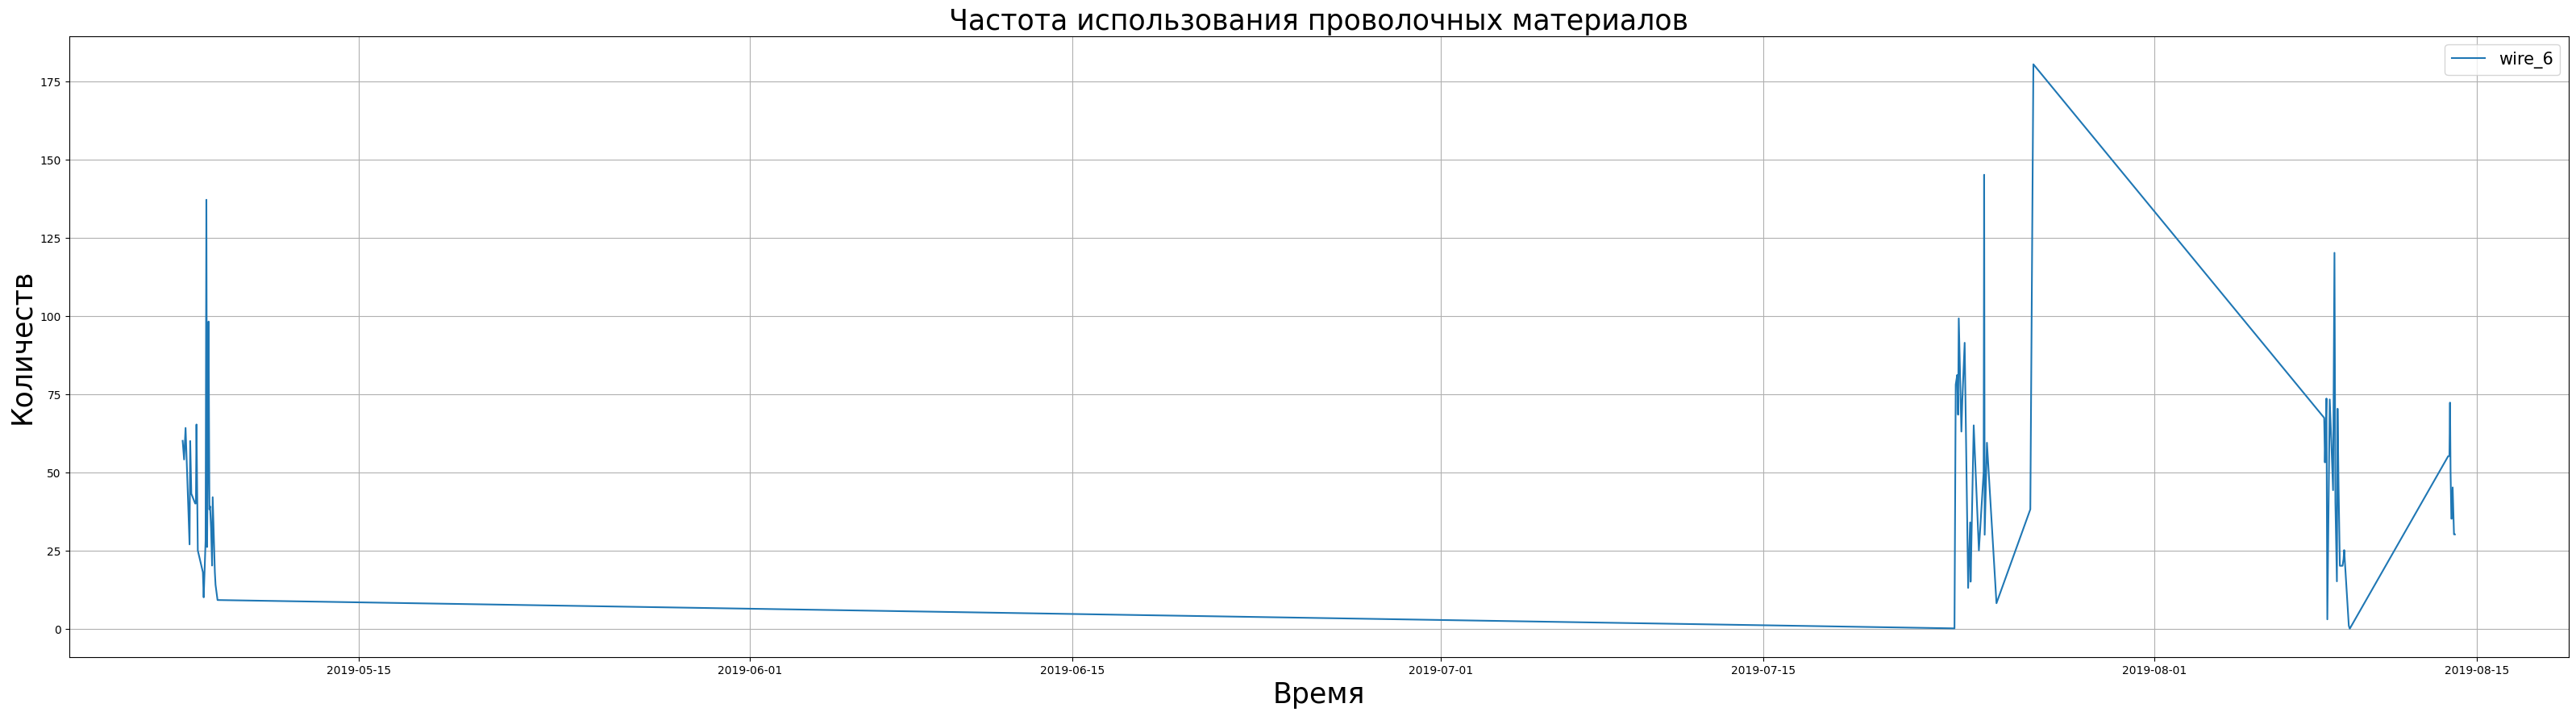

C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning

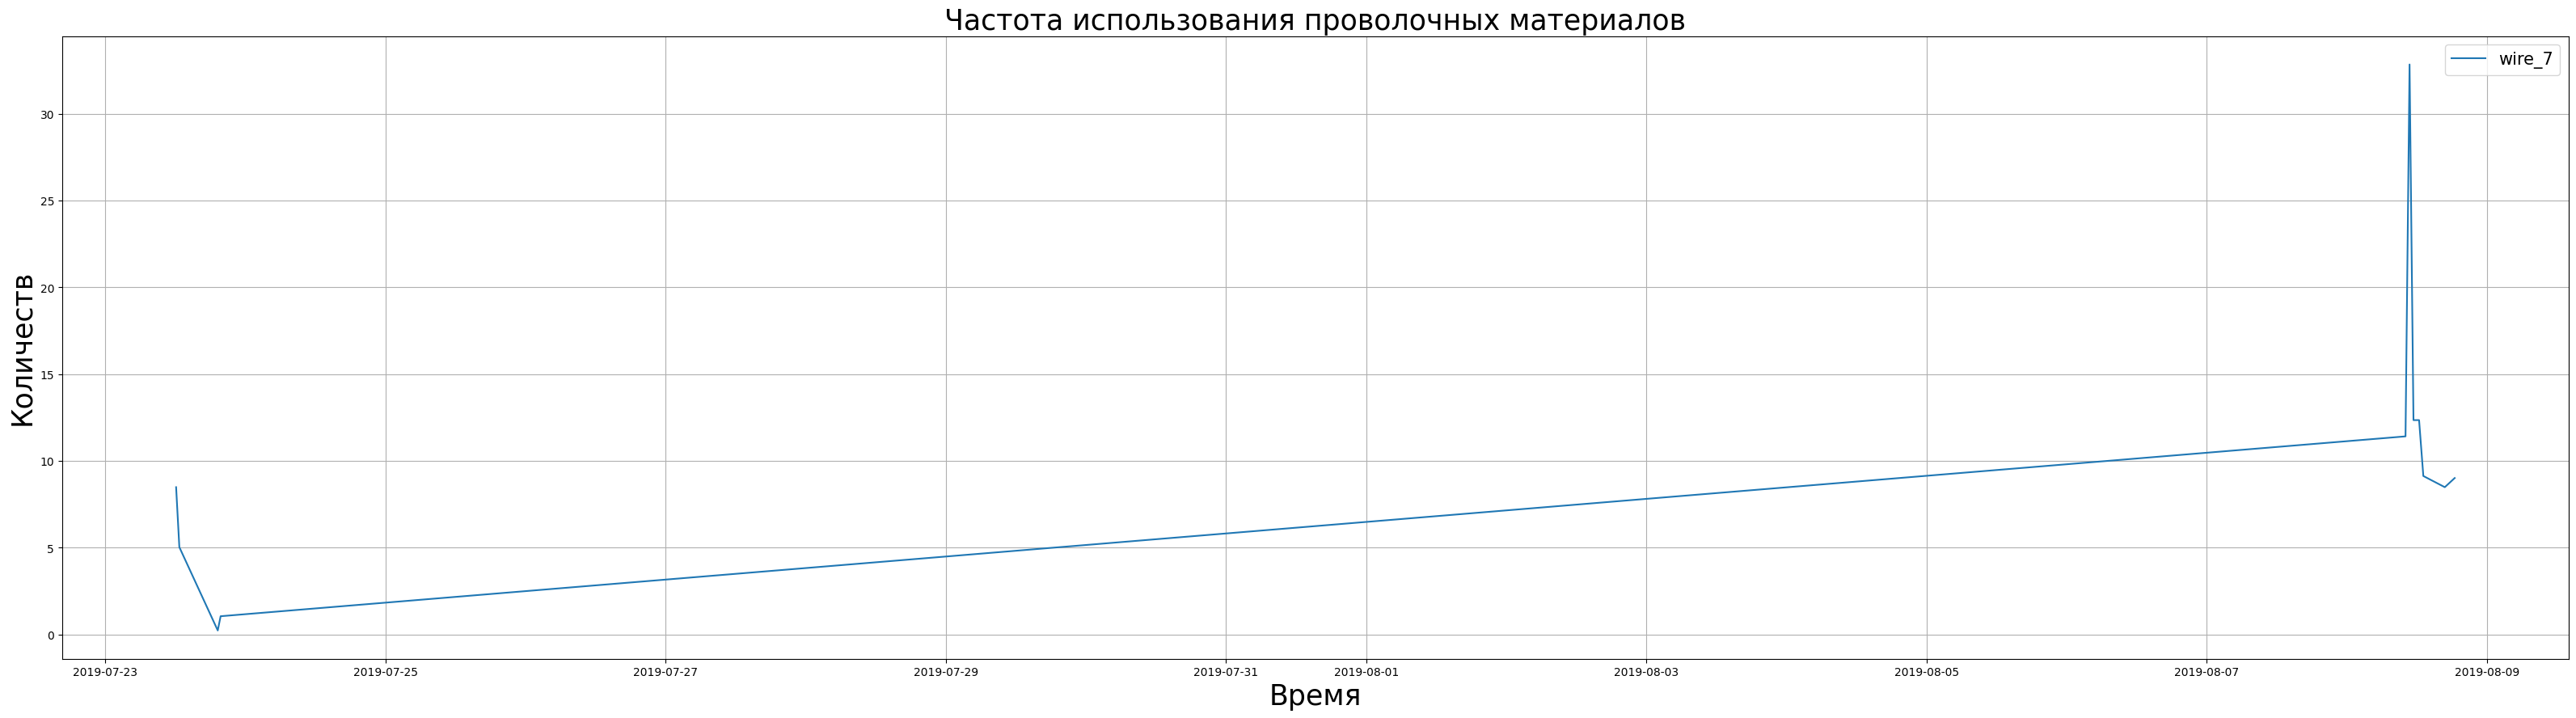

C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning

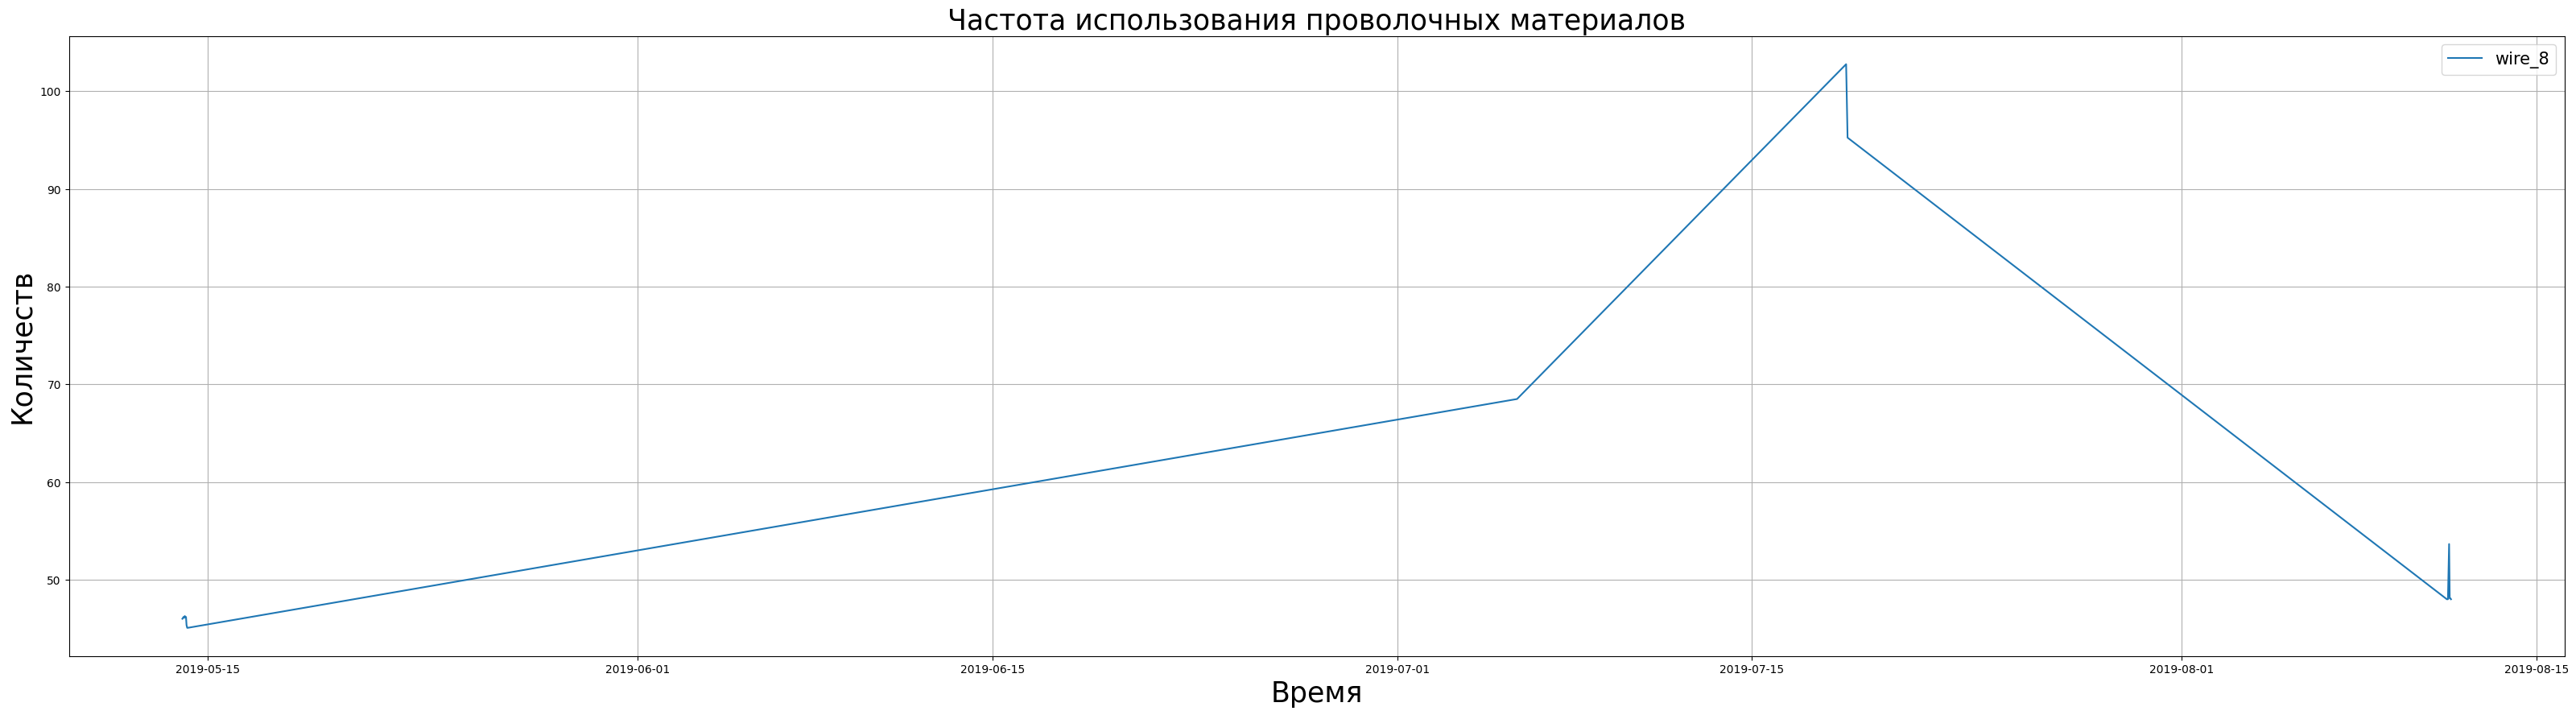

C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning

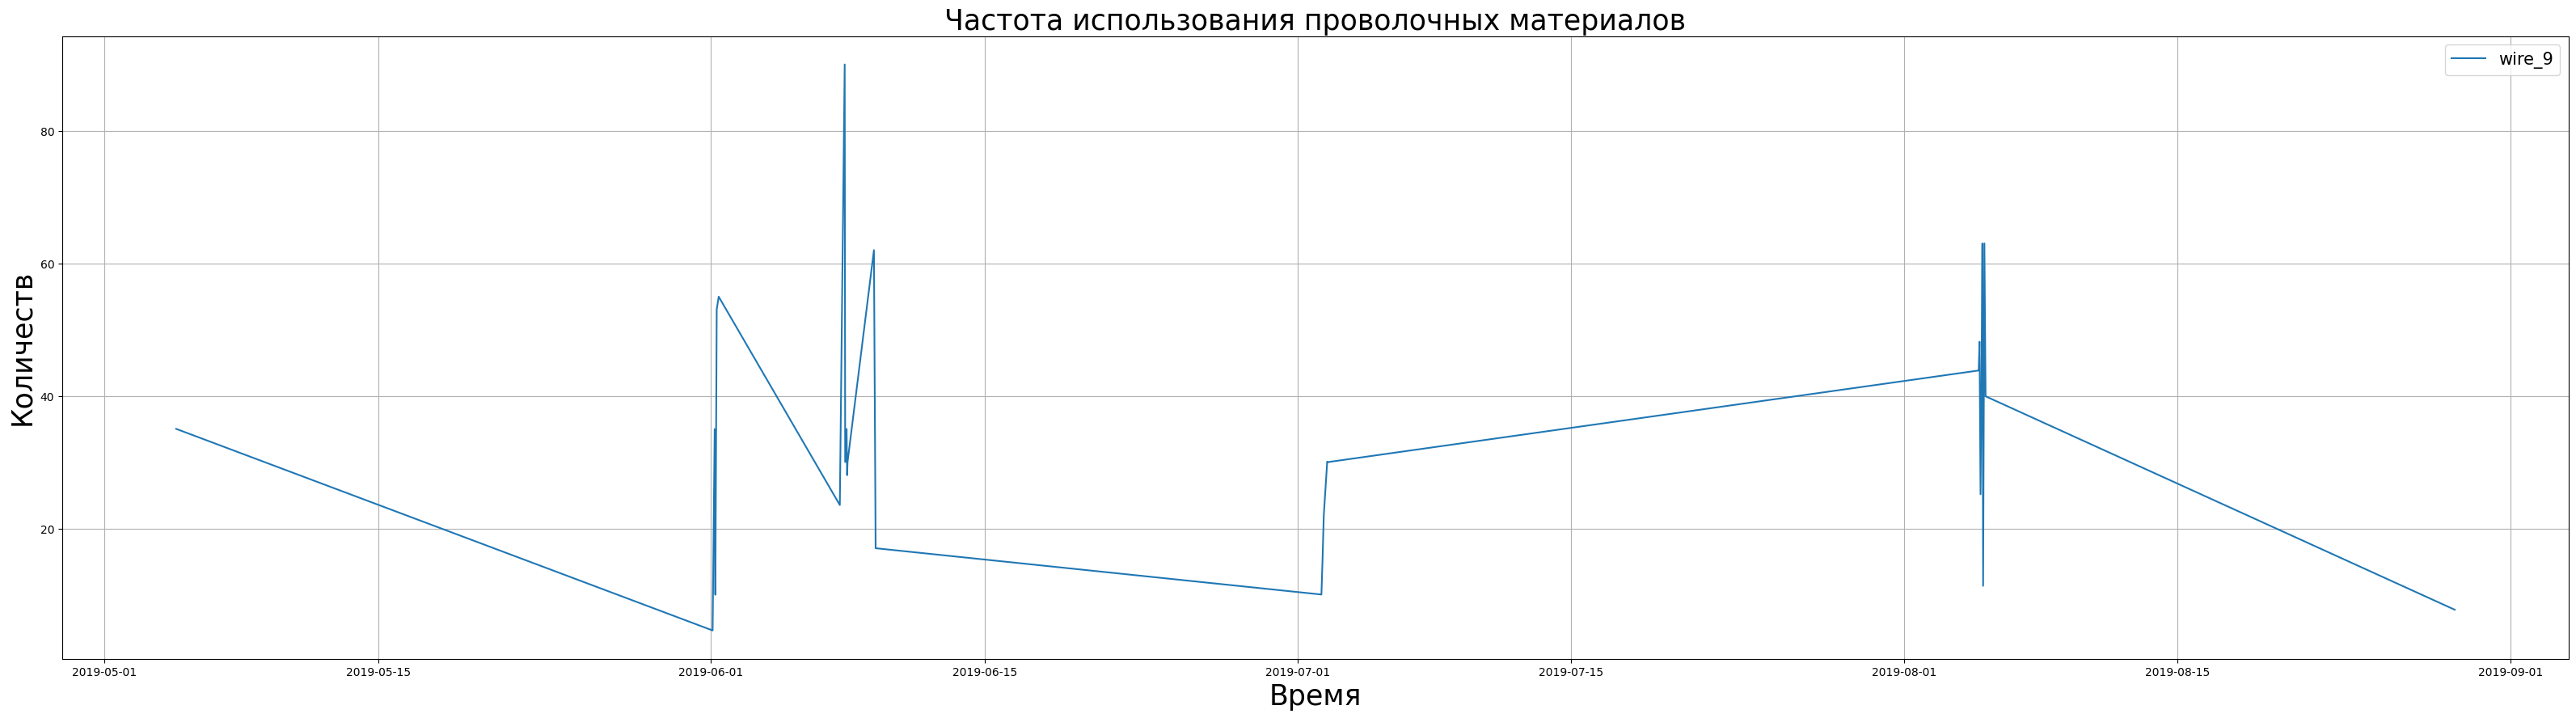

In [24]:
chart3(wire_splice,'Частота использования сыпучих материалов','Время','Количеств')

C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


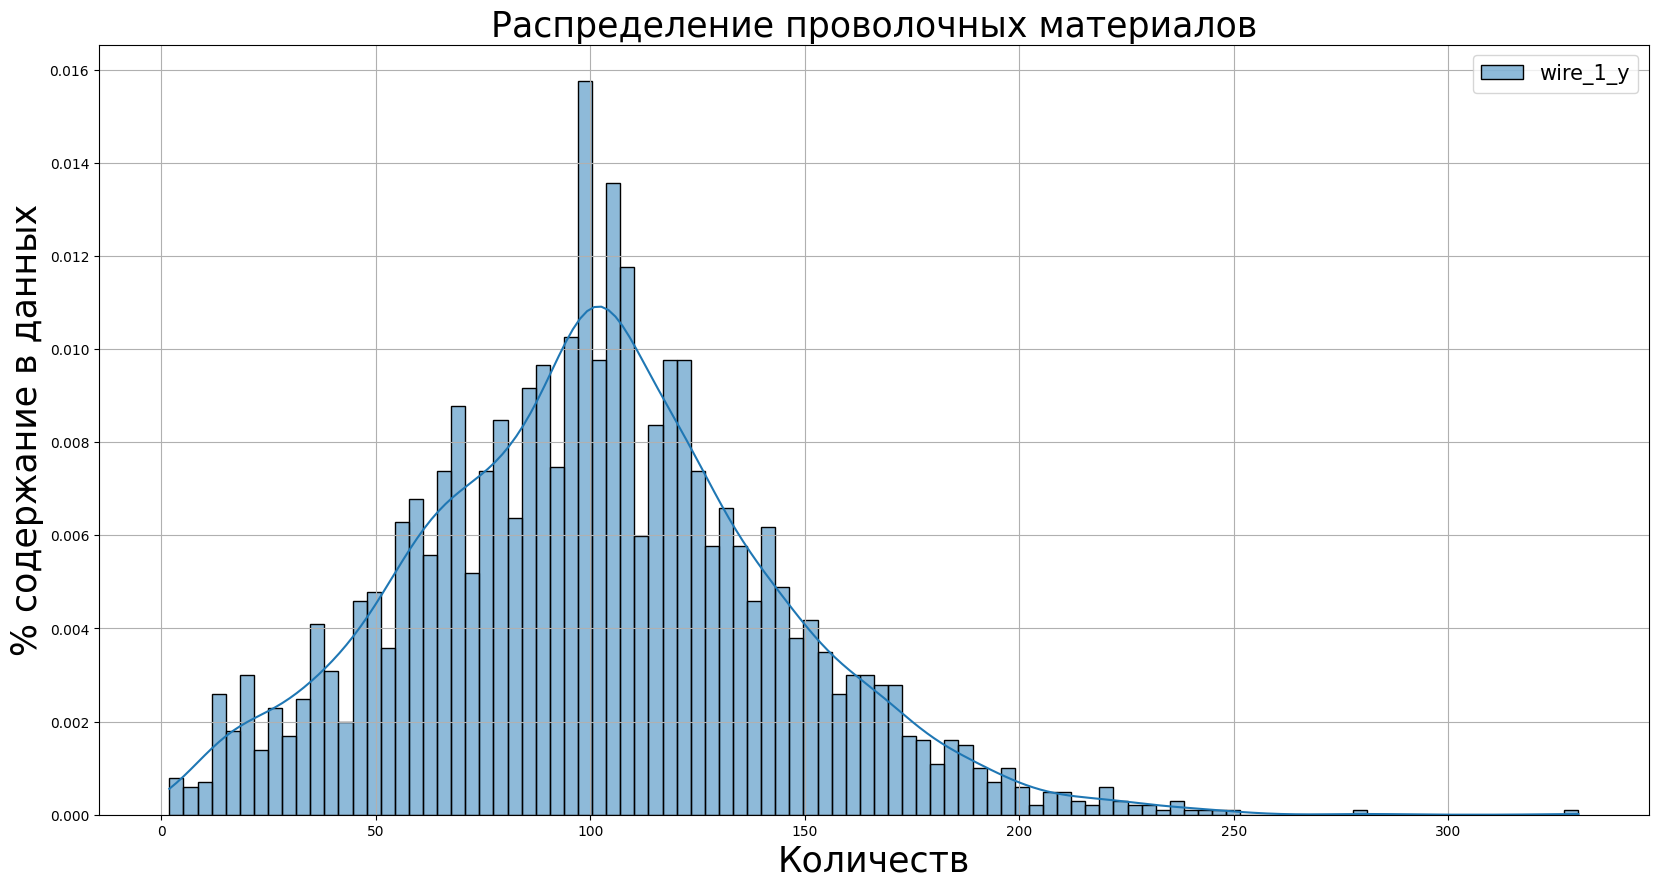

C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


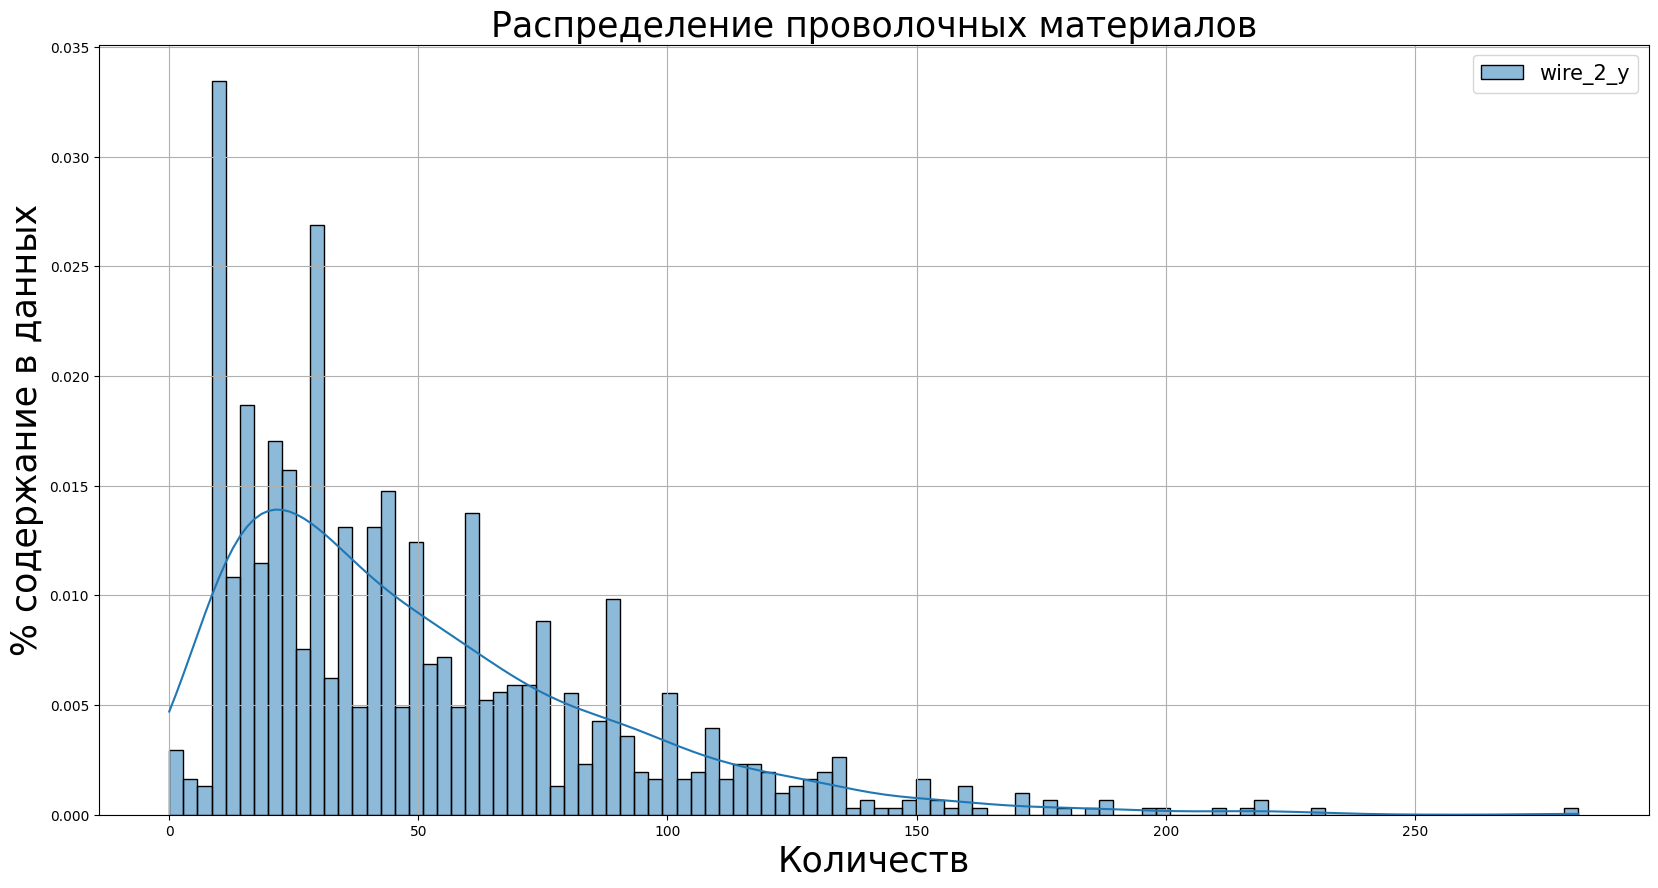

C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


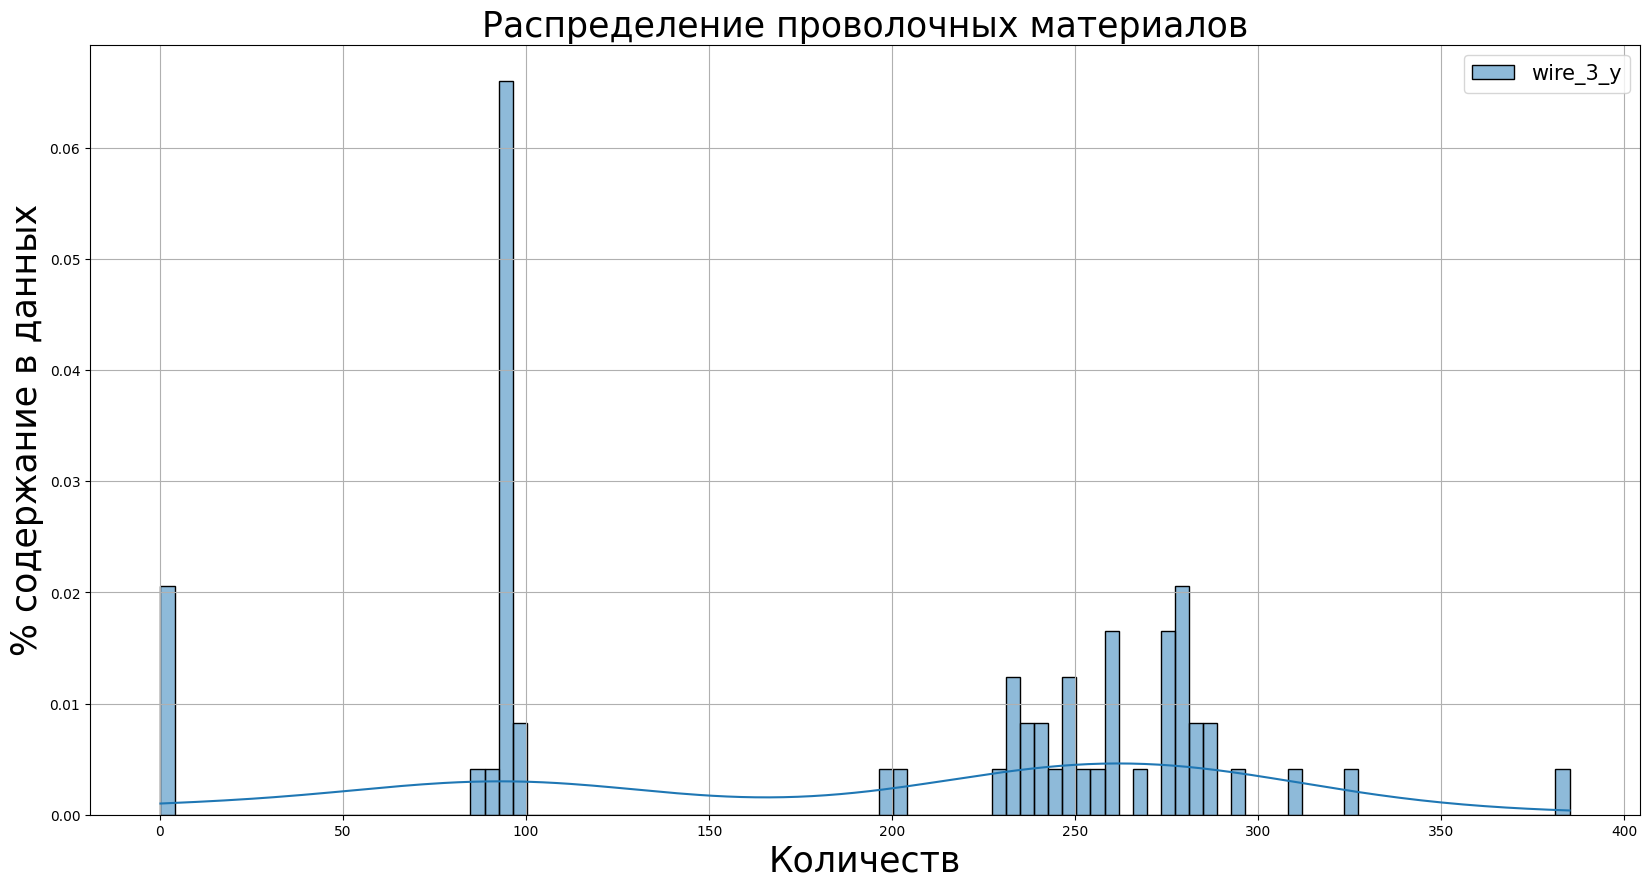

C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


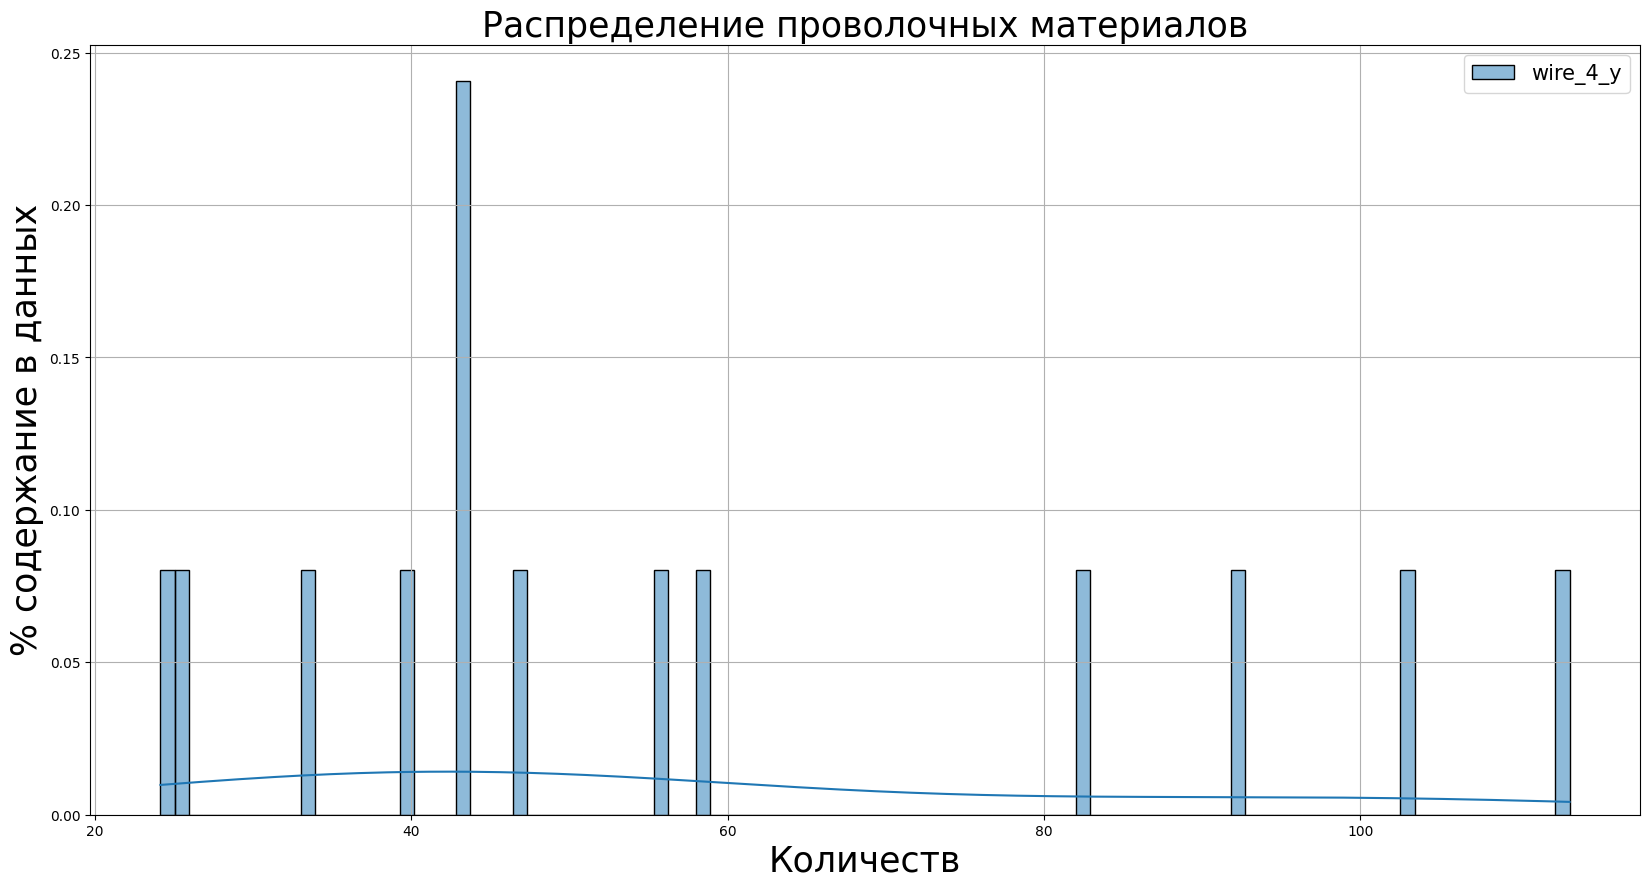

C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


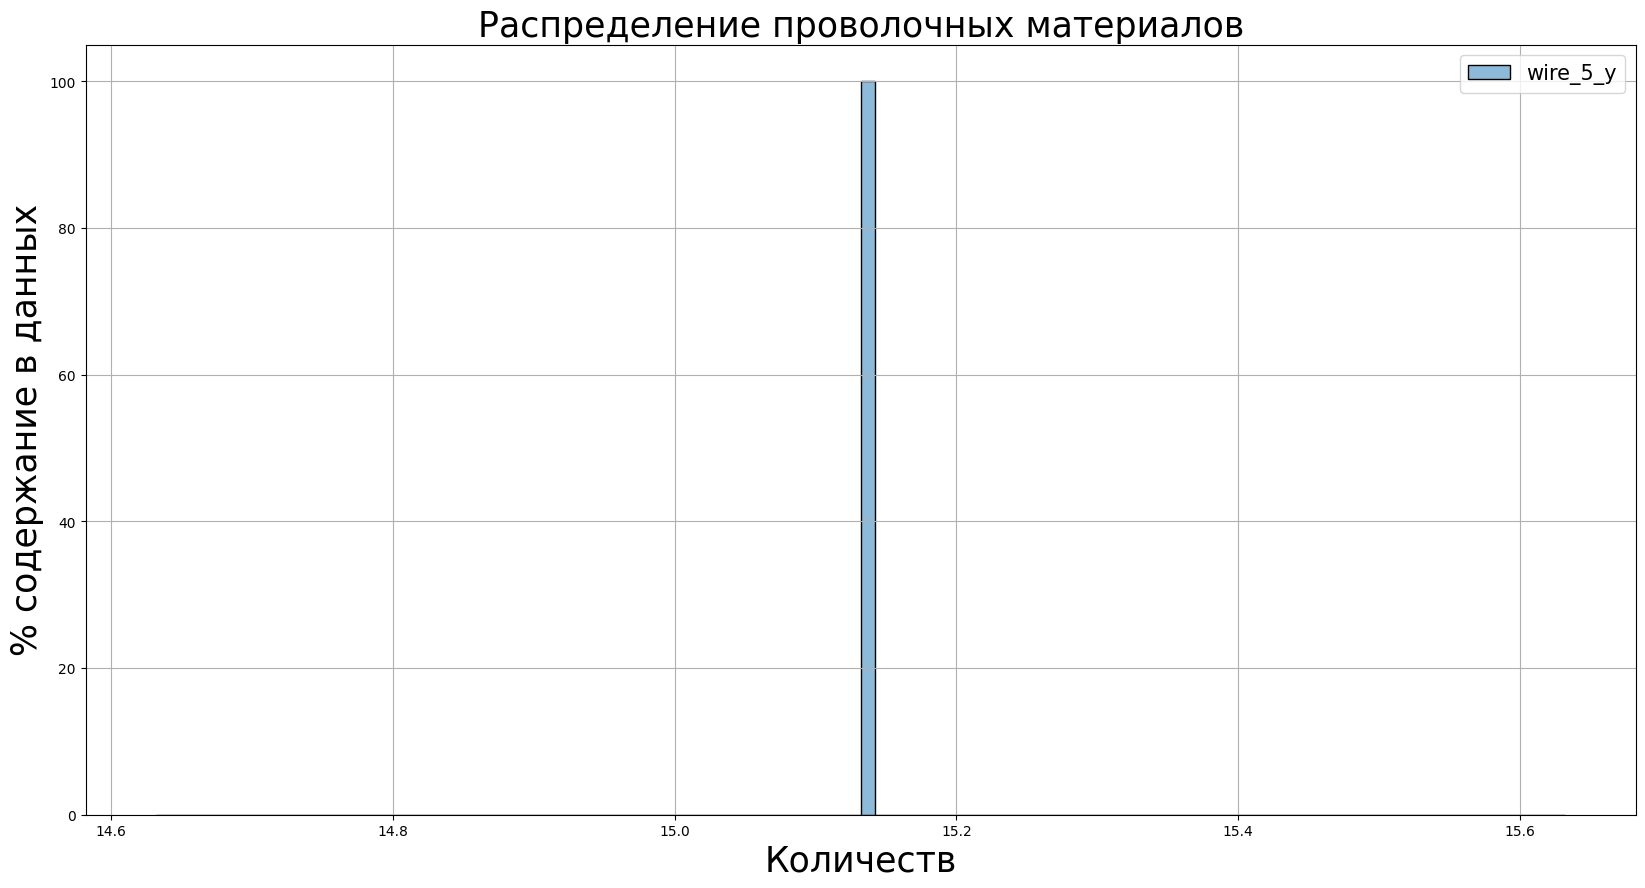

C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


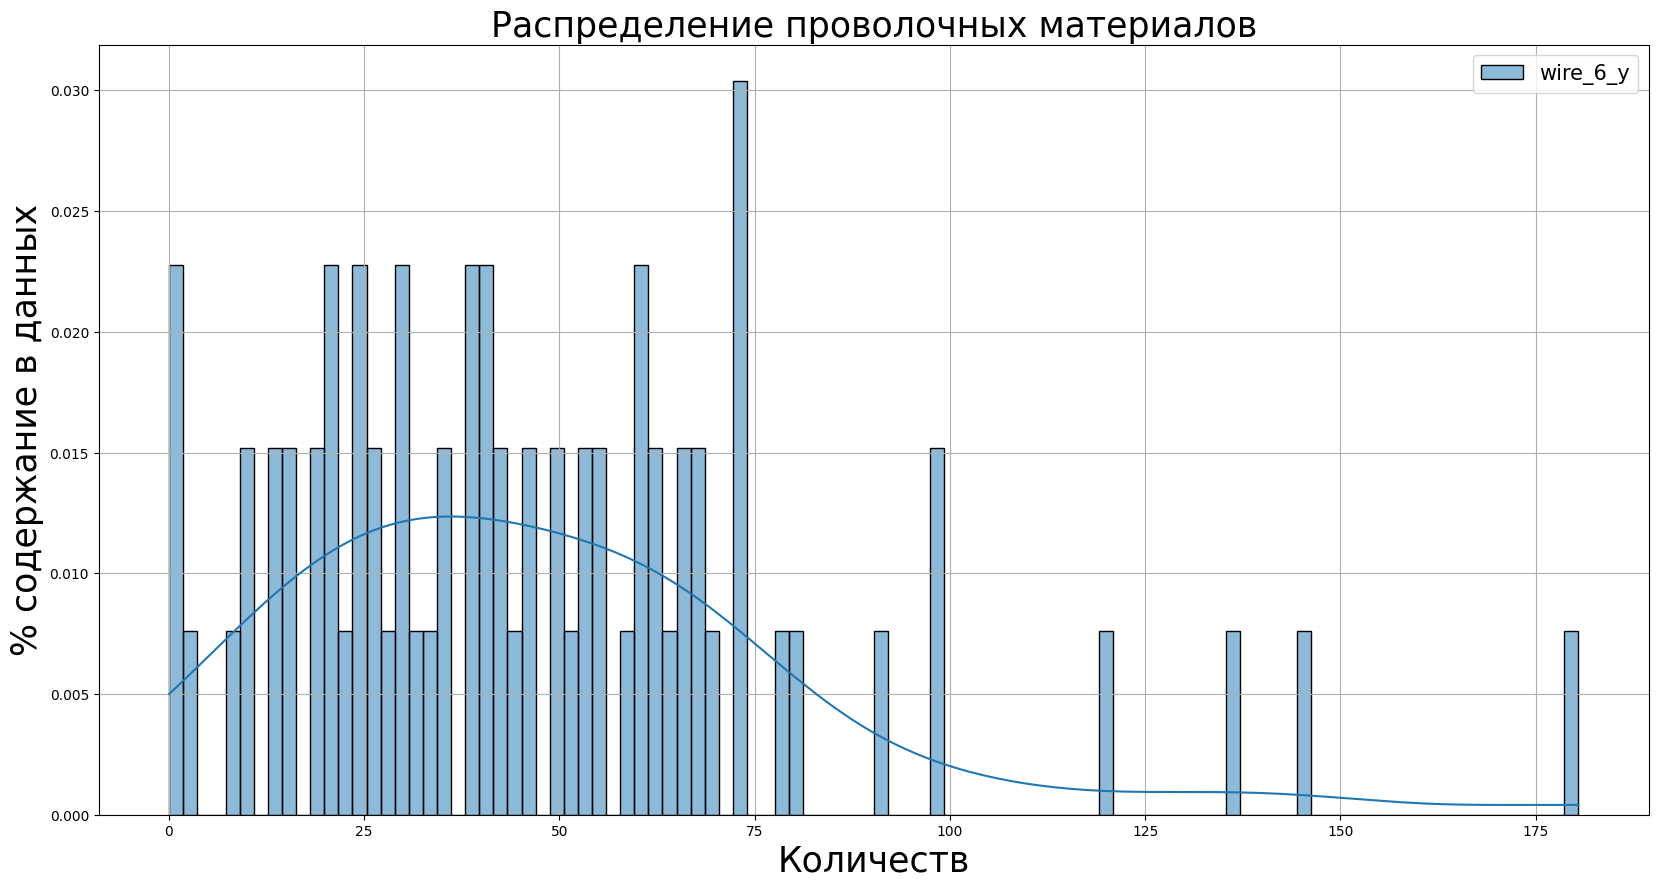

C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


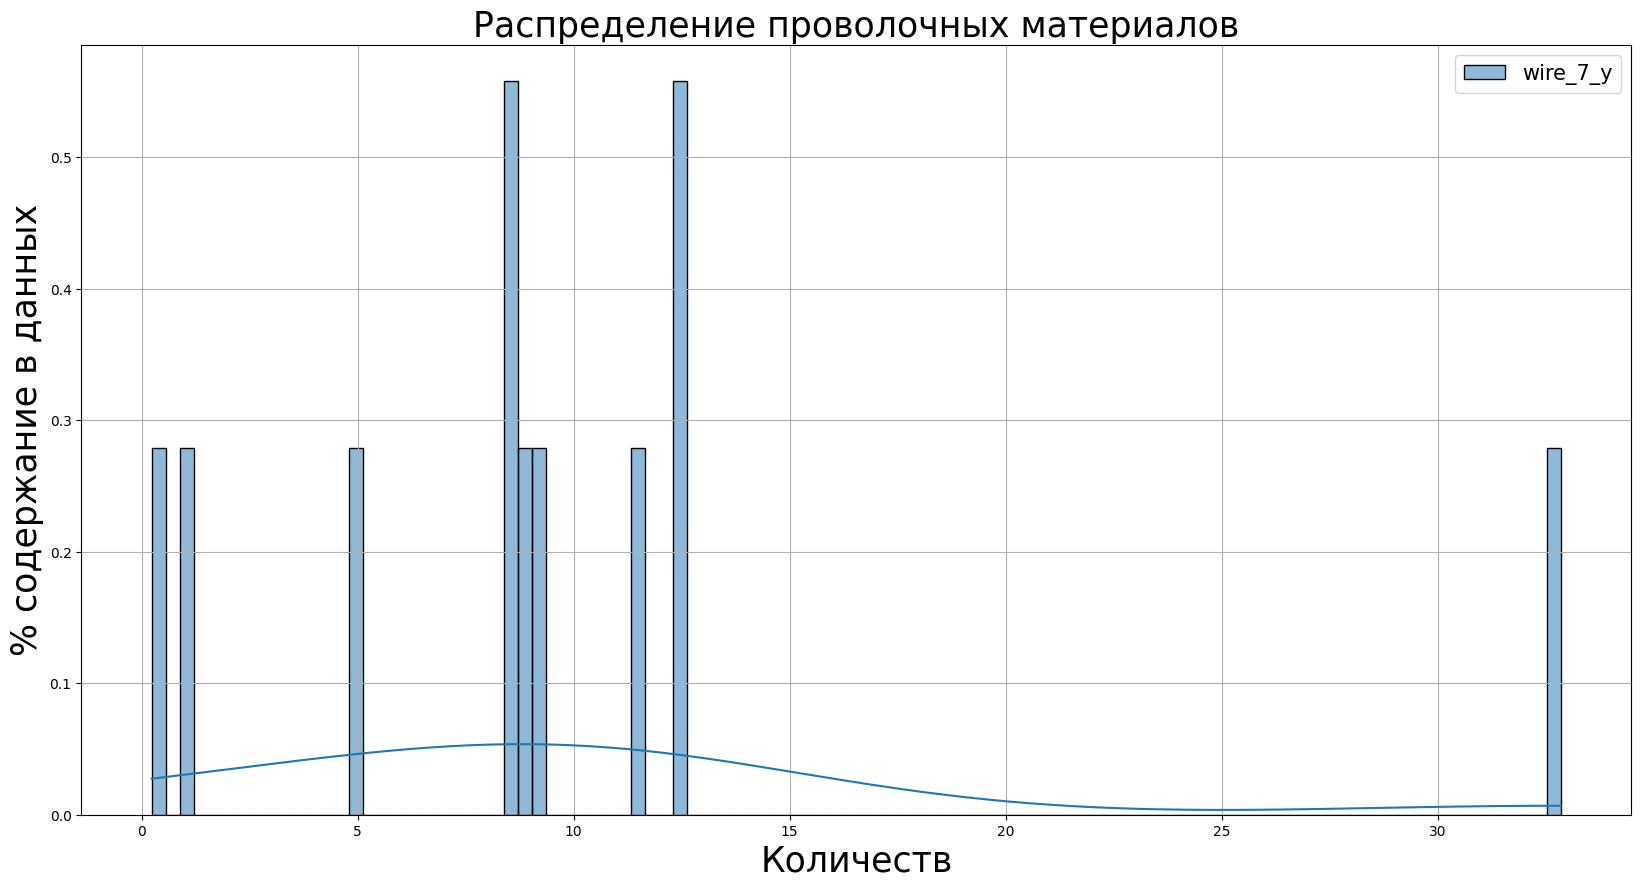

C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


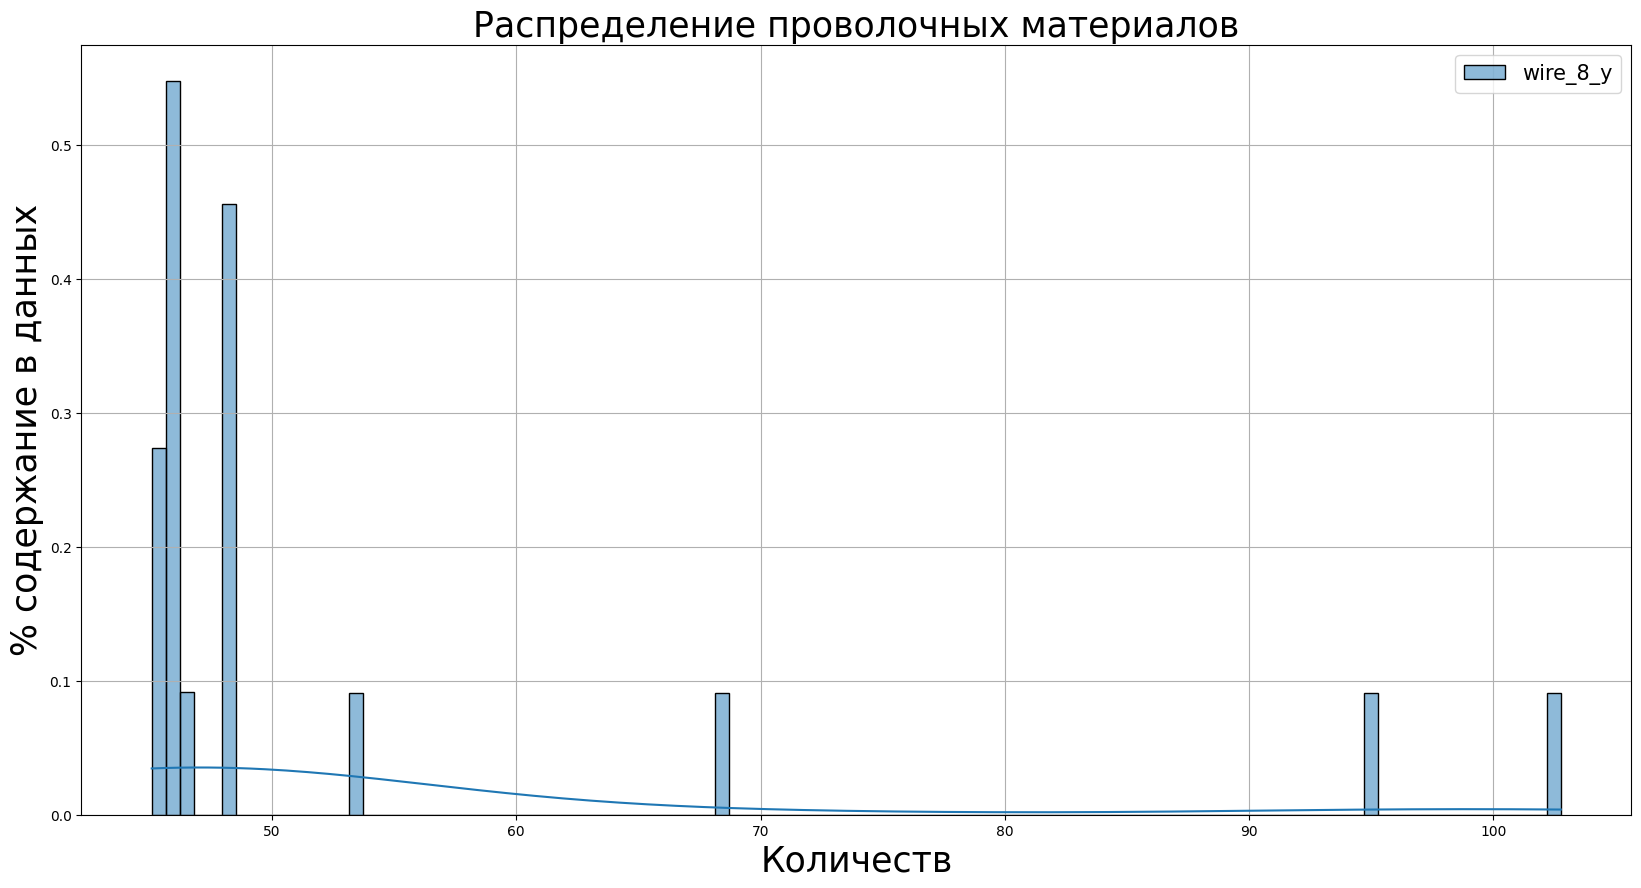

C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Константин\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


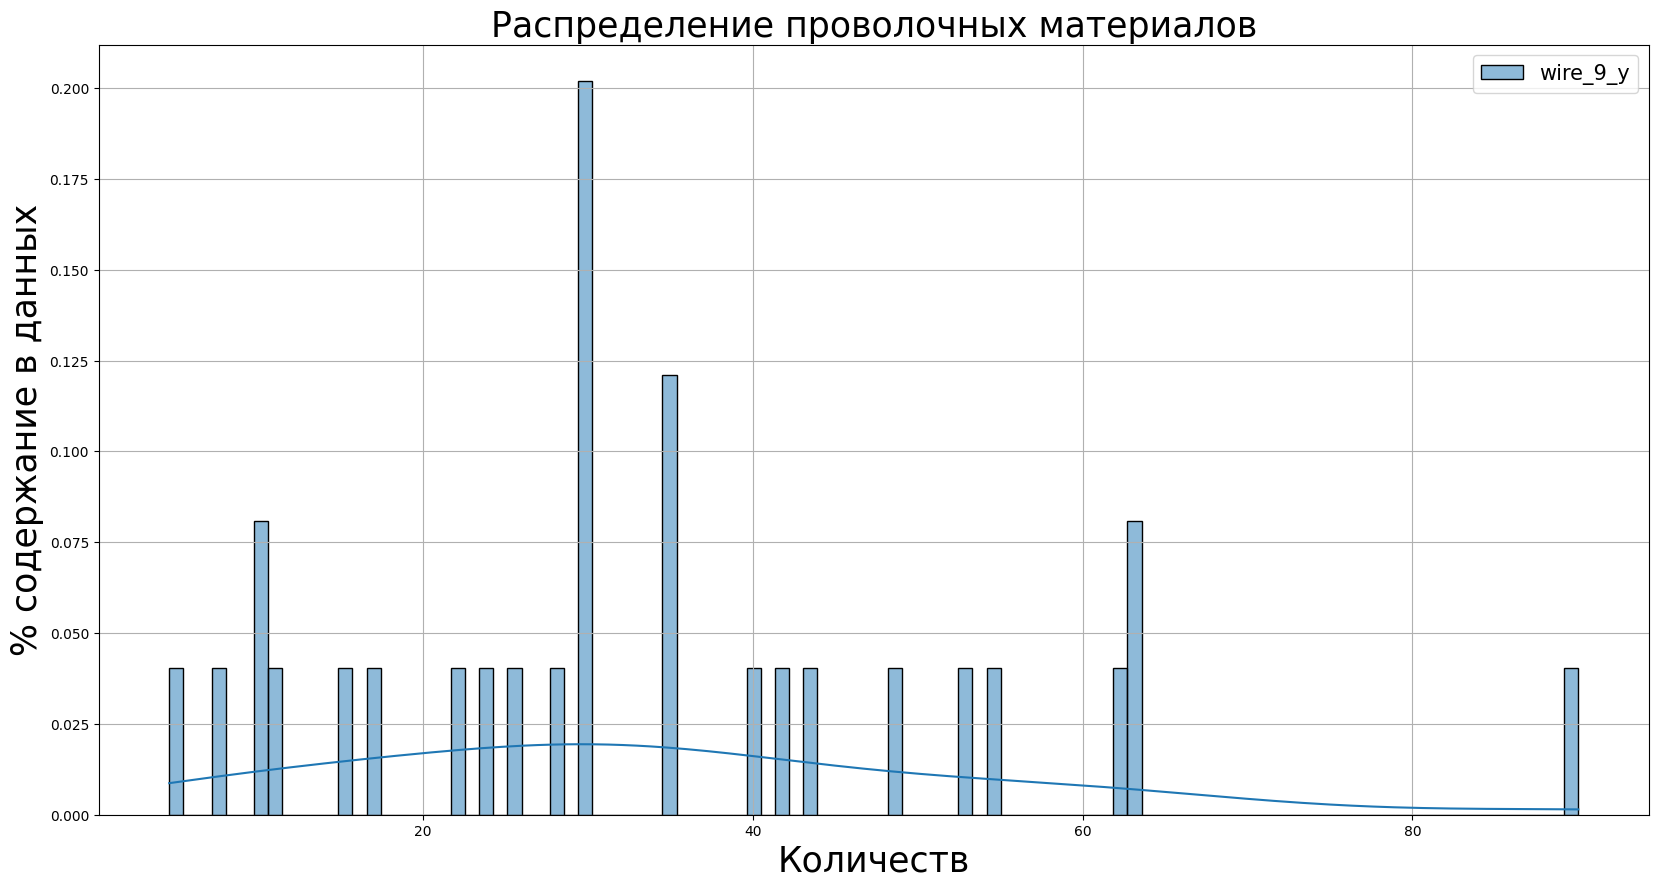

In [25]:
chart1(wire_splice,'Распределение проволочных материалов','Количеств','% содержание в данных')

По итогу анализа данных и встречи с представителем бизнеса был сделан вывод и составлен план работ.

**Вывод**
- Пропуски в данных означают, что данный материал не участвовал при изготовлении сплав.
- Аномальные выбросы в большинстве случаев связаны с изготовлением редкого сплава.
- Дубликаты не обнаружены.
- Цель проекта предсказывать температуру розлива, что бы избежать перегрева вследствие чего расходуется энергия и ресурс огнеупорного кирпича.
- Будет решаться задача регрессии по каждому ковшу в отдельности не опираясь на временные ряды.
- Метрика качества MAE <= 6,8.

**План**
- Отсечь редкие события такие как мало используемые материалы, выбросы по температуре и мощности.
- Определить общий параметр для партий в которых присутствует несколько итерация.
- Объединить таблицы в одну по общим для всех партиям.
- Отобрать парамеры с помощью анализа корреляции между ними для упрощения и ускорения работы алгоритма обучения.
- Разбить данные на выборки и применить кодирование.
- Обучить 3 модели. LinearRegression, RandomForestRegressor, LGBMRegressor. Выбрать лучшую из них.
- Проверить модель на тестовой выборке.
- Сделать выводы.

##  Разработка модели

Исключим редкие параметры.

In [26]:
# дублирование данных перед изменениями
data_bulk_2 = data_bulk.copy(deep=True)
data_wire_2 = data_wire.copy(deep=True)
data_arc_2 = data_arc.copy(deep=True)
data_gas_2 = data_gas.copy(deep=True)
data_temp_2 = data_temp.copy(deep=True)

In [27]:
# функция для вывода основной информации о данных
def data_research2(data):    
    print('Процент (%) показателей в каждой категории данных.')
    display(100 - ((data.isna().sum() / data.shape[0]) * 100))

In [28]:
# список с данными о подачи материалов
data1 = [data_bulk_2, data_wire_2]

In [29]:
for d in data1:
    data_research2(d)

Процент (%) показателей в каждой категории данных.


key        100.000000
bulk_1       8.053691
bulk_2       0.703100
bulk_3      41.482902
bulk_4      32.406520
bulk_5       2.460850
bulk_6      18.408437
bulk_7       0.798977
bulk_8       0.031959
bulk_9       0.607223
bulk_10      5.624800
bulk_11      5.656759
bulk_12     78.299776
bulk_13      0.575264
bulk_14     89.677213
bulk_15     71.844040
dtype: float64

Процент (%) показателей в каждой категории данных.


key       100.000000
wire_1     99.156118
wire_2     35.021097
wire_3      2.044791
wire_4      0.454398
wire_5      0.032457
wire_6      2.369361
wire_7      0.357027
wire_8      0.616683
wire_9      0.941253
dtype: float64

In [30]:
# замена пропусков 0
data_bulk_2 = data_bulk_2.fillna(0)
data_wire_2 = data_wire_2.fillna(0)
data_temp_2 = data_temp_2.fillna(0)

Удалим партии в состав которых входят материалы используемые менее 1%.

In [31]:
data_bulk_2 = data_bulk_2[(data_bulk_2['bulk_2'] == 0)]
data_bulk_2 = data_bulk_2[(data_bulk_2['bulk_7'] == 0)]
data_bulk_2 = data_bulk_2[(data_bulk_2['bulk_8'] == 0)]
data_bulk_2 = data_bulk_2[(data_bulk_2['bulk_9'] == 0)]
data_bulk_2 = data_bulk_2[(data_bulk_2['bulk_13'] == 0)]

In [32]:
data_wire_2 = data_wire_2[(data_wire_2['wire_4'] == 0)]
data_wire_2 = data_wire_2[(data_wire_2['wire_5'] == 0)]
data_wire_2 = data_wire_2[(data_wire_2['wire_7'] == 0)]
data_wire_2 = data_wire_2[(data_wire_2['wire_8'] == 0)]
data_wire_2 = data_wire_2[(data_wire_2['wire_9'] == 0)]

Удалим столбцы с данными материалами.

In [33]:
data_bulk_2 = data_bulk_2.drop(['bulk_2', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_13'], axis=1)
data_wire_2 = data_wire_2.drop(['wire_4', 'wire_5', 'wire_7', 'wire_8', 'wire_9'], axis=1)

Удалим отрицательные показатели мощности.

In [34]:
data_arc_2 = data_arc_2[data_arc_2['active_power'] > 0]
data_arc_2 = data_arc_2[data_arc_2['reactive_power'] > 0]

Удалим партии где нет последнего замера температуры.  
Удалим аномалии с низкими показателями температуры, которые могут быть связаны с редкими металлами. Ограничим нижний порог минимальной температурой плавления стали в 1450 градусов.

In [35]:
data_temp_2 = data_temp_2.groupby('key').filter(lambda x: x.iloc[-1]['temperature'] != 0)
data_temp_2 = data_temp_2[data_temp_2['temperature'] > 1450]

In [36]:
print('Было удалено {:.2%} редких значений в data_bulk_2.'
      .format(((data_bulk.shape[0] - data_bulk_2.shape[0]) / data_bulk.shape[0])))
print('Было удалено {:.2%} редких значений в data_wire_2.'
      .format(((data_wire.shape[0] - data_wire_2.shape[0]) / data_wire.shape[0])))
print('Было удалено {:.2%} редких значений в data_arc_2.'
      .format(((data_arc.shape[0] - data_arc_2.shape[0]) / data_arc.shape[0])))
print('Было удалено {:.2%} редких значений в data_gas_2.'
      .format(((data_gas.shape[0] - data_gas_2.shape[0]) / data_gas.shape[0])))
print('Было удалено {:.2%} редких значений в data_temp_2.'
      .format(((data_temp.shape[0] - data_temp_2.shape[0]) / data_temp.shape[0])))

Было удалено 2.17% редких значений в data_bulk_2.
Было удалено 2.21% редких значений в data_wire_2.
Было удалено 0.01% редких значений в data_arc_2.
Было удалено 0.00% редких значений в data_gas_2.
Было удалено 22.92% редких значений в data_temp_2.


Подготовим таблицы для объединения. Соединим итерации в партиях в одну.

Создадим таблицу где в каждой партии будет указана первая и последняя замеренная температура, время первого и последнего замера.

In [37]:
data_temp_2 = data_temp_2.groupby('key').agg(['first', 'last'])

In [38]:
# переименование столбцов
data_temp_2.columns = ['time_first', 'time_last', 'temp_first', 'temp_last']

Удалим итерации в замерах мощности которые производились до первого замера температуры. Без первоначальной температуры нельзя предположить как мощность повлияла на ее изменения температуры.

In [39]:
# передаем номер индекса
for d in data_temp_2.index:
    # передаем номер индекса итерации в партии 
    for d2 in data_arc_2[data_arc_2['key'] == d]['start_of_arc_heating'].index:
        # если время измерения мощности раньше измерения температуры
        if data_arc_2[data_arc_2['key'] == d]['start_of_arc_heating'][d2] < data_temp_2['time_first'][d]:
            # удаляем эту строку по номеру индекса выбранному в итерации по времени
            data_arc_2 = data_arc_2.drop(index= data_arc_2[data_arc_2['start_of_arc_heating'] == data_arc_2[data_arc_2['key'] == d]['start_of_arc_heating'][d2]].index[0])

Вычислим время нагрева.

In [40]:
data_arc_2['total_time'] = data_arc_2['end_of_arc_heating'] - data_arc_2['start_of_arc_heating'] 

Переведем в секунды.

In [41]:
data_arc_2['total_time'] = data_arc_2['total_time'] / np.timedelta64(1, 's')

Для каждой партии рассчитаем суммарную полную мощность.

$$
S = \sqrt{P^2 + Q^2}
$$

Обозначения:

- $S$ — полная мощность

- $P$ — активная мощность

- $Q$ — реактивная мощность


In [42]:
data_arc_2 = data_arc_2.groupby('key').agg(total_time = ('total_time', 'sum'),
                                           p_active_power = ('active_power', 'sum'),
                                           q_reactive_power = ('reactive_power', 'sum'))

In [43]:
data_arc_2['s_total_value'] = np.sqrt(data_arc_2['p_active_power']**2 + data_arc_2['q_reactive_power']**2)

Удалим столбцы с множителями и время замеров температуры.

In [44]:
data_arc_2 = data_arc_2.drop(['p_active_power', 'q_reactive_power'], axis=1)
data_temp_2 = data_temp_2.drop(['time_first', 'time_last'], axis=1)

In [45]:
data_arc_2

total_time  s_total_value
key                            
1          513.0       2.777442
2          674.0       3.126860
3          375.0       1.732976
4          278.0       1.435385
5          486.0       2.254131
...          ...            ...
3237       909.0       4.844014
3238       546.0       2.695151
3239      1216.0       5.608989
3240       839.0       3.882186
3241       659.0       2.997523

[3183 rows x 2 columns]

Объединим все таблицы в одну.

In [46]:
summary_table = data_temp_2.merge(data_arc_2, how = 'left', on = 'key')

In [47]:
summary_table

temp_first  temp_last  total_time  s_total_value
key                                                   
1         1571.0     1613.0       513.0       2.777442
2         1581.0     1602.0       674.0       3.126860
3         1596.0     1599.0       375.0       1.732976
4         1601.0     1625.0       278.0       1.435385
5         1576.0     1602.0       486.0       2.254131
...          ...        ...         ...            ...
2495      1570.0     1591.0       516.0       2.862868
2496      1554.0     1591.0       823.0       4.569080
2497      1571.0     1589.0       413.0       2.115469
2498      1591.0     1594.0       494.0       2.713486
2499      1569.0     1603.0       571.0       3.186092

[2477 rows x 4 columns]

Удалим пропуски, которые образовались из-за того что первое и последнее измерение мощности было еще до замера температуры.

In [48]:
summary_table = summary_table.dropna()

Восстановим партии из индекса обратно в столбец key, что объединить остальные таблицы.

In [49]:
summary_table = summary_table.rename_axis('key').reset_index()

Объединим оставшиеся таблицы.

In [50]:
summary_table = summary_table.merge(data_bulk_2)
summary_table = summary_table.merge(data_wire_2)
summary_table = summary_table.merge(data_gas_2)

Удалим столбец key. Он не несет информации.

In [51]:
summary_table = summary_table.drop(['key'], axis=1)

In [52]:
summary_table

temp_first  temp_last  total_time  s_total_value  bulk_1  bulk_3  \
0         1571.0     1613.0       513.0       2.777442     0.0     0.0   
1         1581.0     1602.0       674.0       3.126860     0.0     0.0   
2         1596.0     1599.0       375.0       1.732976     0.0     0.0   
3         1601.0     1625.0       278.0       1.435385     0.0     0.0   
4         1576.0     1602.0       486.0       2.254131     0.0     0.0   
...          ...        ...         ...            ...     ...     ...   
2232      1570.0     1591.0       516.0       2.862868     0.0    21.0   
2233      1554.0     1591.0       823.0       4.569080     0.0     0.0   
2234      1571.0     1589.0       413.0       2.115469     0.0     0.0   
2235      1591.0     1594.0       494.0       2.713486     0.0    90.0   
2236      1569.0     1603.0       571.0       3.186092     0.0    47.0   

      bulk_4  bulk_5  bulk_6  bulk_10  bulk_11  bulk_12  bulk_14  bulk_15  \
0       43.0     0.0     0.0      0.0      0.0    206.0    150.0    154.0   
1       73.0     0.0     0.0      0.0      0.0    206.0    149.0    154.0   
2       34.0     0.0     0.0      0.0      0.0    205.0    152.0    153.0   
3       81.0     0.0     0.0      0.0      0.0    207.0    153.0    154.0   
4       78.0     0.0     0.0      0.0      0.0    203.0    151.0    152.0   
...      ...     ...     ...      ...      ...      ...      ...      ...   
2232     0.0     0.0     0.0     90.0      0.0    256.0    129.0    223.0   
2233    63.0     0.0     0.0    122.0      0.0    256.0    129.0    226.0   
2234    85.0     0.0     0.0      0.0      0.0    230.0    124.0    226.0   
2235     0.0     0.0     0.0    101.0      0.0    206.0    129.0    207.0   
2236     0.0     0.0     0.0      0.0      0.0    233.0    126.0    227.0   

          wire_1    wire_2  wire_3  wire_6      gas_1  
0      60.059998   0.00000     0.0     0.0  29.749986  
1      96.052315   0.00000     0.0     0.0  12.555561  
2      91.160157   0.00000     0.0     0.0  28.554793  
3      89.063515   0.00000     0.0     0.0  18.841219  
4      89.238236   9.11456     0.0     0.0   5.413692  
...          ...       ...     ...     ...        ...  
2232   89.150879   0.00000     0.0     0.0   7.125735  
2233  114.179527   0.00000     0.0     0.0   9.412616  
2234   94.086723   9.04800     0.0     0.0   6.271699  
2235  118.110717   0.00000     0.0     0.0  14.953657  
2236  110.160958  50.00528     0.0     0.0  11.336151  

[2237 rows x 19 columns]

Проверим корреляцию параметров.

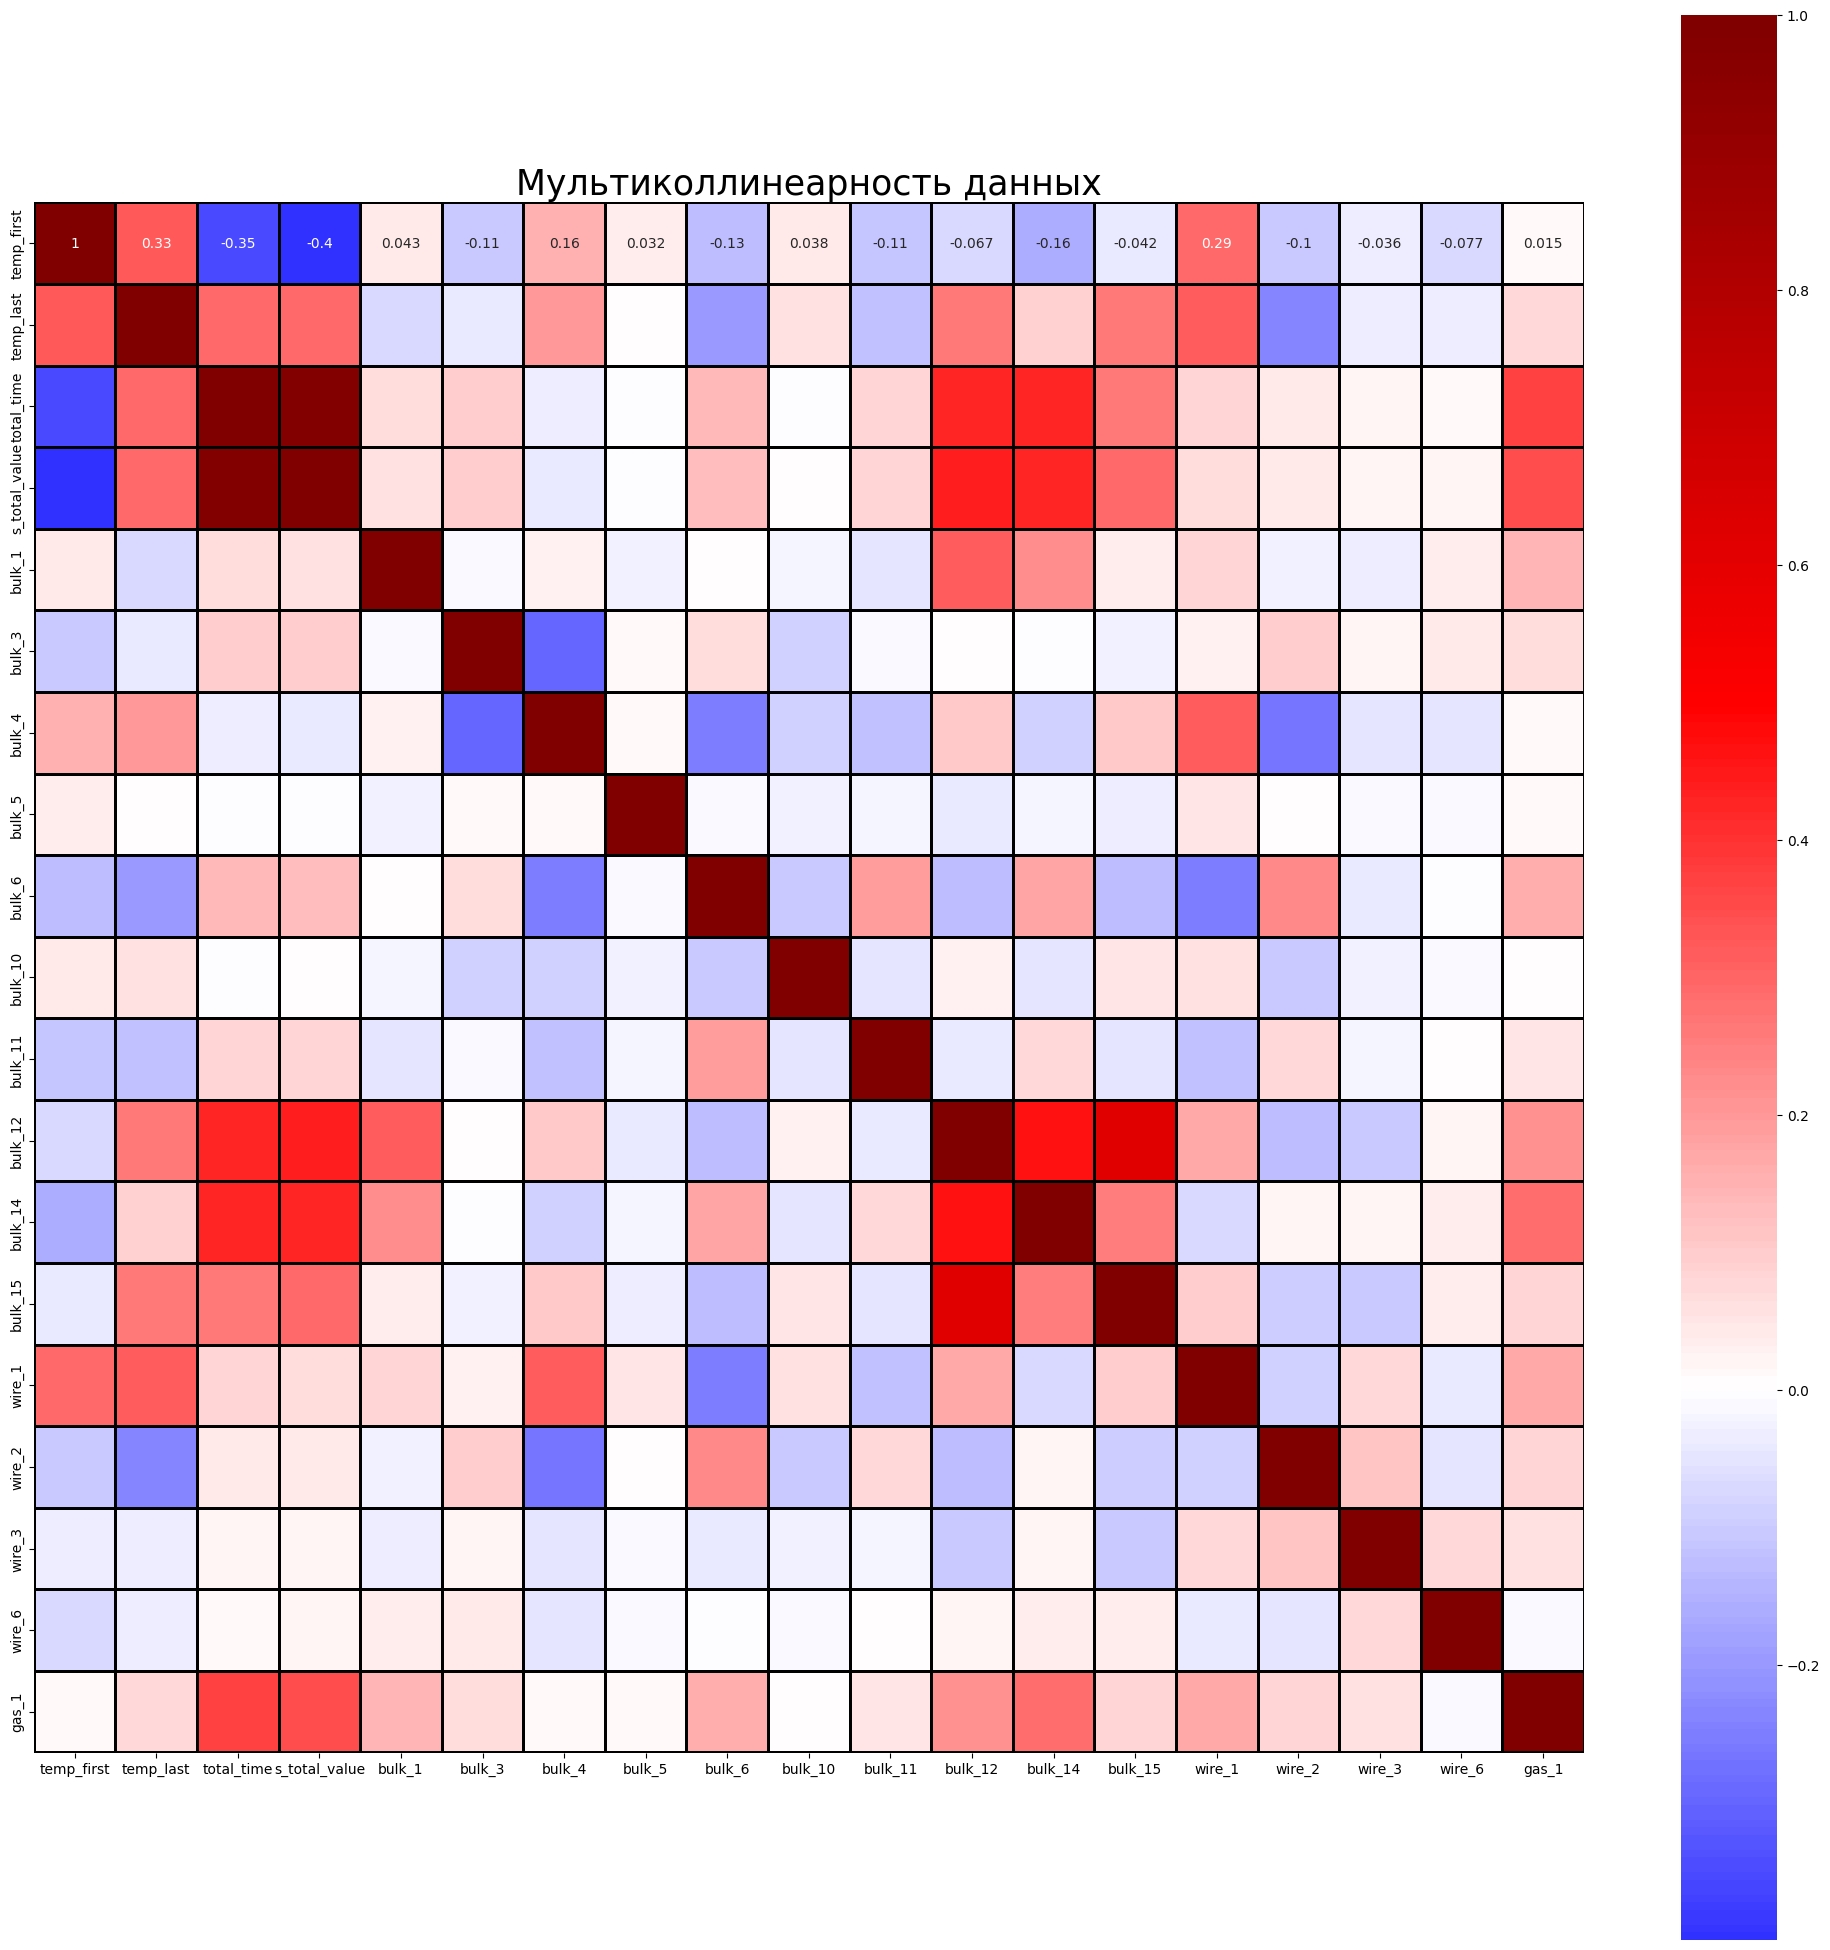

In [53]:
plt.figure(figsize=(25,25))
sns.heatmap(summary_table.corr(), annot=True,
            cmap='seismic', center=0, linewidths=1, linecolor='black',square=True)

plt.title('Мультиколлинеарность данных', fontsize=25)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

Есть взаимосвязь между total_times и s_total_value. Эти параметры одинаково влияют на целевой признак, поэтому удалю время. Также есть связь междуbulk_12 и bulk_15, но я не считаю ее критической.

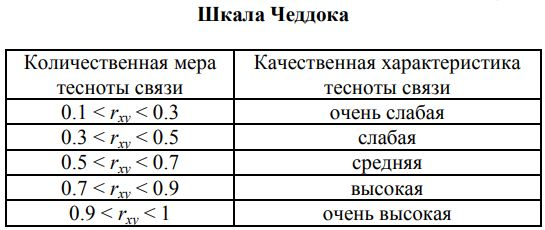

In [54]:
summary_table = summary_table.drop(['total_time'], axis=1)

Разделим на выборки и закодируем признаки.

In [55]:
# функцию разделения данных на обучающую, валидационную, тестовую выборки и кодирования в них данных методом OrdinalEncoder
def division(data):
    features = data.drop('temp_last', axis=1)
    target = data['temp_last']
    
# разделяем выборки в пропорции 75 25
    features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                                  test_size=0.25, 
                                                                                  random_state=RANDOM_STATE)

# масштабируем количественные признаки
    numeric = features_train.columns
    scaler = StandardScaler()
    scaler.fit(features_train[numeric])

    features_train[numeric] = scaler.transform(features_train[numeric])
    features_test[numeric] = scaler.transform(features_test[numeric])
    
    return features_train, features_test, target_train, target_test 

In [56]:
features_train, features_test, target_train, target_test = division(summary_table)

## Обучение  модели

In [57]:
# таблица для сбора показателей моделей
table_1 = pd.DataFrame({'Модель': [], 'MAE': [], 'Параметры модли': []})

In [58]:
%%time
# создание модели
model_1=LinearRegression()
# гиперпараметры для обучение
parameters={}
# рассчет MAE при кросс-валидации
tuning_model_1=GridSearchCV(model_1,param_grid=parameters,scoring=SCORER)
tuning_model_1.fit(features_train, target_train)

# добавление данных в таблицу 
name = 'LinearRegression'
table_1.loc[ len(table_1.index )] = [name,
                                     '{:.2f}'.format(tuning_model_1.best_score_ * -1),
                                     tuning_model_1.best_params_
                                    ]

# вывод данных о модели
table_1

CPU times: total: 31.2 ms
Wall time: 29.8 ms


Модель   MAE Параметры модли
0  LinearRegression  6.33              {}

In [59]:
%%time
# создание модели
model_2=RandomForestRegressor(random_state=RANDOM_STATE)
# гиперпараметры для обучение
parameters={'n_estimators': range (10, 1001, 101),
            'max_depth' : range (1, 11, 3)
           }
# рассчет MAE при кросс-валидации
tuning_model_2=GridSearchCV(model_2,param_grid=parameters,scoring=SCORER) 
tuning_model_2.fit(features_train, target_train)

# добавление данных в таблицу 
name = 'RandomForestRegressor'
table_1.loc[ len(table_1.index )] = [name,
                                     '{:.2f}'.format(tuning_model_2.best_score_ * -1),
                                     tuning_model_2.best_params_
                                    ]

# вывод данных о модели
table_1

CPU times: total: 11min 33s
Wall time: 11min 33s


Модель   MAE                         Параметры модли
0       LinearRegression  6.33                                      {}
1  RandomForestRegressor  6.28  {'max_depth': 10, 'n_estimators': 818}

In [60]:
%%time
# создание модели
model_3=LGBMRegressor(random_state=RANDOM_STATE, verbosity=-1)
# гиперпараметры для обучение
parameters={'n_estimators' : range (100, 1001, 100),
            'num_leaves' : range (50, 1001, 50)
           }
# рассчет MAE при кросс-валидации
tuning_model_3=GridSearchCV(model_3,param_grid=parameters,scoring=SCORER) 
tuning_model_3.fit(features_train, target_train)

# добавление данных в таблицу  
name = 'LGBMRegressor'
table_1.loc[ len(table_1.index )] = [name,
                                     '{:.2f}'.format(tuning_model_3.best_score_ * -1),
                                     tuning_model_3.best_params_]

# вывод данных о модели
table_1

CPU times: total: 49min 42s
Wall time: 6min 13s


Модель   MAE                           Параметры модли
0       LinearRegression  6.33                                        {}
1  RandomForestRegressor  6.28    {'max_depth': 10, 'n_estimators': 818}
2          LGBMRegressor  6.49  {'n_estimators': 100, 'num_leaves': 100}

## Тестирование  модели

In [61]:
# рассчитаем финальное MAE для тестовой выборки на лучшей модели

predictions = tuning_model_2.predict(features_test)


MAE1 = mean_absolute_error(target_test, predictions)

name = 'BestModel'
table_1.loc[ len(table_1.index )] = [name,
                                     '{:.2f}'.format(MAE1),
                                     tuning_model_2.best_params_]
# вывод данных о модели
table_1

Модель   MAE                           Параметры модли
0       LinearRegression  6.33                                        {}
1  RandomForestRegressor  6.28    {'max_depth': 10, 'n_estimators': 818}
2          LGBMRegressor  6.49  {'n_estimators': 100, 'num_leaves': 100}
3              BestModel  5.84    {'max_depth': 10, 'n_estimators': 818}

In [62]:
# рассчитаем финальное MAE для тестовой выборки на проверочной модели

dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(features_train, target_train)



dummy_test_predictions = dummy_model.predict(features_test)


MAE1 = mean_absolute_error(target_test,dummy_test_predictions)

name = 'DummyRegressor'
n = {'strategy': 'mean'}
table_1.loc[ len(table_1.index )] = [name,
                                     '{:.2f}'.format(MAE1),
                                     n]

# вывод данных о модели
table_1

Модель   MAE                           Параметры модли
0       LinearRegression  6.33                                        {}
1  RandomForestRegressor  6.28    {'max_depth': 10, 'n_estimators': 818}
2          LGBMRegressor  6.49  {'n_estimators': 100, 'num_leaves': 100}
3              BestModel  5.84    {'max_depth': 10, 'n_estimators': 818}
4         DummyRegressor  7.84                      {'strategy': 'mean'}

Изучим влияние признаков на целевую переменную.

In [63]:
importances = tuning_model_2.best_estimator_.feature_importances_
feature_list = list(features_train.columns)
feature_influence = pd.DataFrame({'feature': feature_list,'importance': importances})
feature_influence = feature_influence.sort_values('importance',ascending = False).reset_index(drop=True)
feature_influence

feature  importance
0   s_total_value    0.220722
1      temp_first    0.219154
2          wire_1    0.113682
3          bulk_6    0.084931
4           gas_1    0.066534
5         bulk_14    0.056791
6         bulk_15    0.056447
7          wire_2    0.054609
8         bulk_12    0.048201
9          bulk_3    0.028113
10         bulk_4    0.019983
11         bulk_1    0.011529
12        bulk_11    0.007431
13        bulk_10    0.006402
14         wire_3    0.003162
15         bulk_5    0.001530
16         wire_6    0.000780

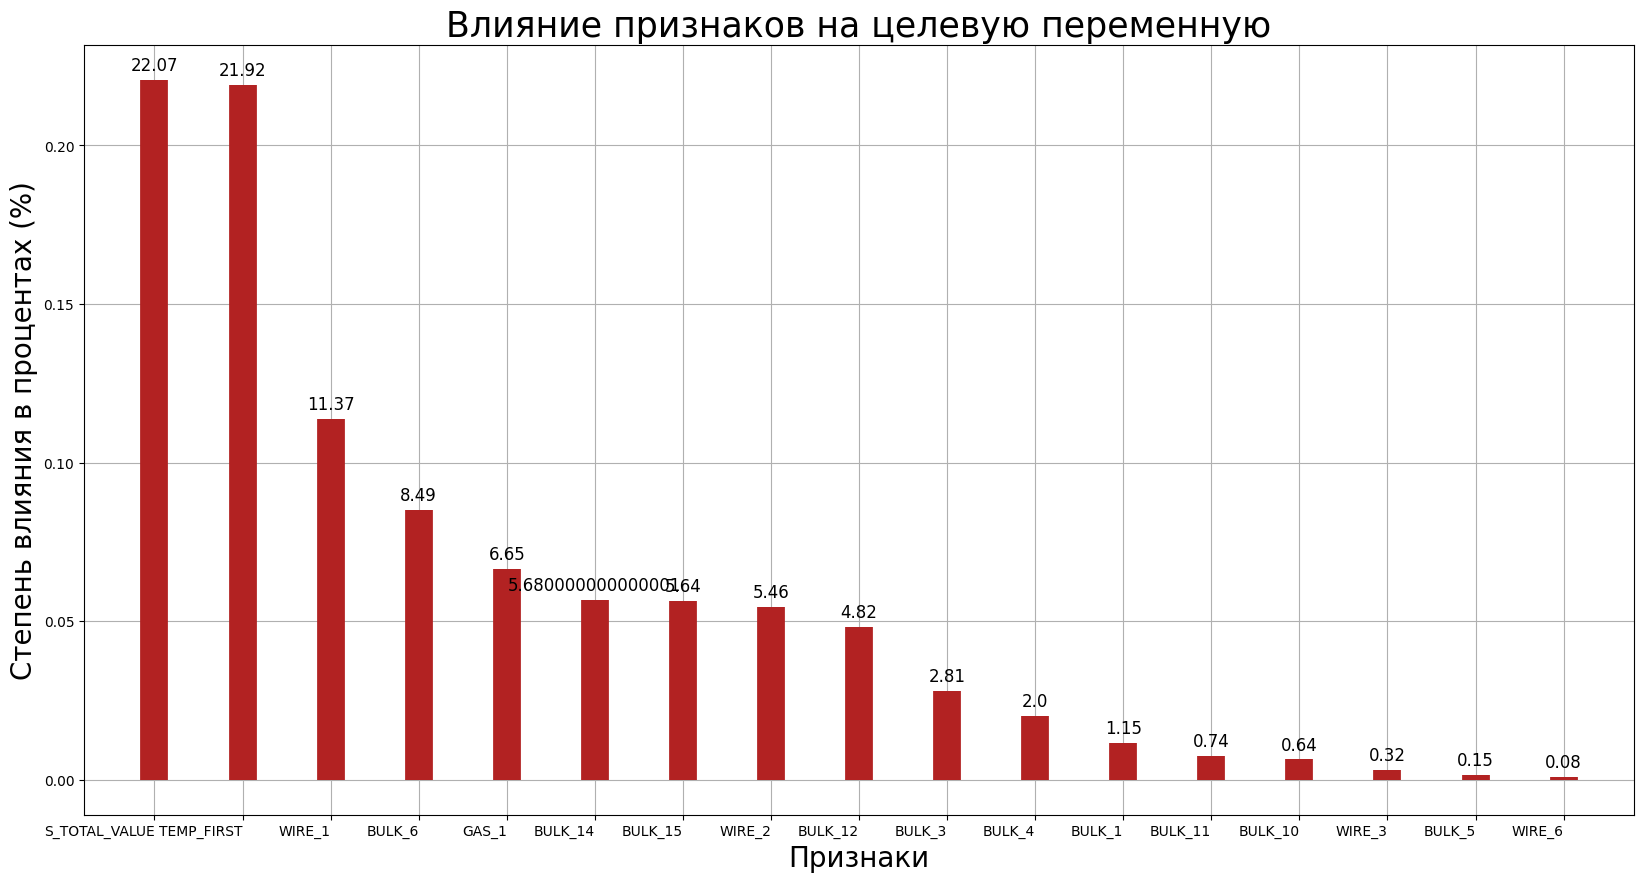

In [64]:
fig, ax = plt.subplots(figsize=(20,10))
ax.vlines(x=feature_influence.index, ymin=0,
          ymax=feature_influence.importance,
          color='firebrick', linewidth=20)

for i, importance in enumerate(feature_influence.importance):
    ax.text(i, importance+0.003, round(importance, 4)*100, horizontalalignment='center',fontsize=12)
    
plt.xticks(feature_influence.index, feature_influence.feature.str.upper(),
           horizontalalignment='right', fontsize=10)

plt.title('Влияние признаков на целевую переменную',fontsize=25)
plt.xlabel('Признаки',fontsize=20)
plt.ylabel('Степень влияния в процентах (%)',fontsize=20)
plt.grid()
plt.show()

Считаю, что признаки, которые имеют степень влияния 1% и ниже можно отсечь.

In [65]:
features_train_2 = features_train.copy(deep=True)
features_test_2 = features_test.copy(deep=True)

In [66]:
features_train_2 = features_train_2.drop(['bulk_11', 'bulk_10',
                                          'wire_3', 'bulk_5', 'wire_6'], axis=1)
features_test_2 = features_test_2.drop(['bulk_11', 'bulk_10',
                                          'wire_3', 'bulk_5', 'wire_6'], axis=1)

In [67]:
# рассчитаем финальное MAE для тестовой выборки на проверочной модели

model_test = RandomForestRegressor(random_state=RANDOM_STATE, n_estimators=801, max_depth=10)
model_test.fit(features_train_2, target_train)

model_test_predictions = model_test.predict(features_test_2)

MAE1 = mean_absolute_error(target_test,model_test_predictions)

name = 'RandomForestRegressor_test'
n = {'max_depth': 10, 'n_estimators': 801}
table_1.loc[ len(table_1.index )] = [name, '{:.2f}'.format(MAE1), n]

# вывод данных о модели
table_1

Модель   MAE                           Параметры модли
0            LinearRegression  6.33                                        {}
1       RandomForestRegressor  6.28    {'max_depth': 10, 'n_estimators': 818}
2               LGBMRegressor  6.49  {'n_estimators': 100, 'num_leaves': 100}
3                   BestModel  5.84    {'max_depth': 10, 'n_estimators': 818}
4              DummyRegressor  7.84                      {'strategy': 'mean'}
5  RandomForestRegressor_test  5.82    {'max_depth': 10, 'n_estimators': 801}

## Отчёт

- 1. Выполнены все пункты планы.  
 - Удалены редкие события и аномалии.  
 - Партии сгруппированы по итерациям.  
 - Таблицы соединены в одну общую.  
 - Произведен отбор параметров на основе корреляции между ними.  
 - Данные разбиты на выборки и стандартизированны.  
 - Обучены 3 модели на крос-валидации. LinearRegression, RandomForestRegressor, LGBMRegressor.    
 - Достигнуты требуемые показатели метрики MAE <= 6.8 на тестовой выборке.  
  2. В ходе проекта возникали трудности в объединение итераций в партии, отбором признаков по их важности для прогнозирования. Справится с этим мне помогли встречи с тимлидом, его советы, советы наставника, и поиск в других источниках.      
  3. Ключевыми моментами считаю выбор способа по которому группировались итерации в партиях и вследствие чего появлялись новые признаки, способы отбора важности параметров для лучшей работы алгоритма.   
  4. Лучший результат на крос-валидации показала модель RandomForestRegressor (MAE = 6.28). После проверки на тестовой выборке она показала результат (MAE = 5.84).  
-  Выбор параметров. 
 - Поскольку партии усреднялись и измерения производятся в конкретном ковше то временные измерения были отсечены.    
 - temp_first - оставлена как начало отсчета по температуре.  
 - total_time - время нагрева от первого замера температуры и до температуры на розливе. Был удален так как имел высокую корреляцию с s_total_value.  
 - s_total_value - суммарная мощность поданная после первого замера температуры и до температуры на розливе.    
 - bulk - сыпучие материалы которые применяются более чем в 1% случаев.  
 - wire  - проволочные материалы которые применяются более чем в 1% случаев.  
 - gas_1 - не корректировался. 
 - После крос-вылидации лучшую модель проанализировали на зависимость целевого признака от остальных показателей. Если влияние было менее 1% этот признак удалялся.  
 
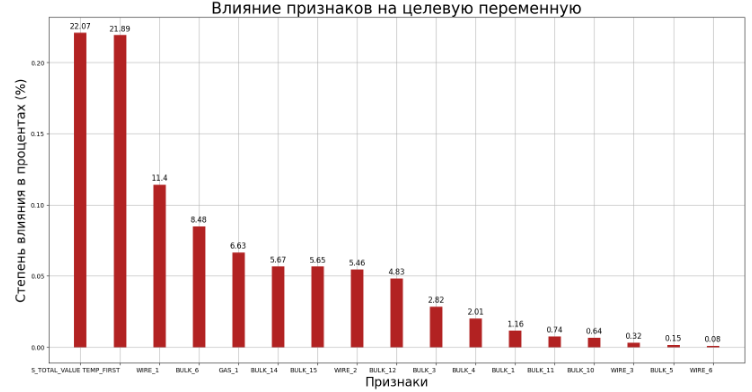 
 
- Гиперпараметрами лучшей модели являются {'random_state': 70423, 'max_depth': 10, 'n_estimators': 801}.    
- Для улучшения модели требуется увеличение данных для анализа, точность замеров, и начальные характеристики партий. 


